# Analysis of Gradient Boosting Results + Complexity Measures per Level of complexity

Now we have a total of 112 datasets. We want to split them according to their level of complexity and study the results in the different categories. The objective is to investigate if we obtain better results than classic boosting for some levels of complexity (for example, for the hardest datasets).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import math


os.chdir("..")
root_path = os.getcwd()

In [2]:
path_csv = os.path.join(root_path, 'Results_GB')
os.chdir(path_csv)

In [3]:
#colour_palette_personalized = ["#FFD700", "#00CED1", "#FF1493","#F1F1F1"]
colour_palette_personalized = {
    "classic": "#FFD700",   # yellow
    "sample_weight_easy": "#C7F7FF", # blue
    "sample_weight_easy_x2": "#00CED1", # blue
    "sample_weight_hard": "#FFB3DA",    # magenta
    "sample_weight_hard_x2": "#FF1493",    # magenta
    "Classic": "#FFD700",   # yellow
    "Easy": "#C7F7FF", # blue
     "Easy x2": "#00CED1", # blue
    "Hard": "#FFB3DA",    # magenta
     "Hard x2": "#FF1493"    # magenta
}



In [4]:
specific_path = os.path.join(path_csv, '*Aggregated*.csv')
selected_files = glob.glob(specific_path)
all_datasets = pd.concat([pd.read_csv(f) for f in selected_files], ignore_index=True)

We already have the complexity characteristics of each dataset in the csv complex_info_dataset_20250115.csv. We read it and split the datasets according to the complexity values of each complexity measure.

In [5]:
path_complex = os.path.join(root_path, 'datasets/complexity_info')
os.chdir(path_complex)
df_complex = pd.read_csv('complex_info_dataset_20250115.csv')
df_complex.head()

dataset  Hostility       kDN        DS       DCP  \
0     analcatdata_gviolence   0.229730  0.083784  0.219595  0.050778   
1  analcatdata_japansolvent   0.250000  0.265385  0.384615  0.000000   
2      analcatdata_vineyard   0.158120  0.188462  0.605078  0.493827   
3            arrhythmia_cfs   0.205752  0.316372  0.573684  0.177085   
4                Australian   0.175362  0.185507  0.615459  0.211243   

       TD_U      TD_P        MV        CB       CLD        N1        N2  \
0  0.489865  1.000000  0.116908  0.657901  0.187850  0.064189  0.249374   
1  0.461538  0.461538  0.035613  0.666174  0.336514  0.247436  0.400943   
2  0.500986       NaN  0.088889  0.662551  0.418386  0.150641  0.245928   
3  0.572607  0.692232  0.071031  0.664311  0.331718  0.316758  0.471772   
4  0.568237  0.761594  0.088288  0.662623  0.220640  0.192174  0.398111   

        LSC  LSradius         H         U        F1        F2        F3  \
0  0.589575  0.608601  0.027027  0.600292  0.405405  0.000000  0.612981   
1  0.768121  0.791536  0.038462  0.776809  0.766827  0.538542  0.757220   
2  0.975808  0.948771  0.004274  0.975912  0.849003  0.736191  0.799548   
3  0.981821  0.715307  0.004425  0.981899  0.745515  0.603953  0.801924   
4  0.969318  0.799725  0.002899  0.969406  0.519876  0.664697  0.757345   

         F4  
0  0.911090  
1  0.916458  
2  0.862728  
3  0.989752  
4  0.995492

In [6]:
list_CM = ['Hostility','kDN','DCP','TD_U','CLD','N1','N2','LSC','F1']

Para este análisis lo que voy a hacer es:
 * Dividir el rango de cada medida de complejidad en 3: fácil, medio, difícil. Esto lo haré automáticamente con alguna función de python puesto que para algunas medidas (por ejemplo, F1 cuyo rango es [0,1] pero con valores muy concentrados en torno al 0.9, no sé interpretar los valores).
  * Para cada medida de complejidad, estudiar los resultados en estos cortes. Miraré media, mediana y std de accuracy y el WTL.
  * Luego hago el estudio desde la otra perspectiva. Divido los datasets en función de si, con esa medida de complejidad, gano, empato o pierdo. Creo esas categorías y hago una análisis exploratorio de las mismas. Por ejemplo, grafico la complejidad de dichas categorías mediante boxplots.

In [7]:
# Cogemos la función WTL del otro script
def win_tie_loss_comparison_info_complexity(data, complexity_df, main_method, compare_method, loss_function, metric='test_acc_mean',
                                            n_ensemble_values=[10, 25, 50, 100, 150, 200, 250, 300]):
    """
    Realiza un análisis win-tie-loss comparando el método principal con otro método específico para cada medida de complejidad.

    Parameters:
    - data: DataFrame con las columnas ['dataset', 'n_ensemble', 'method_weights', 'compl_measure', metric]
    - main_method: método principal que se desea comparar (ejemplo: 'classic')
    - compare_method: método específico con el cual comparar el principal (ejemplo: 'init_easy')
    - metric: métrica de comparación (por defecto 'test_acc_mean')
    - n_ensemble_values: valores de n_ensemble a considerar

    Returns:
    - Una tabla con el conteo de wins, ties, y losses por cada valor de n_ensemble y medida de complejidad.
    """
    results = []
    # Crear una lista para almacenar los resultados
    all_results = []
    value_wtl = 'nada'

    for n in n_ensemble_values:
        # Filtrar los datos para el valor actual de n_ensemble
        subset_n = data[(data['n_ensemble'] == n) & (data['loss_selected'] == loss_function)]


        # Crear un diccionario para almacenar los resultados de esta combinación de n_ensemble
        row = {'n_ensemble': n}

        CM_list = subset_n['compl_measure'].unique()[1:] # to delete none

        for compl in CM_list:
            win, tie, loss = 0, 0, 0

            # Filtrar los datos para la medida de complejidad actual
            subset_compl = subset_n[subset_n['compl_measure'] == compl]
            #if (main_method == 'classic') or (compare_method == 'classic'):
            #     subset_compl_main = subset_n[subset_n['compl_measure'] == 'none']

            for dataset in subset_compl['dataset'].unique():
                # Filtrar para el dataset y métod en cuestión

                if (main_method == 'classic'):
                    subset_compl_main = subset_n[subset_n['compl_measure'] == 'none']
                    main_value = subset_compl_main[(subset_compl_main['dataset'] == dataset) & (subset_compl_main['method_weights'] == main_method)][metric].values
                else:
                    main_value = subset_compl[(subset_compl['dataset'] == dataset) & (subset_compl['method_weights'] == main_method)][metric].values
                if (compare_method == 'classic'):
                    subset_compl_compare = subset_n[subset_n['compl_measure'] == 'none']
                    compare_value = subset_compl_compare[(subset_compl_compare['dataset'] == dataset) & (subset_compl_compare['method_weights'] == compare_method)][metric].values
                else:
                    compare_value = subset_compl[(subset_compl['dataset'] == dataset) & (subset_compl['method_weights'] == compare_method)][metric].values

                # Verificar que tenemos valores únicos para cada dataset y métod
                if main_value.size > 0 and compare_value.size > 0:
                    main_value = main_value[0]
                    compare_value = compare_value[0]

                    # Comparación win-tie-loss
                    if main_value < compare_value:
                        win += 1
                        value_wtl = 'win'
                    elif main_value == compare_value:
                        tie += 1
                        value_wtl = 'tie'
                    else:
                        loss += 1
                        value_wtl = 'loss'

                # Obtener las medidas de complejidad para el dataset
                complexity_values = complexity_df[complexity_df['dataset'] == dataset][compl].values
                if complexity_values.size > 0:
                    complexity_value = complexity_values[0]

                    # Almacenar los resultados en una lista de diccionarios
                    all_results.append({
                        'n_ensemble': n,
                        'compl_measure': compl,
                        'result': value_wtl,
                        'complexity_value': complexity_value,
                        'dataset_name':dataset,
                        main_method:main_value,
                        compare_method:compare_value
                    })

            # Guardar el resultado para esta medida de complejidad en una columna específica
            row[f'{compare_method}_{compl}'] = (win, tie, loss)

        # Agregar el resultado de esta iteración a los resultados
        results.append(row)

    # Convertir los resultados a DataFrame
    win_tie_loss_df = pd.DataFrame(results)

    return win_tie_loss_df, all_results


In [82]:
#result_table = win_tie_loss_comparison(all_datasets, main_method='classic', compare_method='sample_weight_easy', loss_function='log_loss')
# exponential
#result_table

n_ensemble sample_weight_easy_Hostility sample_weight_easy_kDN  \
0          10                 (31, 22, 59)           (40, 28, 44)   
1          25                 (30, 18, 64)           (37, 16, 59)   
2          50                  (35, 9, 68)           (41, 12, 59)   
3         100                 (39, 11, 62)           (41, 12, 59)   
4         150                 (40, 13, 59)           (41, 14, 57)   
5         200                 (37, 13, 62)           (37, 17, 58)   
6         250                 (43, 12, 57)           (39, 19, 54)   
7         300                 (45, 16, 51)           (39, 19, 54)   

  sample_weight_easy_DCP sample_weight_easy_TD_U sample_weight_easy_CLD  \
0           (24, 28, 60)            (20, 26, 66)           (28, 24, 60)   
1           (21, 19, 72)            (25, 16, 71)           (24, 14, 74)   
2           (22, 13, 77)            (28, 13, 71)           (26, 13, 73)   
3           (27, 18, 67)            (31, 14, 67)           (30, 13, 69)   
4           (28, 12, 72)            (28, 14, 70)            (30, 9, 73)   
5           (31, 13, 68)            (30, 14, 68)           (32, 15, 65)   
6           (32, 14, 66)            (28, 17, 67)           (32, 12, 68)   
7           (29, 15, 68)            (28, 16, 68)           (31, 14, 67)   

  sample_weight_easy_N1 sample_weight_easy_N2 sample_weight_easy_LSC  \
0          (43, 27, 42)          (36, 21, 55)           (45, 20, 47)   
1          (34, 17, 61)          (34, 16, 62)           (34, 14, 64)   
2          (34, 15, 63)          (33, 15, 64)           (46, 11, 55)   
3          (45, 16, 51)          (43, 11, 58)           (41, 14, 57)   
4          (41, 14, 57)          (37, 15, 60)           (40, 13, 59)   
5          (40, 19, 53)          (36, 16, 60)           (45, 15, 52)   
6          (41, 17, 54)          (35, 18, 59)           (39, 13, 60)   
7          (46, 15, 51)          (39, 15, 58)           (41, 12, 59)   

  sample_weight_easy_F1  
0          (28, 31, 53)  
1          (37, 16, 59)  
2          (41, 15, 56)  
3          (38, 18, 56)  
4          (31, 18, 63)  
5          (26, 16, 70)  
6          (31, 18, 63)  
7          (29, 16, 67)

In [8]:
win_tie_loss_df, all_results = win_tie_loss_comparison_info_complexity(all_datasets, df_complex, main_method='classic', compare_method='sample_weight_easy',
                                                                       loss_function='log_loss')
win_tie_loss_df

n_ensemble sample_weight_easy_Hostility sample_weight_easy_kDN  \
0          10                 (31, 22, 59)           (40, 28, 44)   
1          25                 (30, 18, 64)           (37, 16, 59)   
2          50                  (35, 9, 68)           (41, 12, 59)   
3         100                 (39, 11, 62)           (41, 12, 59)   
4         150                 (40, 13, 59)           (41, 14, 57)   
5         200                 (37, 13, 62)           (37, 17, 58)   
6         250                 (43, 12, 57)           (39, 19, 54)   
7         300                 (45, 16, 51)           (39, 19, 54)   

  sample_weight_easy_DCP sample_weight_easy_TD_U sample_weight_easy_CLD  \
0           (24, 28, 60)            (20, 26, 66)           (28, 24, 60)   
1           (21, 19, 72)            (25, 16, 71)           (24, 14, 74)   
2           (22, 13, 77)            (28, 13, 71)           (26, 13, 73)   
3           (27, 18, 67)            (31, 14, 67)           (30, 13, 69)   
4           (28, 12, 72)            (28, 14, 70)            (30, 9, 73)   
5           (31, 13, 68)            (30, 14, 68)           (32, 15, 65)   
6           (32, 14, 66)            (28, 17, 67)           (32, 12, 68)   
7           (29, 15, 68)            (28, 16, 68)           (31, 14, 67)   

  sample_weight_easy_N1 sample_weight_easy_N2 sample_weight_easy_LSC  \
0          (43, 27, 42)          (36, 21, 55)           (45, 20, 47)   
1          (34, 17, 61)          (34, 16, 62)           (34, 14, 64)   
2          (34, 15, 63)          (33, 15, 64)           (46, 11, 55)   
3          (45, 16, 51)          (43, 11, 58)           (41, 14, 57)   
4          (41, 14, 57)          (37, 15, 60)           (40, 13, 59)   
5          (40, 19, 53)          (36, 16, 60)           (45, 15, 52)   
6          (41, 17, 54)          (35, 18, 59)           (39, 13, 60)   
7          (46, 15, 51)          (39, 15, 58)           (41, 12, 59)   

  sample_weight_easy_F1  
0          (28, 31, 53)  
1          (37, 16, 59)  
2          (41, 15, 56)  
3          (38, 18, 56)  
4          (31, 18, 63)  
5          (26, 16, 70)  
6          (31, 18, 63)  
7          (29, 16, 67)

In [8]:
# Función para categorizar en tres niveles
def categorize_column(column):
    min_val = column.min()
    max_val = column.max()
    thresholds = np.linspace(min_val, max_val, 4)  # Dividimos el rango en 3 categorías
    return pd.cut(
        column,
        bins=thresholds,
        labels=["low", "medium", "high"],
        include_lowest=True
    )

In [9]:
def summary_CM_complexity_dataset(CM,dataset,df_complexity, loss_function): #dataset es all_datasets
    # nos quedamos con las filas referentes a la CM en particular, al modo clásico
    # y con la función de pérdida escogida
    all_datasets_CM = dataset.loc[((dataset.compl_measure == CM) | (dataset.compl_measure == 'none')) & (dataset.loss_selected == loss_function),:]

    df_complexity2 = df_complexity.copy()

    # Complejidad de los datasets
    for col in df_complexity2.columns[1:]:  # Excluye la columna 'dataset'
        df_complexity2[f'cat_{col}'] = categorize_column(df_complexity2[col])

    # We introduce the complexity of all datasets in the main df
    df_merged = all_datasets_CM.merge(df_complexity2[['dataset', 'cat_'+CM]], on='dataset', how='left')

    # Filtrar en función de 'cat_CMi'
    df_low_CM = df_merged[df_merged['cat_'+CM] == 'low']
    df_medium_CM = df_merged[df_merged['cat_'+CM] == 'medium']
    df_high_CM = df_merged[df_merged['cat_'+CM] == 'high']

    summary_results_low = df_low_CM.groupby(['dataset', 'method_weights']).agg(
        test_acc_mean_median=('test_acc_mean', 'median'),
        test_acc_mean_std=('test_acc_mean', 'std'),
        test_acc_mean_total_mean=('test_acc_mean', 'mean')
    ).reset_index()

    summary_results_medium = df_medium_CM.groupby(['dataset', 'method_weights']).agg(
        test_acc_mean_median=('test_acc_mean', 'median'),
        test_acc_mean_std=('test_acc_mean', 'std'),
        test_acc_mean_total_mean=('test_acc_mean', 'mean')
    ).reset_index()

    summary_results_high = df_high_CM.groupby(['dataset', 'method_weights']).agg(
        test_acc_mean_median=('test_acc_mean', 'median'),
        test_acc_mean_std=('test_acc_mean', 'std'),
        test_acc_mean_total_mean=('test_acc_mean', 'mean')
    ).reset_index()

    # Pivotar para obtener una tabla más organizada
    summary_pivot_low = summary_results_low.pivot(index='dataset', columns='method_weights',
                                          values=['test_acc_mean_median', 'test_acc_mean_std', 'test_acc_mean_total_mean'])

    summary_pivot_medium = summary_results_medium.pivot(index='dataset', columns='method_weights',
                                          values=['test_acc_mean_median', 'test_acc_mean_std', 'test_acc_mean_total_mean'])

    summary_pivot_high = summary_results_high.pivot(index='dataset', columns='method_weights',
                                          values=['test_acc_mean_median', 'test_acc_mean_std', 'test_acc_mean_total_mean'])

    # Renombrar columnas para que sean más fáciles de leer
    summary_pivot_low.columns = [f'{method}_{stat}' for stat, method in summary_pivot_low.columns]
    summary_pivot_low.reset_index(inplace=True)
    summary_pivot_medium.columns = [f'{method}_{stat}' for stat, method in summary_pivot_medium.columns]
    summary_pivot_medium.reset_index(inplace=True)
    summary_pivot_high.columns = [f'{method}_{stat}' for stat, method in summary_pivot_high.columns]
    summary_pivot_high.reset_index(inplace=True)


    ###----- WTL analysis -----###
    wtl_sw_easy_low, _ = win_tie_loss_comparison_info_complexity(df_low_CM, df_complexity, main_method='classic', compare_method='sample_weight_easy',
                                                                       loss_function=loss_function)
    wtl_sw_easy_medium, _ = win_tie_loss_comparison_info_complexity(df_medium_CM, df_complexity, main_method='classic', compare_method='sample_weight_easy', loss_function=loss_function)
    wtl_sw_easy_high, _ = win_tie_loss_comparison_info_complexity(df_high_CM, df_complexity, main_method='classic', compare_method='sample_weight_easy', loss_function=loss_function)

    wtl_sw_easy_x2_low, _ = win_tie_loss_comparison_info_complexity(df_low_CM, df_complexity, main_method='classic', compare_method='sample_weight_easy_x2',
                                                                       loss_function=loss_function)
    wtl_sw_easy_x2_medium, _ = win_tie_loss_comparison_info_complexity(df_medium_CM, df_complexity, main_method='classic', compare_method='sample_weight_easy_x2', loss_function=loss_function)
    wtl_sw_easy_x2_high, _ = win_tie_loss_comparison_info_complexity(df_high_CM, df_complexity, main_method='classic', compare_method='sample_weight_easy_x2', loss_function=loss_function)

    wtl_sw_hard_low, _ = win_tie_loss_comparison_info_complexity(df_low_CM, df_complexity, main_method='classic', compare_method='sample_weight_hard',
    loss_function=loss_function)
    wtl_sw_hard_medium, _ = win_tie_loss_comparison_info_complexity(df_medium_CM, df_complexity, main_method='classic', compare_method='sample_weight_hard', loss_function=loss_function)
    wtl_sw_hard_high, _ = win_tie_loss_comparison_info_complexity(df_high_CM, df_complexity, main_method='classic', compare_method='sample_weight_hard', loss_function=loss_function)

    wtl_sw_hard_x2_low, _ = win_tie_loss_comparison_info_complexity(df_low_CM, df_complexity, main_method='classic', compare_method='sample_weight_hard_x2',
    loss_function=loss_function)
    wtl_sw_hard_x2_medium, _ = win_tie_loss_comparison_info_complexity(df_medium_CM, df_complexity, main_method='classic', compare_method='sample_weight_hard_x2', loss_function=loss_function)
    wtl_sw_hard_x2_high, _ = win_tie_loss_comparison_info_complexity(df_high_CM, df_complexity, main_method='classic', compare_method='sample_weight_hard_x2', loss_function=loss_function)


    ###------  Plots  ------###
    # Low complexity dataset
    summary_long_low = summary_pivot_low.melt(id_vars='dataset',
                                         value_vars=[
                                            'classic_test_acc_mean_median',
                                            'sample_weight_easy_test_acc_mean_median',
                                            'sample_weight_hard_test_acc_mean_median',
                                             'sample_weight_easy_x2_test_acc_mean_median',
                                            'sample_weight_hard_x2_test_acc_mean_median',
                                            'classic_test_acc_mean_std',
                                            'sample_weight_easy_test_acc_mean_std',
                                            'sample_weight_hard_test_acc_mean_std',
                                            'sample_weight_easy_x2_test_acc_mean_std',
                                            'sample_weight_hard_x2_test_acc_mean_std',
                                            'classic_test_acc_mean_total_mean',
                                            'sample_weight_easy_test_acc_mean_total_mean',
                                            'sample_weight_hard_test_acc_mean_total_mean',
                                             'sample_weight_easy_x2_test_acc_mean_total_mean',
                                            'sample_weight_hard_x2_test_acc_mean_total_mean'
                                        ],
                                        var_name='method_stat',
                                        value_name='value')

    # Separar los nombres de métod y estadístico
    summary_long_low[['method', 'statistic']] = summary_long_low['method_stat'].str.rsplit('_', n=1, expand=True)
    summary_long_low['method'] = summary_long_low['method'].replace({
         'classic_test_acc_mean': 'Classic',
        'sample_weight_easy_test_acc_mean': 'Easy',
        'sample_weight_easy_x2_test_acc_mean': 'Easy x2',
        'sample_weight_hard_test_acc_mean': 'Hard',
        'sample_weight_hard_x2_test_acc_mean': 'Hard x2',
        'classic_test_acc_mean_total': 'Classic',
        'sample_weight_easy_test_acc_mean_total': 'Easy',
        'sample_weight_easy_x2_test_acc_mean_total': 'Easy x2',
        'sample_weight_hard_test_acc_mean_total': 'Hard',
        'sample_weight_hard_x2_test_acc_mean_total': 'Hard x2'
    })


    # Crear un boxplot para cada estadístico
    plt.figure(figsize=(12, 5))

    # Usar un bucle para crear un boxplot por cada estadístico
    for i, stat in enumerate(summary_long_low['statistic'].unique(), start=1):
        plt.subplot(1, 3, i)  # 3 filas, 1 columna
        sns.boxplot(data=summary_long_low[summary_long_low['statistic'] == stat],
                     x='method',
                     y='value',
                     palette=colour_palette_personalized)

        plt.xlabel('Method')
        plt.ylabel(stat.capitalize())

    # Título global para el gráfico
    plt.suptitle('Boxplots of Summary Statistics Low complexity Datasets '+CM, fontsize=16)


    plt.tight_layout()
    plt.show()

    print('Low complexity datasets: WTL Classic vs sw_easy')
    print(wtl_sw_easy_low)
    print('Low complexity datasets: WTL Classic vs sw_easy_x2')
    print(wtl_sw_easy_x2_low)
    print('Low complexity datasets: WTL Classic vs sw_hard')
    print(wtl_sw_hard_low)
    print('Low complexity datasets: WTL Classic vs sw_hard_x2')
    print(wtl_sw_hard_x2_low)


    # Medium complexity dataset
    summary_long_medium = summary_pivot_medium.melt(id_vars='dataset',
                                         value_vars=[
                                            'classic_test_acc_mean_median',
                                            'sample_weight_easy_test_acc_mean_median',
                                            'sample_weight_hard_test_acc_mean_median',
                                             'sample_weight_easy_x2_test_acc_mean_median',
                                            'sample_weight_hard_x2_test_acc_mean_median',
                                            'classic_test_acc_mean_std',
                                            'sample_weight_easy_test_acc_mean_std',
                                            'sample_weight_hard_test_acc_mean_std',
                                            'sample_weight_easy_x2_test_acc_mean_std',
                                            'sample_weight_hard_x2_test_acc_mean_std',
                                            'classic_test_acc_mean_total_mean',
                                            'sample_weight_easy_test_acc_mean_total_mean',
                                            'sample_weight_hard_test_acc_mean_total_mean',
                                             'sample_weight_easy_x2_test_acc_mean_total_mean',
                                            'sample_weight_hard_x2_test_acc_mean_total_mean'
                                        ],
                                        var_name='method_stat',
                                        value_name='value')

    # Separar los nombres de métod y estadístico
    summary_long_medium[['method', 'statistic']] = summary_long_medium['method_stat'].str.rsplit('_', n=1, expand=True)
    summary_long_medium['method'] = summary_long_medium['method'].replace({
         'classic_test_acc_mean': 'Classic',
        'sample_weight_easy_test_acc_mean': 'Easy',
        'sample_weight_easy_x2_test_acc_mean': 'Easy x2',
        'sample_weight_hard_test_acc_mean': 'Hard',
        'sample_weight_hard_x2_test_acc_mean': 'Hard x2',
        'classic_test_acc_mean_total': 'Classic',
        'sample_weight_easy_test_acc_mean_total': 'Easy',
        'sample_weight_easy_x2_test_acc_mean_total': 'Easy x2',
        'sample_weight_hard_test_acc_mean_total': 'Hard',
        'sample_weight_hard_x2_test_acc_mean_total': 'Hard x2'
    })


    # Crear un boxplot para cada estadístico
    plt.figure(figsize=(12, 5))

    # Usar un bucle para crear un boxplot por cada estadístico
    for i, stat in enumerate(summary_long_medium['statistic'].unique(), start=1):
        plt.subplot(1, 3, i)  # 3 filas, 1 columna
        sns.boxplot(data=summary_long_medium[summary_long_medium['statistic'] == stat],
                     x='method',
                     y='value',
                     palette=colour_palette_personalized)

        plt.xlabel('Method')
        plt.ylabel(stat.capitalize())

    # Título global para el gráfico
    plt.suptitle('Boxplots of Summary Statistics Medium complexity Datasets '+CM, fontsize=16)


    plt.tight_layout()
    plt.show()

    print('Medium complexity datasets: WTL Classic vs sw_easy')
    print(wtl_sw_easy_medium)
    print('Medium complexity datasets: WTL Classic vs sw_easy_x2')
    print(wtl_sw_easy_x2_medium)
    print('Medium complexity datasets: WTL Classic vs sw_hard')
    print(wtl_sw_hard_medium)
    print('Medium complexity datasets: WTL Classic vs sw_hard_x2')
    print(wtl_sw_hard_x2_medium)



    # High complexity
    summary_long_high = summary_pivot_high.melt(id_vars='dataset',
                                         value_vars=[
                                            'classic_test_acc_mean_median',
                                            'sample_weight_easy_test_acc_mean_median',
                                            'sample_weight_hard_test_acc_mean_median',
                                             'sample_weight_easy_x2_test_acc_mean_median',
                                            'sample_weight_hard_x2_test_acc_mean_median',
                                            'classic_test_acc_mean_std',
                                            'sample_weight_easy_test_acc_mean_std',
                                            'sample_weight_hard_test_acc_mean_std',
                                            'sample_weight_easy_x2_test_acc_mean_std',
                                            'sample_weight_hard_x2_test_acc_mean_std',
                                            'classic_test_acc_mean_total_mean',
                                            'sample_weight_easy_test_acc_mean_total_mean',
                                            'sample_weight_hard_test_acc_mean_total_mean',
                                             'sample_weight_easy_x2_test_acc_mean_total_mean',
                                            'sample_weight_hard_x2_test_acc_mean_total_mean'
                                        ],
                                        var_name='method_stat',
                                        value_name='value')

    # Separar los nombres de métod y estadístico
    summary_long_high[['method', 'statistic']] = summary_long_high['method_stat'].str.rsplit('_', n=1, expand=True)
    summary_long_high['method'] = summary_long_high['method'].replace({
        'classic_test_acc_mean': 'Classic',
        'sample_weight_easy_test_acc_mean': 'Easy',
        'sample_weight_easy_x2_test_acc_mean': 'Easy x2',
        'sample_weight_hard_test_acc_mean': 'Hard',
        'sample_weight_hard_x2_test_acc_mean': 'Hard x2',
        'classic_test_acc_mean_total': 'Classic',
        'sample_weight_easy_test_acc_mean_total': 'Easy',
        'sample_weight_easy_x2_test_acc_mean_total': 'Easy x2',
        'sample_weight_hard_test_acc_mean_total': 'Hard',
        'sample_weight_hard_x2_test_acc_mean_total': 'Hard x2'
    })


    # Crear un boxplot para cada estadístico
    plt.figure(figsize=(12, 5))

    # Usar un bucle para crear un boxplot por cada estadístico
    for i, stat in enumerate(summary_long_high['statistic'].unique(), start=1):
        plt.subplot(1, 3, i)  # 3 filas, 1 columna
        sns.boxplot(data=summary_long_high[summary_long_high['statistic'] == stat],
                     x='method',
                     y='value',
                     palette=colour_palette_personalized)

        plt.xlabel('Method')
        plt.ylabel(stat.capitalize())

    # Título global para el gráfico
    plt.suptitle('Boxplots of Summary Statistics High complexity Datasets '+CM, fontsize=16)


    plt.tight_layout()
    plt.show()

    print('High complexity datasets: WTL Classic vs sw_easy')
    print(wtl_sw_easy_high)
    print('High complexity datasets: WTL Classic vs sw_easy_x2')
    print(wtl_sw_easy_x2_high)
    print('High complexity datasets: WTL Classic vs sw_hard')
    print(wtl_sw_hard_high)
    print('High complexity datasets: WTL Classic vs sw_x2_hard')
    print(wtl_sw_hard_x2_high)



    return summary_pivot_low, summary_pivot_medium, summary_pivot_high, wtl_sw_easy_low, wtl_sw_easy_medium, wtl_sw_easy_high, wtl_sw_easy_x2_low, wtl_sw_easy_x2_medium,wtl_sw_easy_x2_high, wtl_sw_hard_low, wtl_sw_hard_medium, wtl_sw_hard_high, wtl_sw_hard_x2_low, wtl_sw_hard_x2_medium, wtl_sw_hard_x2_high


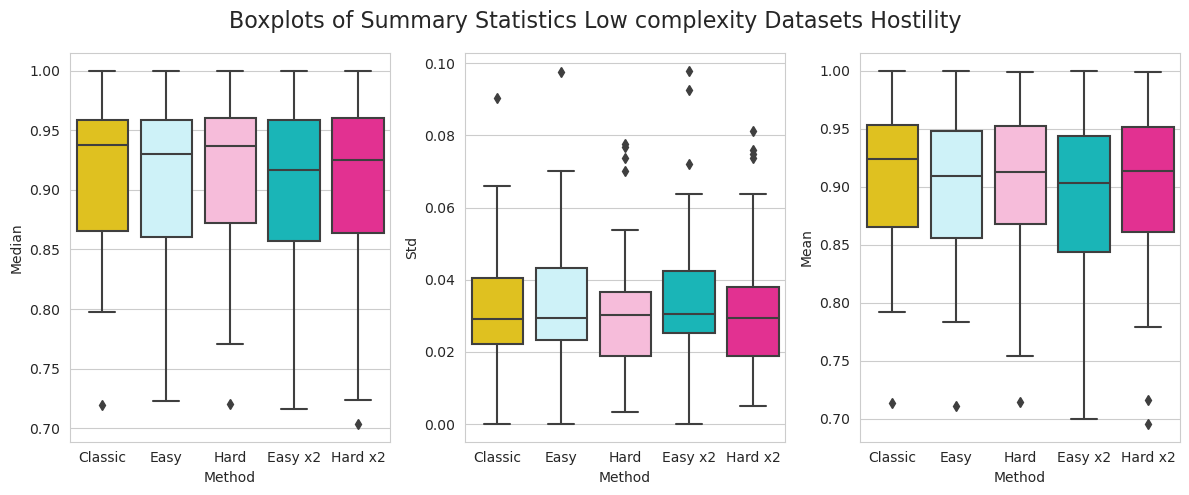

Low complexity datasets: WTL Classic vs sw_easy
   n_ensemble sample_weight_easy_Hostility
0          10                  (7, 11, 15)
1          25                   (9, 6, 18)
2          50                   (8, 7, 18)
3         100                   (8, 9, 16)
4         150                   (8, 8, 17)
5         200                   (7, 7, 19)
6         250                   (7, 7, 19)
7         300                  (10, 8, 15)
Low complexity datasets: WTL Classic vs sw_easy_x2
   n_ensemble sample_weight_easy_x2_Hostility
0          10                     (5, 11, 17)
1          25                      (8, 6, 19)
2          50                      (7, 6, 20)
3         100                      (8, 7, 18)
4         150                      (9, 6, 18)
5         200                      (6, 7, 20)
6         250                      (8, 7, 18)
7         300                      (7, 8, 18)
Low complexity datasets: WTL Classic vs sw_hard
   n_ensemble sample_weight_hard_Hostility
0        

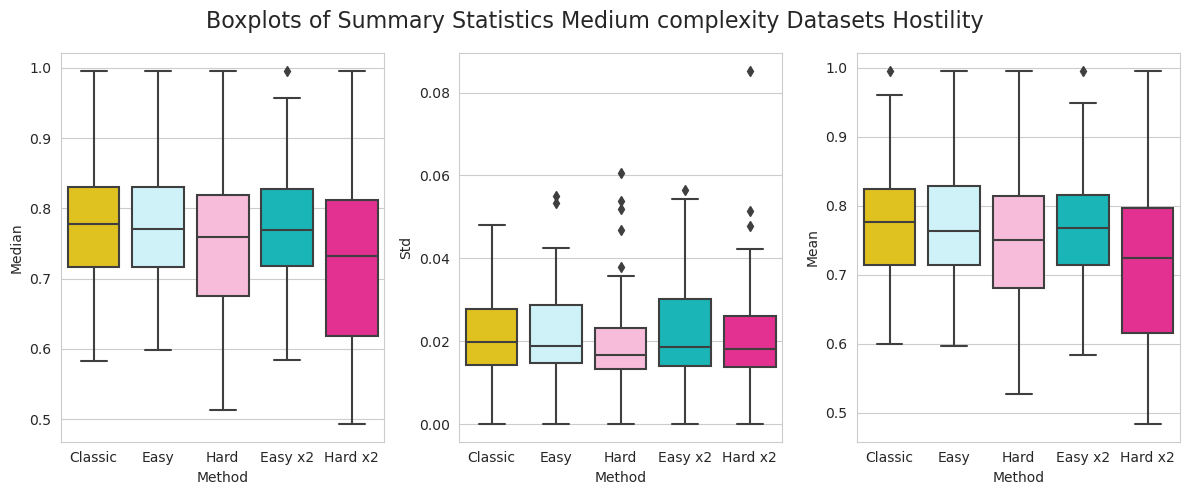

Medium complexity datasets: WTL Classic vs sw_easy
   n_ensemble sample_weight_easy_Hostility
0          10                 (10, 11, 26)
1          25                  (12, 8, 27)
2          50                  (15, 5, 27)
3         100                  (16, 6, 25)
4         150                  (19, 5, 23)
5         200                  (23, 3, 21)
6         250                  (20, 5, 22)
7         300                  (23, 5, 19)
Medium complexity datasets: WTL Classic vs sw_easy_x2
   n_ensemble sample_weight_easy_x2_Hostility
0          10                     (9, 11, 27)
1          25                     (12, 6, 29)
2          50                     (17, 2, 28)
3         100                     (19, 3, 25)
4         150                     (18, 4, 25)
5         200                     (22, 3, 22)
6         250                     (22, 3, 22)
7         300                     (24, 3, 20)
Medium complexity datasets: WTL Classic vs sw_hard
   n_ensemble sample_weight_hard_Hostility


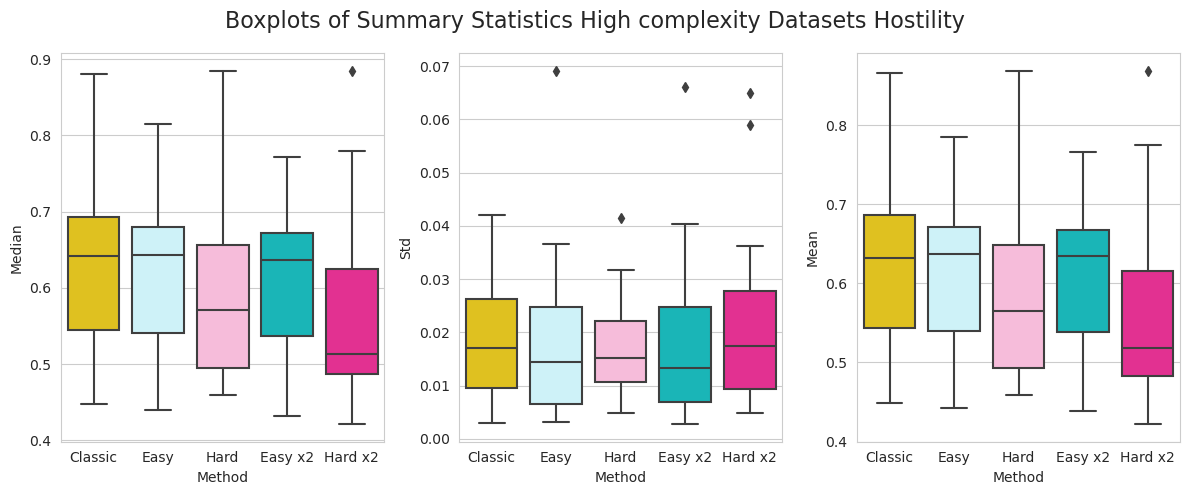

High complexity datasets: WTL Classic vs sw_easy
   n_ensemble sample_weight_easy_Hostility
0          10                  (14, 3, 15)
1          25                  (13, 0, 19)
2          50                  (11, 3, 18)
3         100                  (11, 1, 20)
4         150                  (10, 1, 21)
5         200                  (13, 2, 17)
6         250                  (12, 2, 18)
7         300                  (12, 0, 20)
High complexity datasets: WTL Classic vs sw_easy_x2
   n_ensemble sample_weight_easy_x2_Hostility
0          10                     (12, 3, 17)
1          25                     (13, 0, 19)
2          50                     (13, 0, 19)
3         100                     (15, 3, 14)
4         150                      (9, 1, 22)
5         200                     (11, 0, 21)
6         250                     (11, 1, 20)
7         300                     (13, 0, 19)
High complexity datasets: WTL Classic vs sw_hard
   n_ensemble sample_weight_hard_Hostility
0     

In [14]:
CM = 'Hostility'
loss_function = 'exponential'
summary_pivot_low, summary_pivot_medium, summary_pivot_high, wtl_sw_easy_low, wtl_sw_easy_medium, wtl_sw_easy_high, wtl_sw_easy_x2_low, wtl_sw_easy_x2_medium,wtl_sw_easy_x2_high, wtl_sw_hard_low, wtl_sw_hard_medium, wtl_sw_hard_high, wtl_sw_hard_x2_low, wtl_sw_hard_x2_medium, wtl_sw_hard_x2_high = summary_CM_complexity_dataset(CM,all_datasets,df_complex, loss_function)

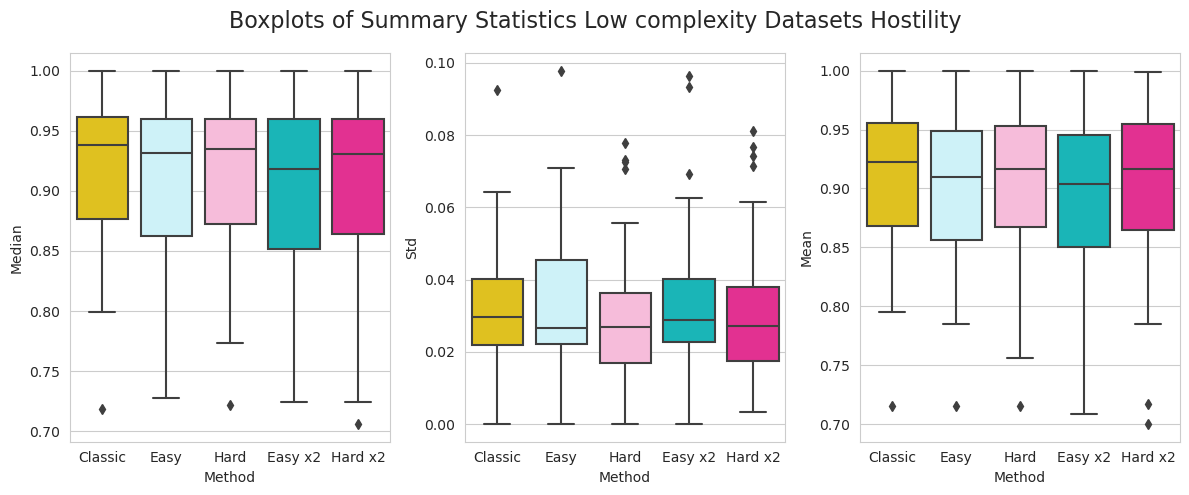

Low complexity datasets: WTL Classic vs sw_easy
   n_ensemble sample_weight_easy_Hostility
0          10                   (9, 9, 15)
1          25                   (7, 8, 18)
2          50                   (8, 6, 19)
3         100                   (8, 6, 19)
4         150                   (8, 7, 18)
5         200                   (8, 7, 18)
6         250                   (8, 7, 18)
7         300                   (8, 8, 17)
Low complexity datasets: WTL Classic vs sw_hard
   n_ensemble sample_weight_hard_Hostility
0          10                  (12, 8, 13)
1          25                   (17, 7, 9)
2          50                  (10, 8, 15)
3         100                   (9, 8, 16)
4         150                  (8, 12, 13)
5         200                   (9, 8, 16)
6         250                   (8, 8, 17)
7         300                   (9, 8, 16)


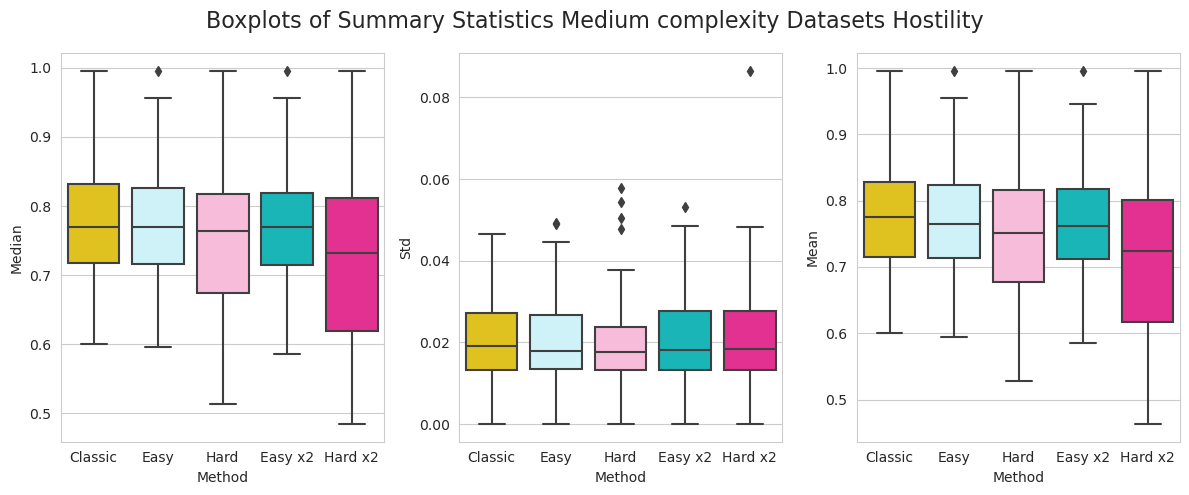

Medium complexity datasets: WTL Classic vs sw_easy
   n_ensemble sample_weight_easy_Hostility
0          10                  (9, 10, 28)
1          25                  (11, 8, 28)
2          50                  (17, 3, 27)
3         100                  (19, 3, 25)
4         150                  (19, 6, 22)
5         200                  (18, 4, 25)
6         250                  (21, 5, 21)
7         300                  (20, 6, 21)
Medium complexity datasets: WTL Classic vs sw_hard
   n_ensemble sample_weight_hard_Hostility
0          10                  (11, 9, 27)
1          25                   (6, 3, 38)
2          50                  (10, 4, 33)
3         100                  (12, 4, 31)
4         150                   (9, 3, 35)
5         200                   (5, 4, 38)
6         250                   (6, 4, 37)
7         300                   (6, 4, 37)


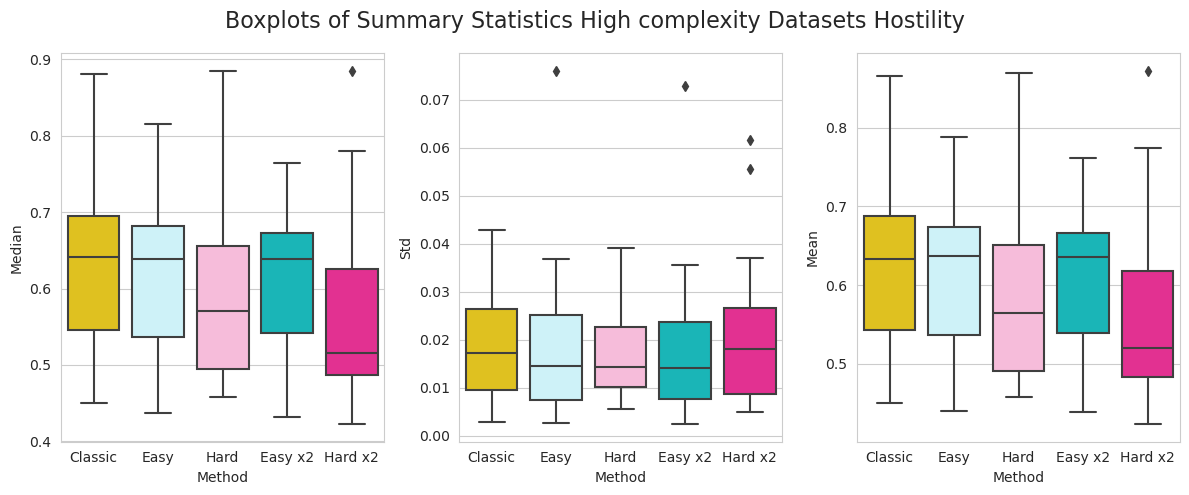

High complexity datasets: WTL Classic vs sw_easy
   n_ensemble sample_weight_easy_Hostility
0          10                  (13, 3, 16)
1          25                  (12, 2, 18)
2          50                  (10, 0, 22)
3         100                  (12, 2, 18)
4         150                  (13, 0, 19)
5         200                  (11, 2, 19)
6         250                  (14, 0, 18)
7         300                  (17, 2, 13)
High complexity datasets: WTL Classic vs sw_hard
   n_ensemble sample_weight_hard_Hostility
0          10                  (11, 1, 20)
1          25                   (8, 0, 24)
2          50                   (7, 1, 24)
3         100                   (3, 0, 29)
4         150                   (6, 1, 25)
5         200                   (5, 0, 27)
6         250                   (6, 1, 25)
7         300                   (7, 0, 25)


In [14]:
CM = 'Hostility'
loss_function = 'log_loss'
summary_pivot_low, summary_pivot_medium, summary_pivot_high, wtl_sw_easy_low, wtl_sw_easy_medium,wtl_sw_easy_high,wtl_sw_hard_low, wtl_sw_hard_medium, wtl_sw_hard_high = summary_CM_complexity_dataset(CM,all_datasets,df_complex, loss_function)

**Hostilidad**

* En conjuntos de datos fáciles (33 según la hostilidad), lo que mejor resultados ofrece es sample_weight_hard. Cercano en mediana al GB clásico y por detrás en media. Std menor para nosotros. En WTL con hard vemos que gana clásica pero en un 40-60.

* En los de dificultad media (47), lo mejor sería Easy pero muy igualado con classic, en WTL vemos que en general gana classic, pero a partir de 150 ensembles ganaríamos nosotros o estaríamos muy en empate con easy. Sigue ganando en general Classic GB.

* En los datasets difíciles (32), nuestra mejor propuesta es Easy (aunque obtiene máximo mayor Hard), sigue ganando classic. En el WTL estamos con easy en un 33-66.

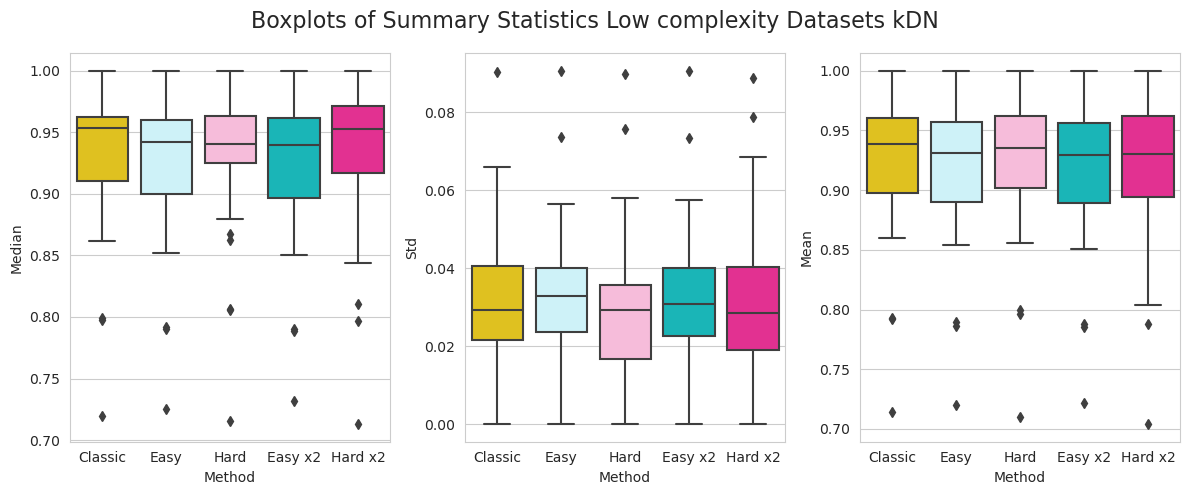

Low complexity datasets: WTL Classic vs sw_easy
   n_ensemble sample_weight_easy_kDN
0          10             (8, 12, 9)
1          25             (6, 8, 15)
2          50             (3, 9, 17)
3         100             (6, 8, 15)
4         150             (5, 9, 15)
5         200            (5, 10, 14)
6         250            (4, 12, 13)
7         300            (6, 11, 12)
Low complexity datasets: WTL Classic vs sw_easy_x2
   n_ensemble sample_weight_easy_x2_kDN
0          10               (7, 11, 11)
1          25                (5, 8, 16)
2          50                (1, 9, 19)
3         100                (7, 8, 14)
4         150                (5, 9, 15)
5         200                (5, 9, 15)
6         250                (6, 9, 14)
7         300               (4, 10, 15)
Low complexity datasets: WTL Classic vs sw_hard
   n_ensemble sample_weight_hard_kDN
0          10            (10, 10, 9)
1          25            (10, 8, 11)
2          50             (15, 8, 6)
3         10

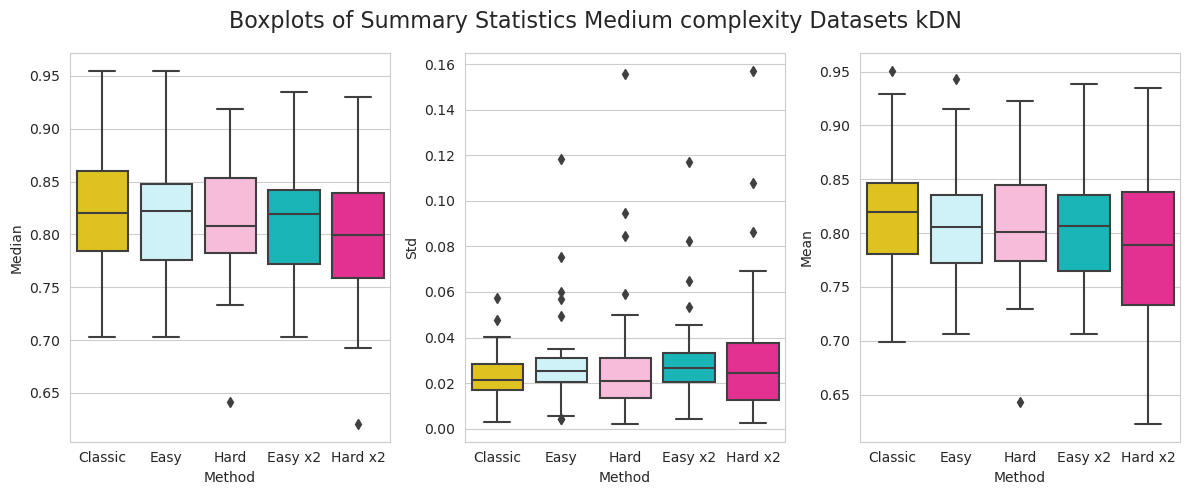

Medium complexity datasets: WTL Classic vs sw_easy
   n_ensemble sample_weight_easy_kDN
0          10            (7, 10, 17)
1          25             (8, 9, 17)
2          50            (13, 3, 18)
3         100            (12, 1, 21)
4         150            (12, 4, 18)
5         200            (15, 4, 15)
6         250            (11, 5, 18)
7         300            (15, 4, 15)
Medium complexity datasets: WTL Classic vs sw_easy_x2
   n_ensemble sample_weight_easy_x2_kDN
0          10                (5, 8, 21)
1          25                (5, 4, 25)
2          50               (15, 2, 17)
3         100               (10, 0, 24)
4         150               (10, 0, 24)
5         200               (15, 3, 16)
6         250               (13, 3, 18)
7         300               (15, 5, 14)
Medium complexity datasets: WTL Classic vs sw_hard
   n_ensemble sample_weight_hard_kDN
0          10             (8, 8, 18)
1          25             (7, 3, 24)
2          50            (12, 3, 19)
3  

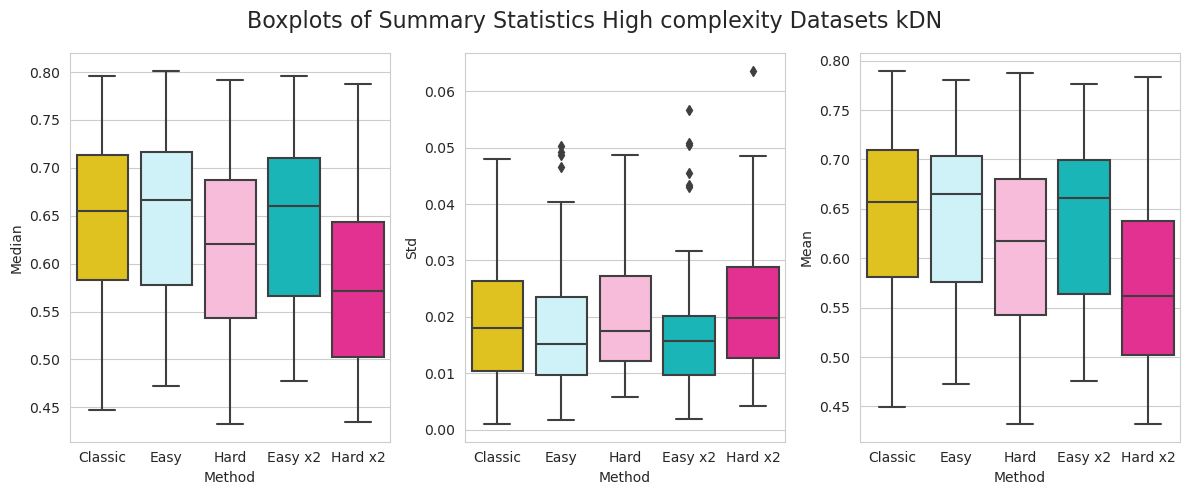

High complexity datasets: WTL Classic vs sw_easy
   n_ensemble sample_weight_easy_kDN
0          10           (20, 10, 19)
1          25            (27, 3, 19)
2          50            (27, 0, 22)
3         100            (26, 4, 19)
4         150            (25, 1, 23)
5         200            (20, 3, 26)
6         250            (22, 4, 23)
7         300            (24, 1, 24)
High complexity datasets: WTL Classic vs sw_easy_x2
   n_ensemble sample_weight_easy_x2_kDN
0          10               (23, 3, 23)
1          25               (24, 1, 24)
2          50               (25, 1, 23)
3         100               (22, 2, 25)
4         150               (27, 2, 20)
5         200               (22, 3, 24)
6         250               (24, 2, 23)
7         300               (24, 0, 25)
High complexity datasets: WTL Classic vs sw_hard
   n_ensemble sample_weight_hard_kDN
0          10            (15, 2, 32)
1          25            (10, 1, 38)
2          50             (9, 2, 38)
3        

In [16]:
CM = 'kDN'
loss_function = 'exponential'
summary_pivot_low, summary_pivot_medium, summary_pivot_high, wtl_sw_easy_low, wtl_sw_easy_medium, wtl_sw_easy_high, wtl_sw_easy_x2_low, wtl_sw_easy_x2_medium,wtl_sw_easy_x2_high, wtl_sw_hard_low, wtl_sw_hard_medium, wtl_sw_hard_high, wtl_sw_hard_x2_low, wtl_sw_hard_x2_medium, wtl_sw_hard_x2_high = summary_CM_complexity_dataset(CM,all_datasets,df_complex, loss_function)

**kDN**

  * En los fáciles (29), lo mejor es Hard x2. En mediana sí que se ve que el boxplot es mejor, en media no. En mediana el boxplot de Hard se ve mejor y en media tb. En WTL ganamos nosotros con Hard en un 55-45 (muy igualado y con mucho empate). Ganamos en 6, empatamos en 1 y perdemos en 1. Con hard x2, ganamos en 6 y perdemos en 2.

 * En los intermedios de dificultad (34), es mejor easy que hard pero gana Classic sin dudas.

 * En los difíciles (49), lo mejor es easy y diría que casi mejor que classic, los boxplots de media y mediana son mejores y el std es más bajo. En WTL ganamos en casi todas las comparaciones (5 de 8, las 5 primeras), en 2 perdemos y en 1 empatamos. Me parece importante que ganamos en las primeras, habría que ver si merece la pena seguir con más ensamblados. Quizás el resultados ya es peor y no compensa seguir.


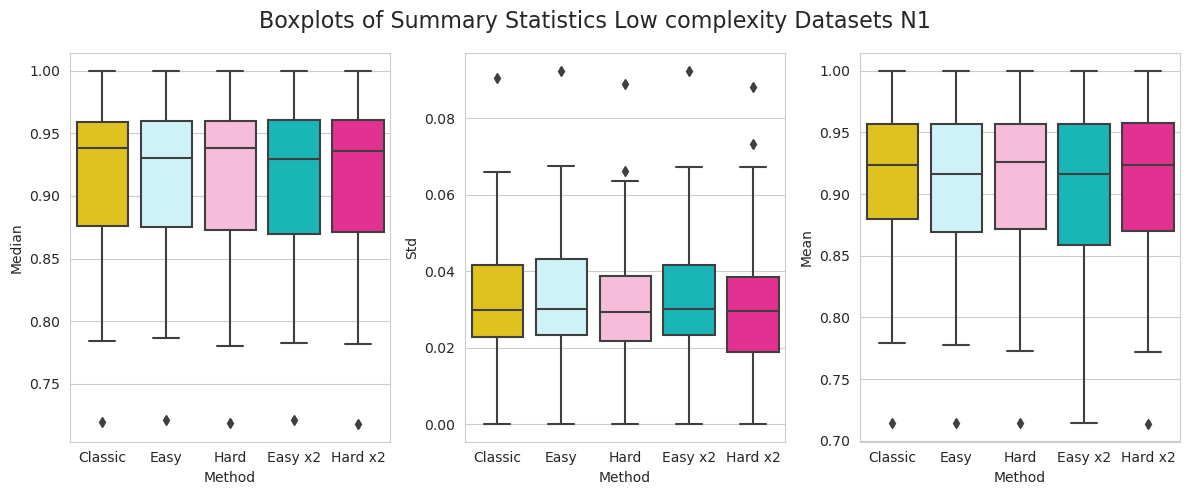

Low complexity datasets: WTL Classic vs sw_easy
   n_ensemble sample_weight_easy_N1
0          10           (9, 14, 12)
1          25            (9, 9, 17)
2          50           (4, 10, 21)
3         100           (6, 10, 19)
4         150           (11, 9, 15)
5         200           (10, 9, 16)
6         250           (9, 11, 15)
7         300           (6, 11, 18)
Low complexity datasets: WTL Classic vs sw_easy_x2
   n_ensemble sample_weight_easy_x2_N1
0          10              (8, 15, 12)
1          25               (8, 9, 18)
2          50              (3, 13, 19)
3         100               (8, 8, 19)
4         150              (11, 9, 15)
5         200              (7, 10, 18)
6         250               (8, 9, 18)
7         300              (4, 10, 21)
Low complexity datasets: WTL Classic vs sw_hard
   n_ensemble sample_weight_hard_N1
0          10           (8, 13, 14)
1          25           (19, 10, 6)
2          50           (16, 9, 10)
3         100          (13, 10, 12

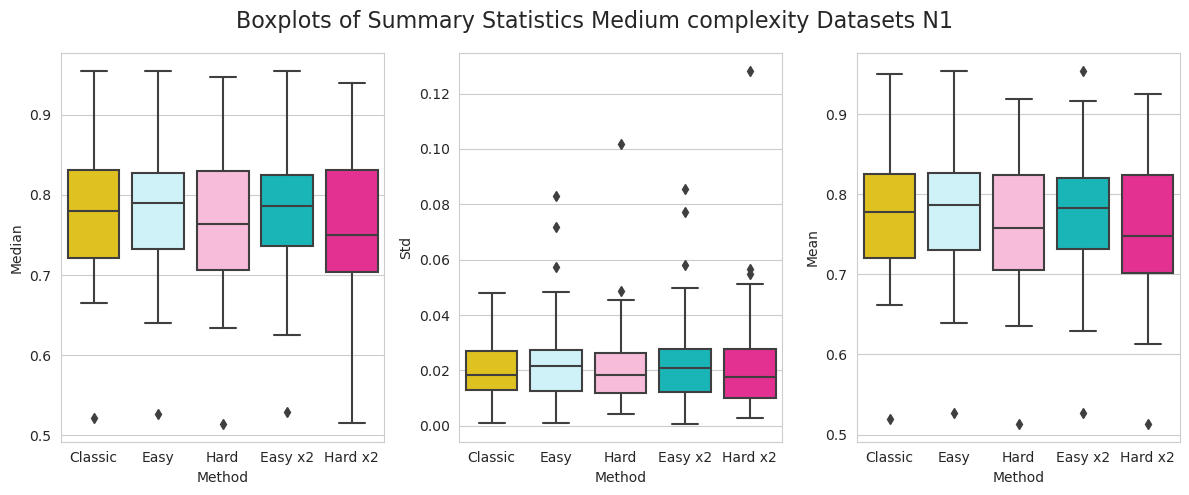

Medium complexity datasets: WTL Classic vs sw_easy
   n_ensemble sample_weight_easy_N1
0          10          (10, 15, 19)
1          25           (16, 5, 23)
2          50           (24, 2, 18)
3         100           (24, 3, 17)
4         150           (21, 4, 19)
5         200           (24, 4, 16)
6         250           (25, 4, 15)
7         300           (23, 5, 16)
Medium complexity datasets: WTL Classic vs sw_easy_x2
   n_ensemble sample_weight_easy_x2_N1
0          10              (7, 13, 24)
1          25              (15, 4, 25)
2          50              (22, 0, 22)
3         100              (23, 3, 18)
4         150              (18, 5, 21)
5         200              (21, 3, 20)
6         250              (19, 5, 20)
7         300              (24, 4, 16)
Medium complexity datasets: WTL Classic vs sw_hard
   n_ensemble sample_weight_hard_N1
0          10          (14, 12, 18)
1          25           (14, 7, 23)
2          50           (17, 4, 23)
3         100           (

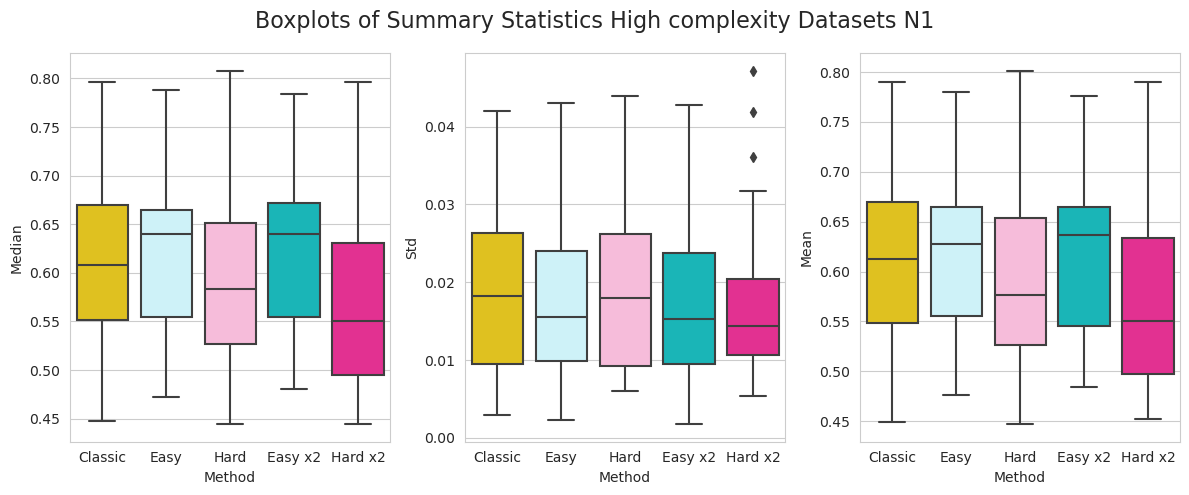

High complexity datasets: WTL Classic vs sw_easy
   n_ensemble sample_weight_easy_N1
0          10           (17, 4, 12)
1          25           (16, 1, 16)
2          50            (9, 1, 23)
3         100           (21, 1, 11)
4         150           (16, 2, 15)
5         200           (16, 5, 12)
6         250           (20, 2, 11)
7         300           (19, 4, 10)
High complexity datasets: WTL Classic vs sw_easy_x2
   n_ensemble sample_weight_easy_x2_N1
0          10              (16, 4, 13)
1          25              (15, 2, 16)
2          50              (15, 0, 18)
3         100              (18, 0, 15)
4         150              (16, 0, 17)
5         200              (15, 0, 18)
6         250              (13, 2, 18)
7         300              (17, 3, 13)
High complexity datasets: WTL Classic vs sw_hard
   n_ensemble sample_weight_hard_N1
0          10           (12, 1, 20)
1          25           (11, 1, 21)
2          50            (9, 1, 23)
3         100            (7, 1,

In [17]:
CM = 'N1'
loss_function = 'exponential'
summary_pivot_low, summary_pivot_medium, summary_pivot_high, wtl_sw_easy_low, wtl_sw_easy_medium, wtl_sw_easy_high, wtl_sw_easy_x2_low, wtl_sw_easy_x2_medium,wtl_sw_easy_x2_high, wtl_sw_hard_low, wtl_sw_hard_medium, wtl_sw_hard_high, wtl_sw_hard_x2_low, wtl_sw_hard_x2_medium, wtl_sw_hard_x2_high = summary_CM_complexity_dataset(CM,all_datasets,df_complex, loss_function)

**N1**

 * En los conjuntos de datos fáciles (35), está todo muy igualado, diría que lo mejor nuestro es hard. En WTL ganamos en 4 de 8, empatamos en 1 y perdemos en 3 (la primera y las 2 últimas).

 * En los conjuntos intermedios (44), lo mejor es easy y easy x2. En WTL easy gana en 6 de 8 (pierde las 2 primeras). Easy x2 gana en 3, pierde en 4 y empata en 1. Es mejor easy.

 * En los datos difíciles (33), lo mejor es easy y dudo si easy o easy x2. Ambos boxplot son mejores que classic en media, mediana y std. En WTL, easy gana en 6, empata en 1 y pierde en 1 (el tercero, 50 ensamblados). Easy x2 gana en 3 y pierde en 5. Es mejor easy.  Sería interesante ver si somos más estables. Desde luego damos menor std en los boxplots.

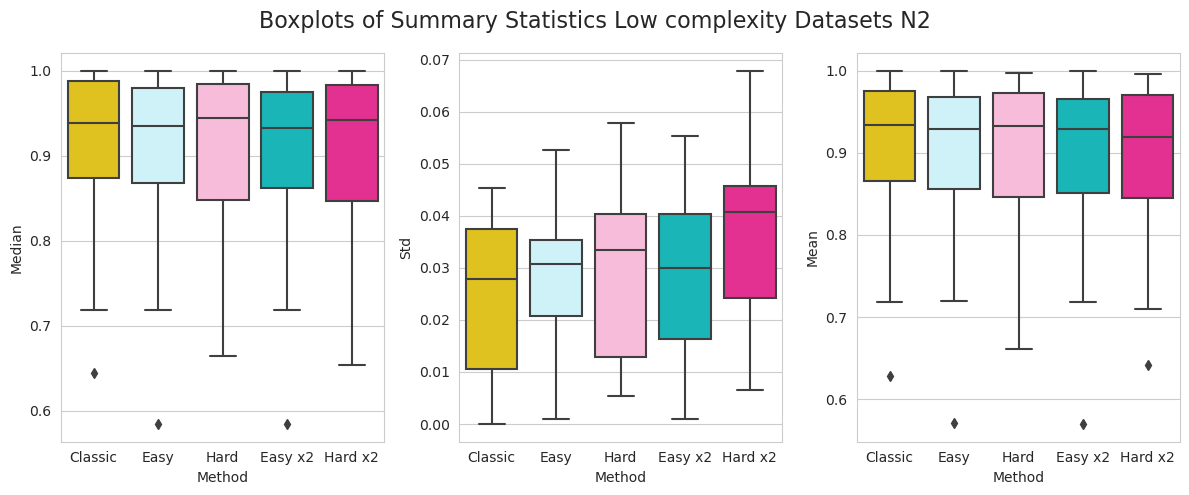

Low complexity datasets: WTL Classic vs sw_easy
   n_ensemble sample_weight_easy_N2
0          10             (2, 5, 4)
1          25             (2, 4, 5)
2          50             (2, 4, 5)
3         100             (1, 3, 7)
4         150             (0, 4, 7)
5         200             (1, 2, 8)
6         250             (1, 3, 7)
7         300             (2, 3, 6)
Low complexity datasets: WTL Classic vs sw_easy_x2
   n_ensemble sample_weight_easy_x2_N2
0          10                (2, 4, 5)
1          25                (2, 3, 6)
2          50                (1, 4, 6)
3         100                (1, 4, 6)
4         150                (0, 4, 7)
5         200                (0, 3, 8)
6         250                (1, 2, 8)
7         300                (2, 2, 7)
Low complexity datasets: WTL Classic vs sw_hard
   n_ensemble sample_weight_hard_N2
0          10             (3, 5, 3)
1          25             (6, 4, 1)
2          50             (4, 3, 4)
3         100             (4, 4, 3

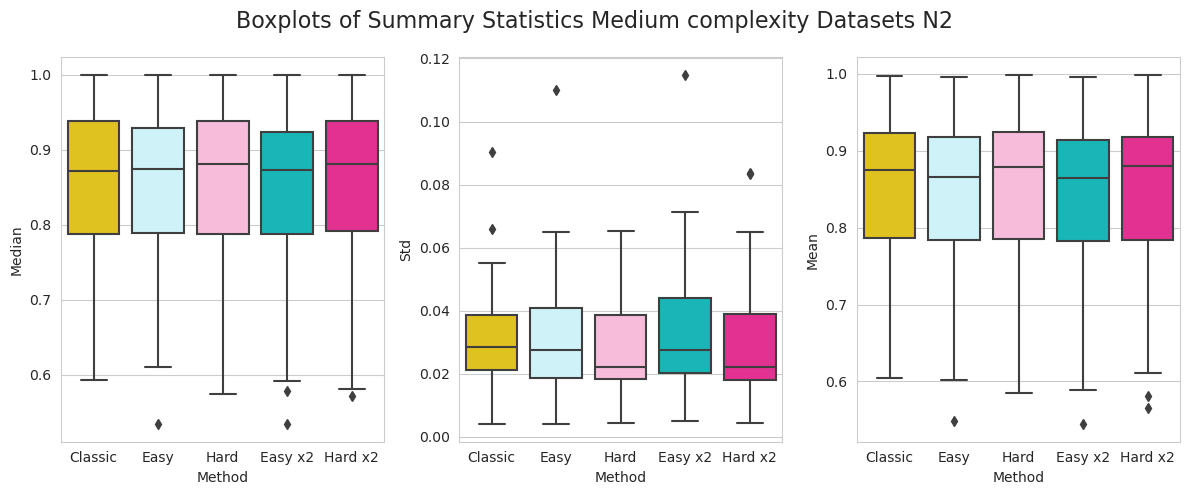

Medium complexity datasets: WTL Classic vs sw_easy
   n_ensemble sample_weight_easy_N2
0          10            (6, 9, 11)
1          25            (6, 5, 15)
2          50            (3, 4, 19)
3         100            (5, 6, 15)
4         150            (5, 5, 16)
5         200            (7, 5, 14)
6         250            (7, 6, 13)
7         300            (6, 5, 15)
Medium complexity datasets: WTL Classic vs sw_easy_x2
   n_ensemble sample_weight_easy_x2_N2
0          10               (7, 8, 11)
1          25               (3, 6, 17)
2          50               (3, 5, 18)
3         100               (4, 4, 18)
4         150               (4, 4, 18)
5         200               (5, 4, 17)
6         250               (7, 5, 14)
7         300               (5, 5, 16)
Medium complexity datasets: WTL Classic vs sw_hard
   n_ensemble sample_weight_hard_N2
0          10           (10, 6, 10)
1          25           (10, 6, 10)
2          50            (12, 6, 8)
3         100           (

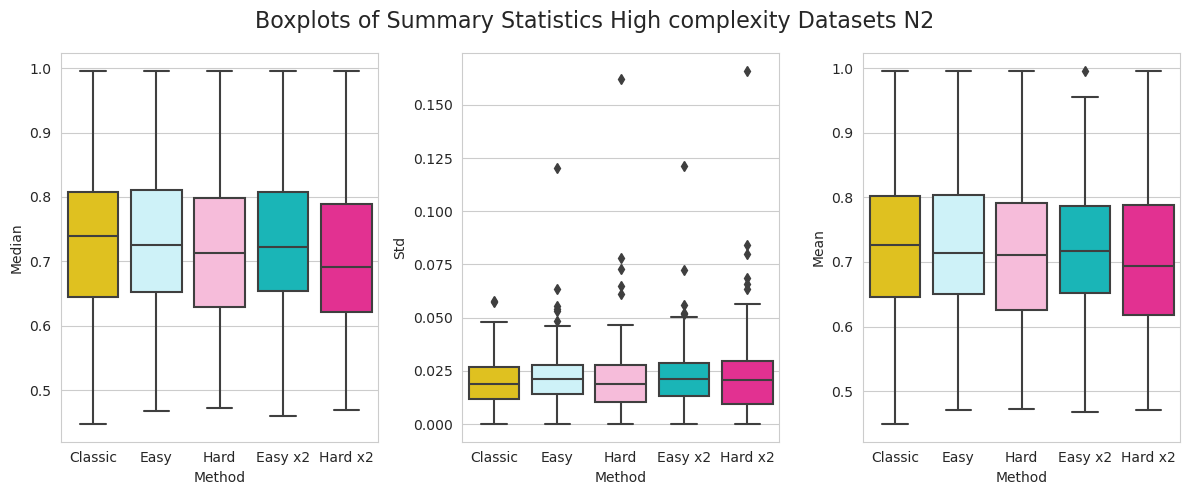

High complexity datasets: WTL Classic vs sw_easy
   n_ensemble sample_weight_easy_N2
0          10          (22, 13, 40)
1          25           (26, 8, 41)
2          50           (34, 5, 36)
3         100           (36, 6, 33)
4         150           (30, 6, 39)
5         200           (40, 4, 31)
6         250           (34, 8, 33)
7         300           (31, 8, 36)
High complexity datasets: WTL Classic vs sw_easy_x2
   n_ensemble sample_weight_easy_x2_N2
0          10             (25, 11, 39)
1          25              (31, 4, 40)
2          50              (31, 5, 39)
3         100              (27, 9, 39)
4         150              (28, 6, 41)
5         200              (34, 6, 35)
6         250              (32, 7, 36)
7         300              (33, 6, 36)
High complexity datasets: WTL Classic vs sw_hard
   n_ensemble sample_weight_hard_N2
0          10          (23, 10, 42)
1          25           (21, 7, 47)
2          50           (25, 7, 43)
3         100           (19, 4,

In [18]:
CM = 'N2'
loss_function = 'exponential'
summary_pivot_low, summary_pivot_medium, summary_pivot_high, wtl_sw_easy_low, wtl_sw_easy_medium, wtl_sw_easy_high, wtl_sw_easy_x2_low, wtl_sw_easy_x2_medium,wtl_sw_easy_x2_high, wtl_sw_hard_low, wtl_sw_hard_medium, wtl_sw_hard_high, wtl_sw_hard_x2_low, wtl_sw_hard_x2_medium, wtl_sw_hard_x2_high = summary_CM_complexity_dataset(CM,all_datasets,df_complex, loss_function)

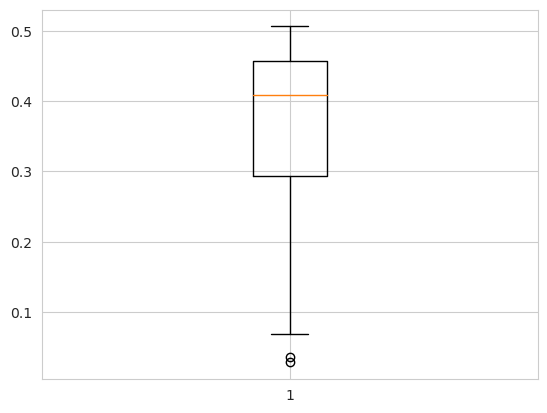

In [29]:
plt.boxplot(df_complex.N2)
plt.show()
# Rango muy concentrado entre 0.3 y 0.5

**N2**

Aquí ya vemos que la categorización de los datos se complica porque en fáciles solo hay 11.

 * En los conjuntos de datos fáciles (11),  diría que el ganador es classic GB pero vamos que es que son muy pocos datasets.

 * En los intermedios (26), parece que lo mejor para nosotros es Hard. En WTL, ganamos 3, empatamos 3 y perdemos 2. Con Hard x2, ganamos en 2, empatamos en 1 y perdemos en 5. Si aquí nuestra mejor baza es Hard, lo que me indica es que esta categoría intermedia realmente es “difícil”.

 * En los difíciles (75), aquí lo mejor para nosotros es easy. En mediana es mejor easy x2 y en media parece que easy. En WTL con easy, ganamos en 3 y perdemos en 5, o sea que es mejor Classic. Con easy x2, perdemos en todos. Habría que revisar la categorización.


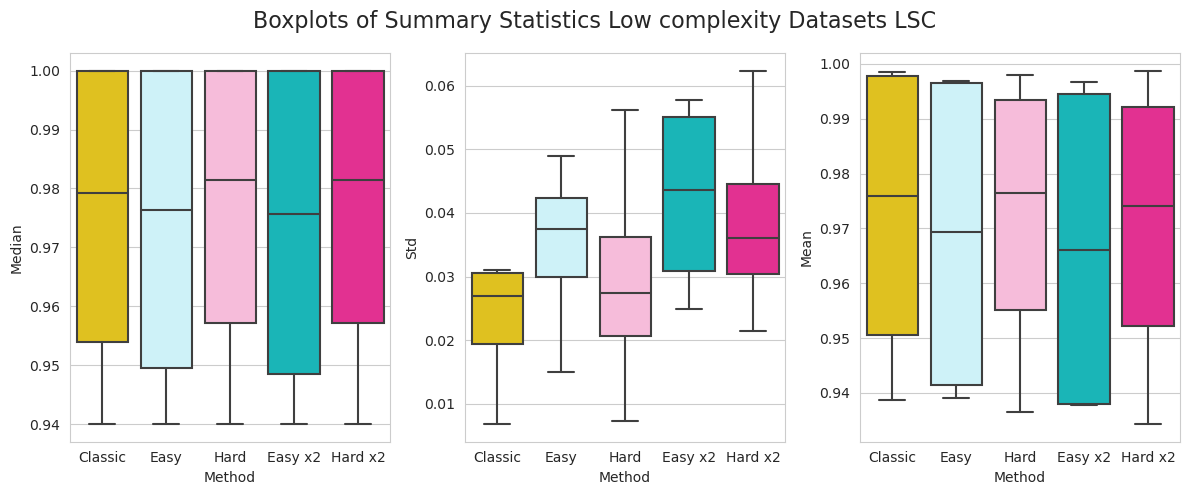

Low complexity datasets: WTL Classic vs sw_easy
   n_ensemble sample_weight_easy_LSC
0          10              (0, 3, 1)
1          25              (0, 3, 1)
2          50              (0, 3, 1)
3         100              (0, 3, 1)
4         150              (0, 3, 1)
5         200              (0, 3, 1)
6         250              (0, 3, 1)
7         300              (0, 3, 1)
Low complexity datasets: WTL Classic vs sw_easy_x2
   n_ensemble sample_weight_easy_x2_LSC
0          10                 (0, 3, 1)
1          25                 (0, 3, 1)
2          50                 (0, 3, 1)
3         100                 (0, 3, 1)
4         150                 (0, 3, 1)
5         200                 (0, 3, 1)
6         250                 (0, 3, 1)
7         300                 (0, 3, 1)
Low complexity datasets: WTL Classic vs sw_hard
   n_ensemble sample_weight_hard_LSC
0          10              (1, 3, 0)
1          25              (1, 3, 0)
2          50              (1, 3, 0)
3         10

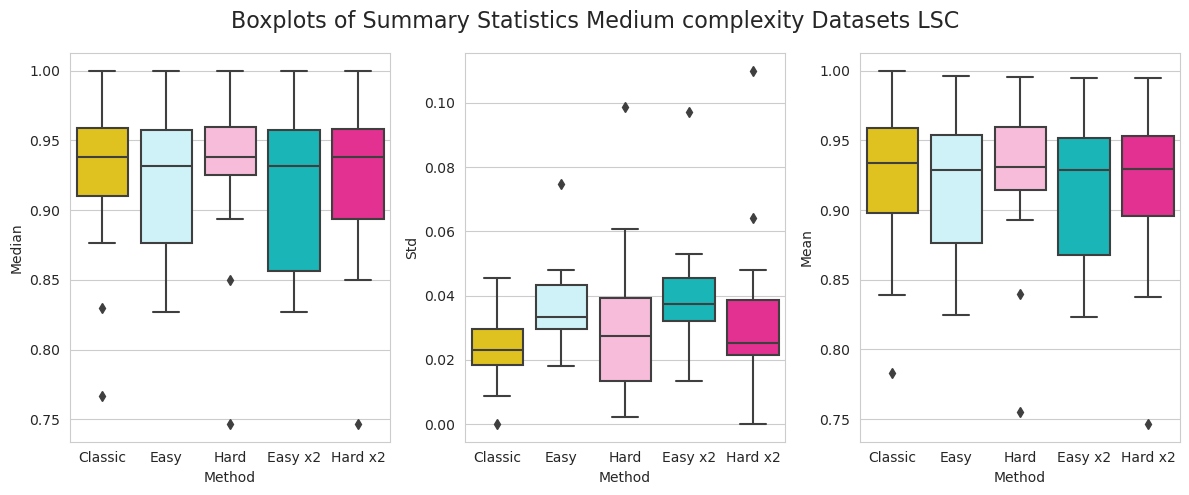

Medium complexity datasets: WTL Classic vs sw_easy
   n_ensemble sample_weight_easy_LSC
0          10              (3, 6, 4)
1          25              (1, 7, 5)
2          50              (4, 4, 5)
3         100              (2, 5, 6)
4         150              (2, 4, 7)
5         200              (3, 6, 4)
6         250              (4, 6, 3)
7         300              (5, 5, 3)
Medium complexity datasets: WTL Classic vs sw_easy_x2
   n_ensemble sample_weight_easy_x2_LSC
0          10                 (3, 6, 4)
1          25                 (3, 4, 6)
2          50                 (2, 3, 8)
3         100                 (2, 4, 7)
4         150                 (2, 4, 7)
5         200                 (2, 4, 7)
6         250                 (4, 4, 5)
7         300                 (3, 5, 5)
Medium complexity datasets: WTL Classic vs sw_hard
   n_ensemble sample_weight_hard_LSC
0          10              (2, 4, 7)
1          25              (6, 5, 2)
2          50              (3, 7, 3)
3  

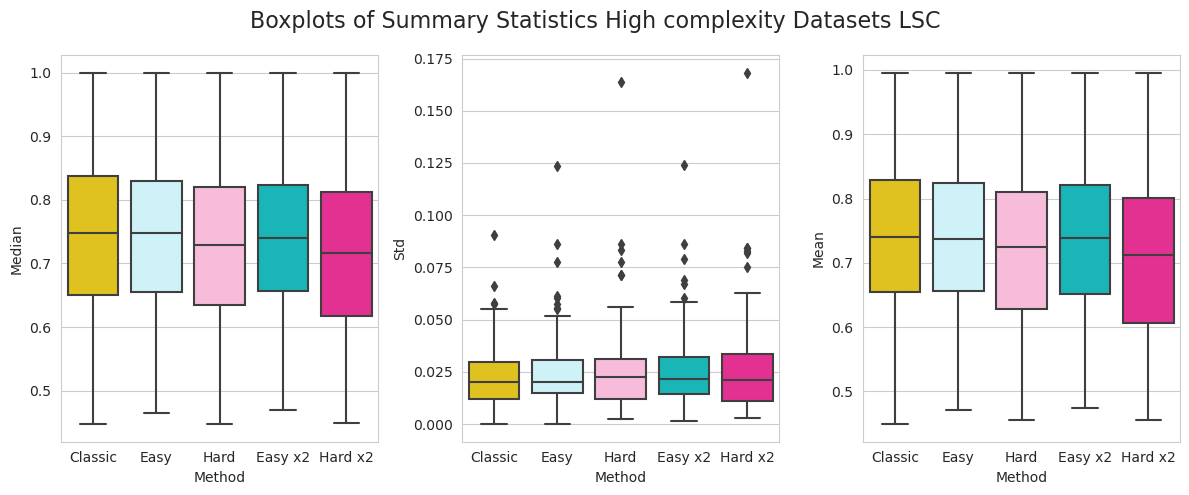

High complexity datasets: WTL Classic vs sw_easy
   n_ensemble sample_weight_easy_LSC
0          10           (36, 17, 42)
1          25           (37, 10, 48)
2          50            (37, 5, 53)
3         100            (39, 5, 51)
4         150            (37, 8, 50)
5         200            (40, 6, 49)
6         250           (39, 11, 45)
7         300            (41, 7, 47)
High complexity datasets: WTL Classic vs sw_easy_x2
   n_ensemble sample_weight_easy_x2_LSC
0          10              (34, 11, 50)
1          25               (40, 9, 46)
2          50               (35, 5, 55)
3         100               (33, 2, 60)
4         150               (33, 8, 54)
5         200               (38, 3, 54)
6         250               (40, 7, 48)
7         300               (37, 7, 51)
High complexity datasets: WTL Classic vs sw_hard
   n_ensemble sample_weight_hard_LSC
0          10           (29, 19, 47)
1          25            (28, 5, 62)
2          50            (28, 5, 62)
3        

In [19]:
CM = 'LSC'
loss_function = 'exponential'
summary_pivot_low, summary_pivot_medium, summary_pivot_high, wtl_sw_easy_low, wtl_sw_easy_medium, wtl_sw_easy_high, wtl_sw_easy_x2_low, wtl_sw_easy_x2_medium,wtl_sw_easy_x2_high, wtl_sw_hard_low, wtl_sw_hard_medium, wtl_sw_hard_high, wtl_sw_hard_x2_low, wtl_sw_hard_x2_medium, wtl_sw_hard_x2_high = summary_CM_complexity_dataset(CM,all_datasets,df_complex, loss_function)

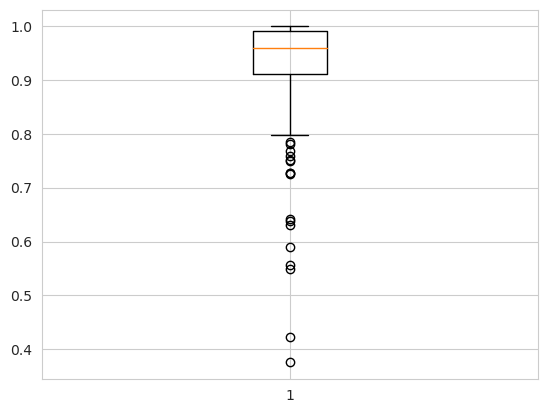

In [25]:
plt.boxplot(df_complex.LSC)
plt.show()

**LSC**

La categorización cada vez peor: low (4), intermediate (13), high (95).

No lo analizamos porque realmente la categorización no hace nada. Gana classic en los difíciles (que es como ganar en todo realmente). En estas medidas de complejidad difíciles de interpretar, no sé cómo realizar la categorización porque realmente todos los valores están en torno al 0.9.

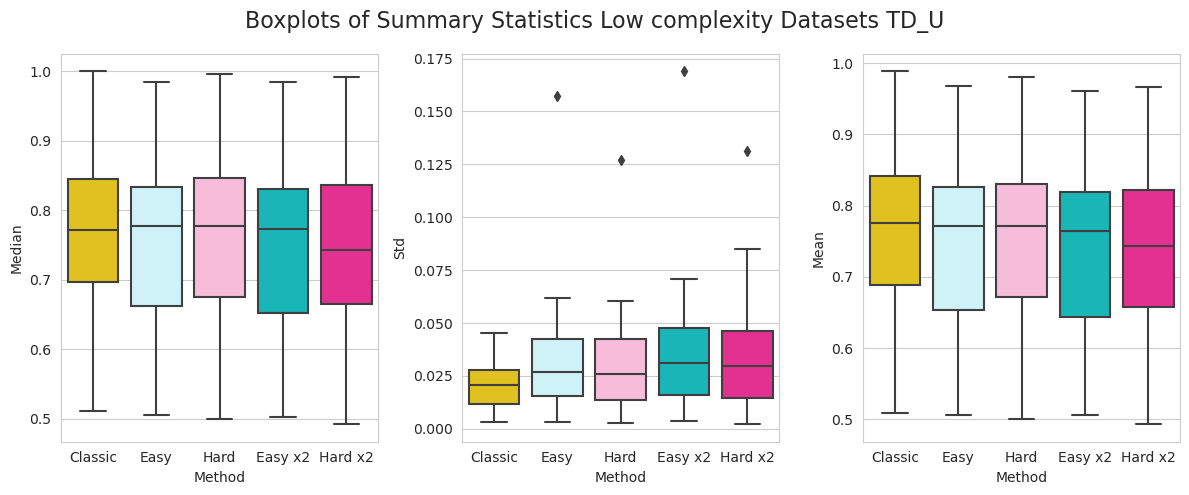

Low complexity datasets: WTL Classic vs sw_easy
   n_ensemble sample_weight_easy_TD_U
0          10              (9, 9, 20)
1          25              (9, 1, 28)
2          50              (9, 3, 26)
3         100             (10, 2, 26)
4         150             (11, 0, 27)
5         200             (11, 2, 25)
6         250             (13, 1, 24)
7         300             (12, 2, 24)
Low complexity datasets: WTL Classic vs sw_easy_x2
   n_ensemble sample_weight_easy_x2_TD_U
0          10                 (6, 8, 24)
1          25                (10, 1, 27)
2          50                 (6, 3, 29)
3         100                 (9, 1, 28)
4         150                 (8, 0, 30)
5         200                (11, 0, 27)
6         250                (10, 3, 25)
7         300                 (5, 2, 31)
Low complexity datasets: WTL Classic vs sw_hard
   n_ensemble sample_weight_hard_TD_U
0          10             (12, 5, 21)
1          25             (12, 0, 26)
2          50              (

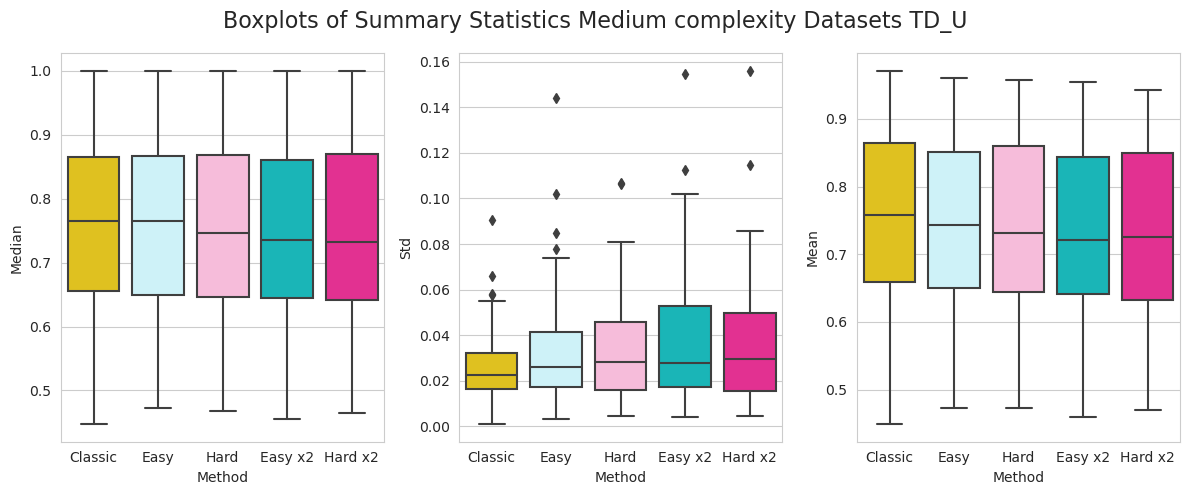

Medium complexity datasets: WTL Classic vs sw_easy
   n_ensemble sample_weight_easy_TD_U
0          10            (12, 15, 40)
1          25             (16, 6, 45)
2          50             (21, 4, 42)
3         100             (19, 6, 42)
4         150             (16, 8, 43)
5         200             (21, 7, 39)
6         250             (18, 8, 41)
7         300             (20, 8, 39)
Medium complexity datasets: WTL Classic vs sw_easy_x2
   n_ensemble sample_weight_easy_x2_TD_U
0          10               (11, 14, 42)
1          25                (13, 5, 49)
2          50                (14, 4, 49)
3         100                (14, 8, 45)
4         150                (20, 6, 41)
5         200                (15, 5, 47)
6         250                (15, 5, 47)
7         300                (21, 5, 41)
Medium complexity datasets: WTL Classic vs sw_hard
   n_ensemble sample_weight_hard_TD_U
0          10             (22, 4, 41)
1          25             (15, 6, 46)
2          50      

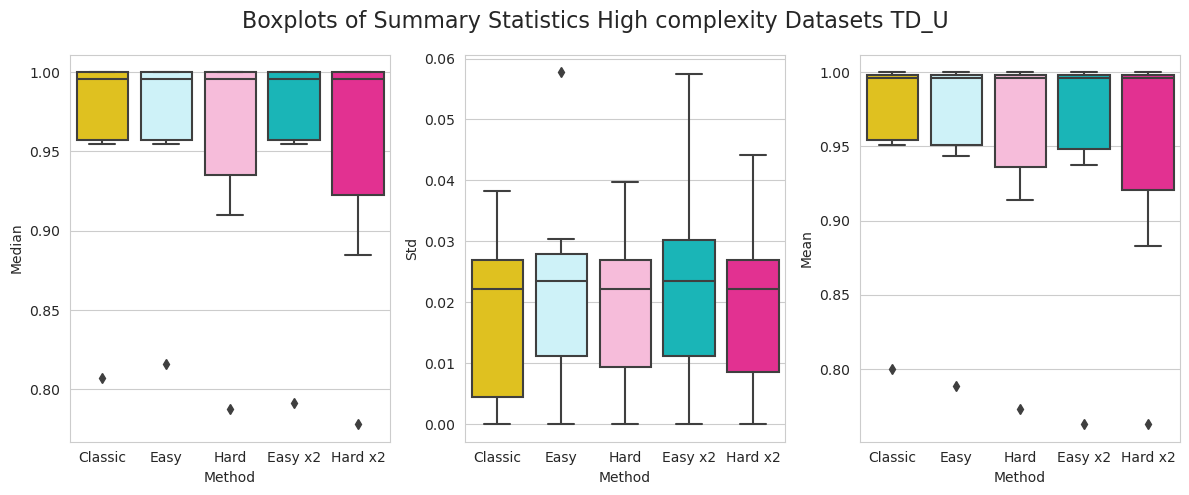

High complexity datasets: WTL Classic vs sw_easy
   n_ensemble sample_weight_easy_TD_U
0          10               (0, 6, 1)
1          25               (0, 5, 2)
2          50               (0, 5, 2)
3         100               (0, 6, 1)
4         150               (1, 6, 0)
5         200               (0, 6, 1)
6         250               (0, 6, 1)
7         300               (0, 7, 0)
High complexity datasets: WTL Classic vs sw_easy_x2
   n_ensemble sample_weight_easy_x2_TD_U
0          10                  (0, 5, 2)
1          25                  (0, 5, 2)
2          50                  (0, 5, 2)
3         100                  (0, 5, 2)
4         150                  (0, 6, 1)
5         200                  (0, 6, 1)
6         250                  (0, 6, 1)
7         300                  (0, 6, 1)
High complexity datasets: WTL Classic vs sw_hard
   n_ensemble sample_weight_hard_TD_U
0          10               (0, 5, 2)
1          25               (0, 5, 2)
2          50            

In [20]:
CM = 'TD_U'
loss_function = 'exponential'
summary_pivot_low, summary_pivot_medium, summary_pivot_high, wtl_sw_easy_low, wtl_sw_easy_medium, wtl_sw_easy_high, wtl_sw_easy_x2_low, wtl_sw_easy_x2_medium,wtl_sw_easy_x2_high, wtl_sw_hard_low, wtl_sw_hard_medium, wtl_sw_hard_high, wtl_sw_hard_x2_low, wtl_sw_hard_x2_medium, wtl_sw_hard_x2_high = summary_CM_complexity_dataset(CM,all_datasets,df_complex, loss_function)

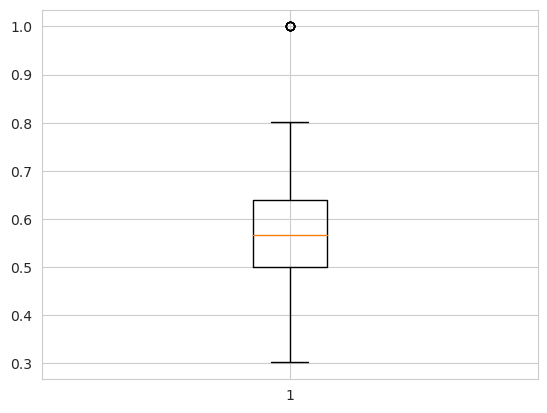

In [26]:
plt.boxplot(df_complex.TD_U)
plt.show()
# Su rango está muy concentrado en valores intermedios

**TDU**

La categorización tampoco está bien porque hay muy pocos difíciles y muchos intermedios.

 * Datos fáciles (38), lo mejor es hard, pero claramente gana classic.

 * Datos intermedios (67), lo veo muy igualado entre hard y easy. Claramente gana Classic.

 * Datos difíciles (7).

Aquí tiene sentido que gane classic con mayor claridad dado que TDU se basa en árboles, entonces la información de complejidad que pueda añadir al GB no es novedosa dado que se basan en el mismo algoritmo.

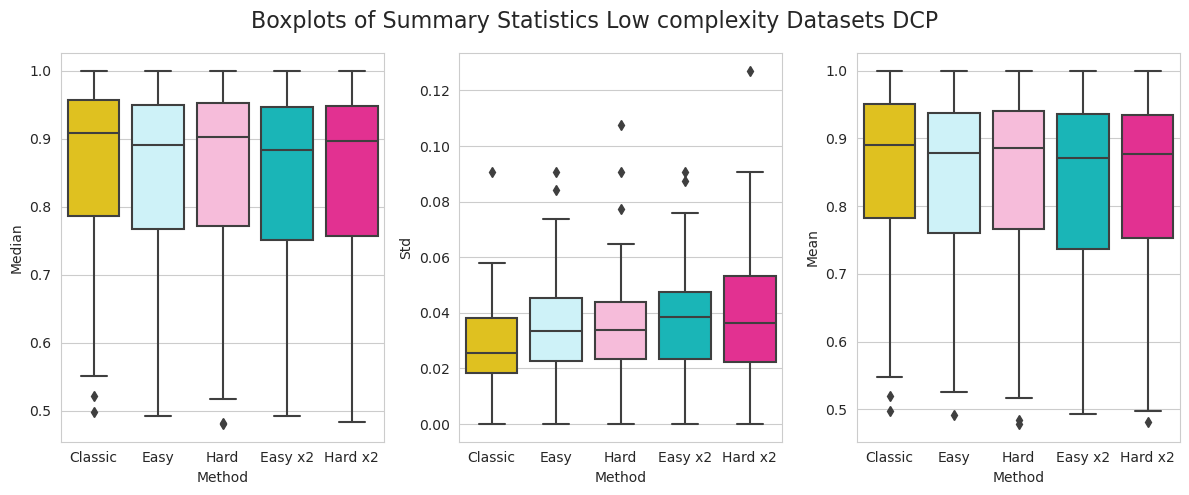

Low complexity datasets: WTL Classic vs sw_easy
   n_ensemble sample_weight_easy_DCP
0          10            (6, 11, 31)
1          25            (6, 13, 29)
2          50            (5, 14, 29)
3         100            (8, 12, 28)
4         150            (9, 12, 27)
5         200           (10, 13, 25)
6         250           (10, 14, 24)
7         300            (9, 14, 25)
Low complexity datasets: WTL Classic vs sw_easy_x2
   n_ensemble sample_weight_easy_x2_DCP
0          10               (6, 10, 32)
1          25               (6, 12, 30)
2          50               (3, 11, 34)
3         100                (8, 9, 31)
4         150               (9, 10, 29)
5         200              (10, 12, 26)
6         250              (11, 12, 25)
7         300              (12, 11, 25)
Low complexity datasets: WTL Classic vs sw_hard
   n_ensemble sample_weight_hard_DCP
0          10            (9, 10, 29)
1          25            (9, 12, 27)
2          50            (6, 13, 29)
3         10

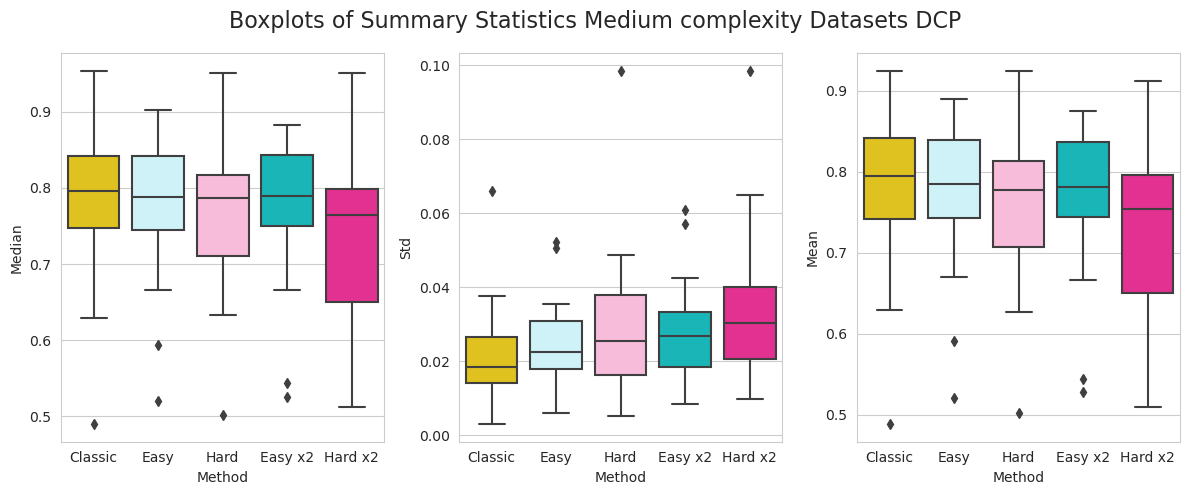

Medium complexity datasets: WTL Classic vs sw_easy
   n_ensemble sample_weight_easy_DCP
0          10             (3, 8, 17)
1          25             (7, 3, 18)
2          50             (7, 2, 19)
3         100             (8, 0, 20)
4         150             (7, 2, 19)
5         200             (8, 1, 19)
6         250            (11, 1, 16)
7         300            (12, 1, 15)
Medium complexity datasets: WTL Classic vs sw_easy_x2
   n_ensemble sample_weight_easy_x2_DCP
0          10                (3, 8, 17)
1          25                (6, 3, 19)
2          50                (7, 0, 21)
3         100                (9, 0, 19)
4         150                (7, 0, 21)
5         200                (8, 0, 20)
6         250                (8, 1, 19)
7         300                (9, 1, 18)
Medium complexity datasets: WTL Classic vs sw_hard
   n_ensemble sample_weight_hard_DCP
0          10             (8, 0, 20)
1          25             (7, 0, 21)
2          50             (9, 1, 18)
3  

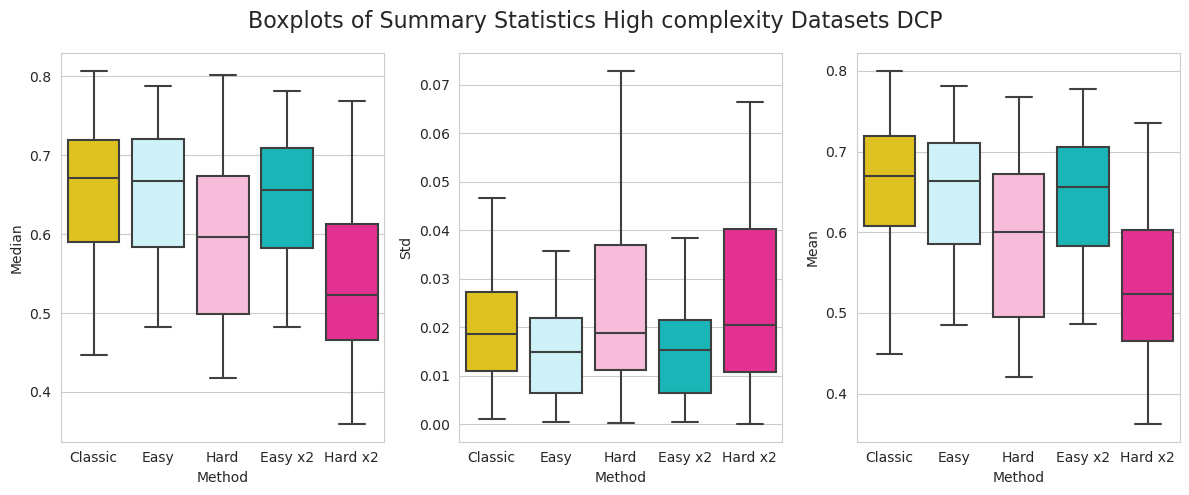

High complexity datasets: WTL Classic vs sw_easy
   n_ensemble sample_weight_easy_DCP
0          10            (12, 7, 17)
1          25             (8, 5, 23)
2          50            (11, 1, 24)
3         100            (11, 2, 23)
4         150            (10, 0, 26)
5         200            (12, 2, 22)
6         250            (11, 2, 23)
7         300            (14, 2, 20)
High complexity datasets: WTL Classic vs sw_easy_x2
   n_ensemble sample_weight_easy_x2_DCP
0          10               (13, 6, 17)
1          25                (8, 3, 25)
2          50                (9, 1, 26)
3         100               (13, 1, 22)
4         150               (11, 0, 25)
5         200               (14, 1, 21)
6         250               (11, 1, 24)
7         300               (12, 1, 23)
High complexity datasets: WTL Classic vs sw_hard
   n_ensemble sample_weight_hard_DCP
0          10             (8, 2, 26)
1          25             (3, 0, 33)
2          50             (4, 0, 32)
3        

In [21]:
CM = 'DCP'
loss_function = 'exponential'
summary_pivot_low, summary_pivot_medium, summary_pivot_high, wtl_sw_easy_low, wtl_sw_easy_medium, wtl_sw_easy_high, wtl_sw_easy_x2_low, wtl_sw_easy_x2_medium,wtl_sw_easy_x2_high, wtl_sw_hard_low, wtl_sw_hard_medium, wtl_sw_hard_high, wtl_sw_hard_x2_low, wtl_sw_hard_x2_medium, wtl_sw_hard_x2_high = summary_CM_complexity_dataset(CM,all_datasets,df_complex, loss_function)

**DCP**

 * Datos fáciles (48), lo mejor nuestro es hard, pero gana claramente classic GB.

 * Datos intermedios (28), lo mejor es easy y diría que easy x2. En WTL claramente perdemos en ambos casos.

 * Datos difíciles (36), lo mejor es easy pero muy igualado con classic GB. En WTL, claramente gana classic GB.

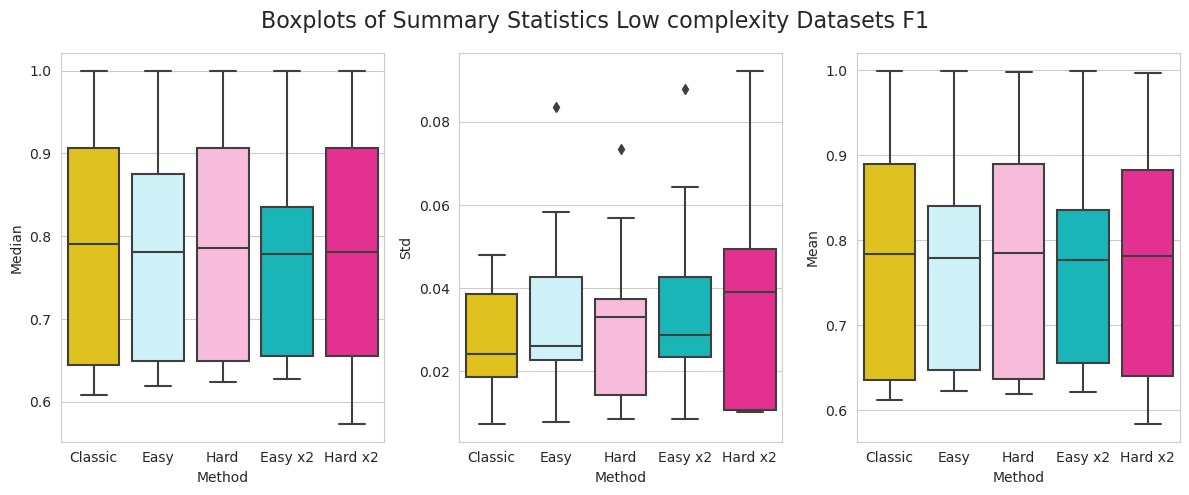

Low complexity datasets: WTL Classic vs sw_easy
   n_ensemble sample_weight_easy_F1
0          10             (1, 9, 3)
1          25             (4, 4, 5)
2          50             (5, 4, 4)
3         100             (3, 5, 5)
4         150             (3, 4, 6)
5         200             (4, 2, 7)
6         250             (3, 3, 7)
7         300             (2, 4, 7)
Low complexity datasets: WTL Classic vs sw_easy_x2
   n_ensemble sample_weight_easy_x2_F1
0          10                (3, 6, 4)
1          25                (3, 4, 6)
2          50                (5, 4, 4)
3         100                (4, 3, 6)
4         150                (3, 2, 8)
5         200                (4, 2, 7)
6         250                (3, 2, 8)
7         300                (3, 4, 6)
Low complexity datasets: WTL Classic vs sw_hard
   n_ensemble sample_weight_hard_F1
0          10             (3, 7, 3)
1          25             (4, 6, 3)
2          50             (7, 3, 3)
3         100             (5, 3, 5

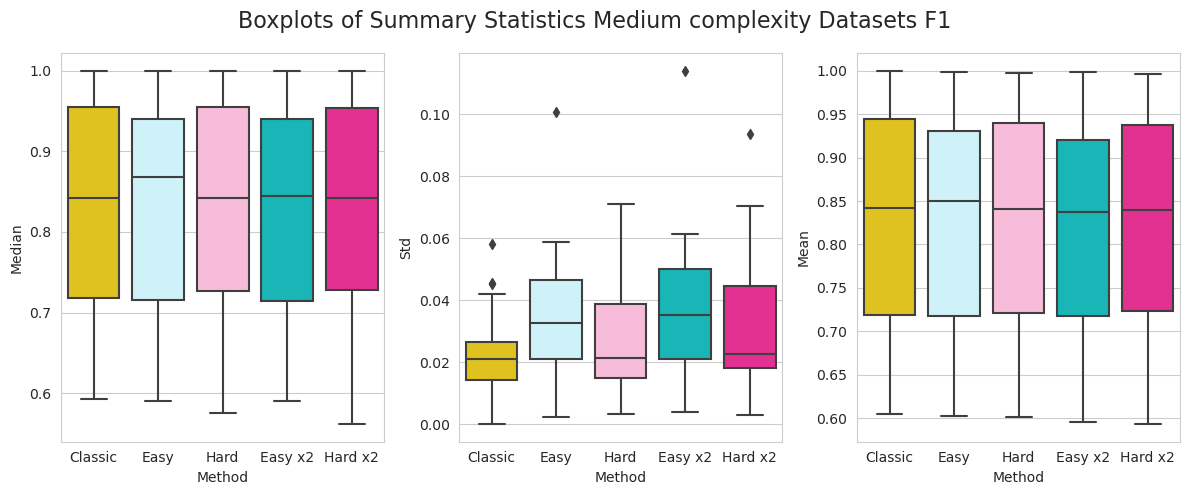

Medium complexity datasets: WTL Classic vs sw_easy
   n_ensemble sample_weight_easy_F1
0          10           (7, 10, 12)
1          25           (11, 6, 12)
2          50            (9, 6, 14)
3         100           (11, 6, 12)
4         150           (10, 9, 10)
5         200           (10, 8, 11)
6         250            (8, 6, 15)
7         300            (8, 8, 13)
Medium complexity datasets: WTL Classic vs sw_easy_x2
   n_ensemble sample_weight_easy_x2_F1
0          10               (6, 8, 15)
1          25               (8, 6, 15)
2          50               (8, 4, 17)
3         100              (10, 4, 15)
4         150               (7, 7, 15)
5         200               (9, 6, 14)
6         250               (9, 6, 14)
7         300              (10, 5, 14)
Medium complexity datasets: WTL Classic vs sw_hard
   n_ensemble sample_weight_hard_F1
0          10            (8, 13, 8)
1          25           (11, 11, 7)
2          50            (9, 9, 11)
3         100           (

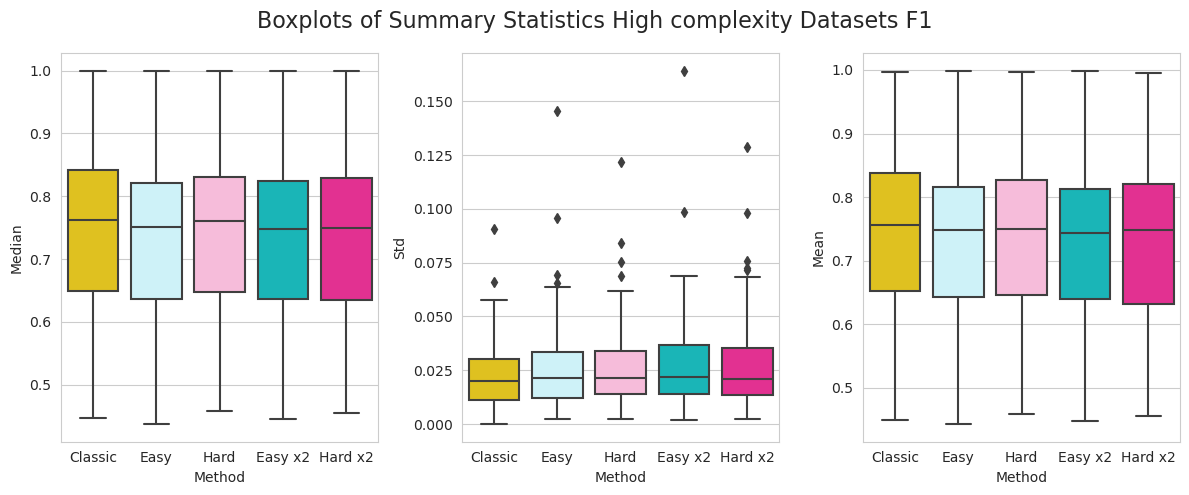

High complexity datasets: WTL Classic vs sw_easy
   n_ensemble sample_weight_easy_F1
0          10          (23, 14, 33)
1          25           (26, 5, 39)
2          50           (28, 5, 37)
3         100           (24, 4, 42)
4         150           (18, 5, 47)
5         200           (19, 6, 45)
6         250           (19, 7, 44)
7         300           (21, 6, 43)
High complexity datasets: WTL Classic vs sw_easy_x2
   n_ensemble sample_weight_easy_x2_F1
0          10             (15, 14, 41)
1          25              (22, 3, 45)
2          50              (28, 5, 37)
3         100              (23, 4, 43)
4         150              (19, 4, 47)
5         200              (16, 5, 49)
6         250              (17, 6, 47)
7         300              (17, 4, 49)
High complexity datasets: WTL Classic vs sw_hard
   n_ensemble sample_weight_hard_F1
0          10          (21, 11, 38)
1          25           (25, 7, 38)
2          50           (28, 6, 36)
3         100           (33, 4,

In [22]:
CM = 'F1'
loss_function = 'exponential'
summary_pivot_low, summary_pivot_medium, summary_pivot_high, wtl_sw_easy_low, wtl_sw_easy_medium, wtl_sw_easy_high, wtl_sw_easy_x2_low, wtl_sw_easy_x2_medium,wtl_sw_easy_x2_high, wtl_sw_hard_low, wtl_sw_hard_medium, wtl_sw_hard_high, wtl_sw_hard_x2_low, wtl_sw_hard_x2_medium, wtl_sw_hard_x2_high = summary_CM_complexity_dataset(CM,all_datasets,df_complex, loss_function)

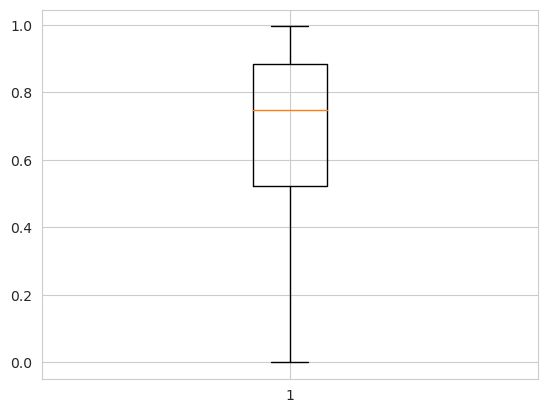

In [27]:
plt.boxplot(df_complex.F1)
plt.show()
# Mucha densidad de valores a partir del 0.6.

**F1**

La categorización no funciona: low (13), intermediate (29), high (70)

 * En fácil no analizo por la escasez.

 * Datos intermedios (13), lo mejor nuestro es hard. En el WTL, ganamos en 2, empatamos en 1 y perdemos en 5. Son muy pocos datos.

 * Datos difíciles (70), lo mejor nuestro es hard. ¡Ojo! Es la primera vez que en datos difíciles para nosotros es mejor hard que easy. Pero bueno, aquí están metidos todos los datos. En WTL con hard logramos un par de empates y en el resto perdemos. Claramente le ganador es Classic GB.

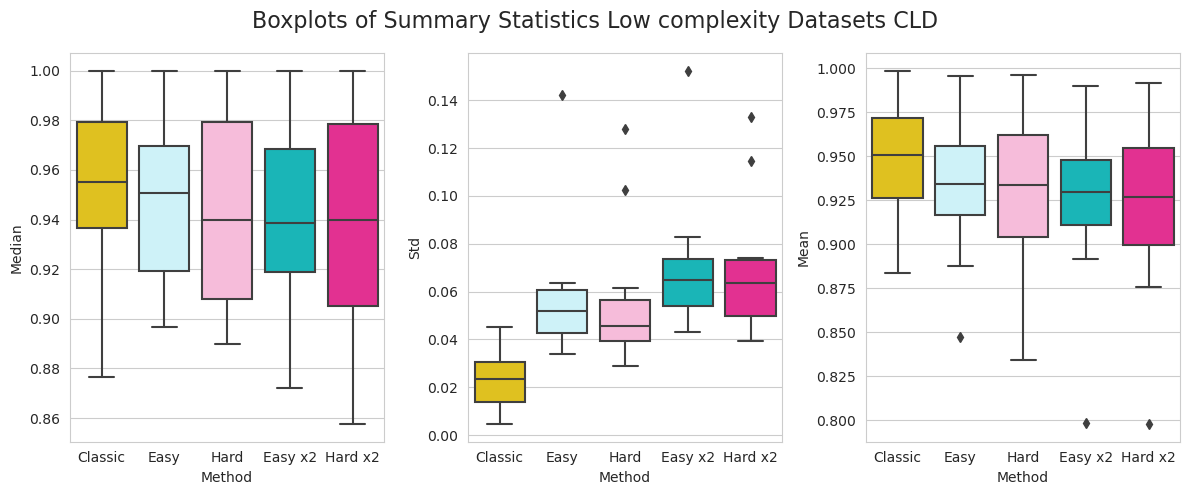

Low complexity datasets: WTL Classic vs sw_easy
   n_ensemble sample_weight_easy_CLD
0          10              (2, 3, 6)
1          25              (3, 4, 4)
2          50              (1, 5, 5)
3         100              (1, 4, 6)
4         150              (1, 4, 6)
5         200              (1, 5, 5)
6         250              (2, 4, 5)
7         300              (2, 5, 4)
Low complexity datasets: WTL Classic vs sw_easy_x2
   n_ensemble sample_weight_easy_x2_CLD
0          10                 (2, 1, 8)
1          25                 (3, 3, 5)
2          50                 (2, 5, 4)
3         100                 (1, 4, 6)
4         150                 (1, 3, 7)
5         200                 (1, 4, 6)
6         250                 (1, 4, 6)
7         300                 (1, 5, 5)
Low complexity datasets: WTL Classic vs sw_hard
   n_ensemble sample_weight_hard_CLD
0          10              (3, 3, 5)
1          25              (2, 4, 5)
2          50              (4, 4, 3)
3         10

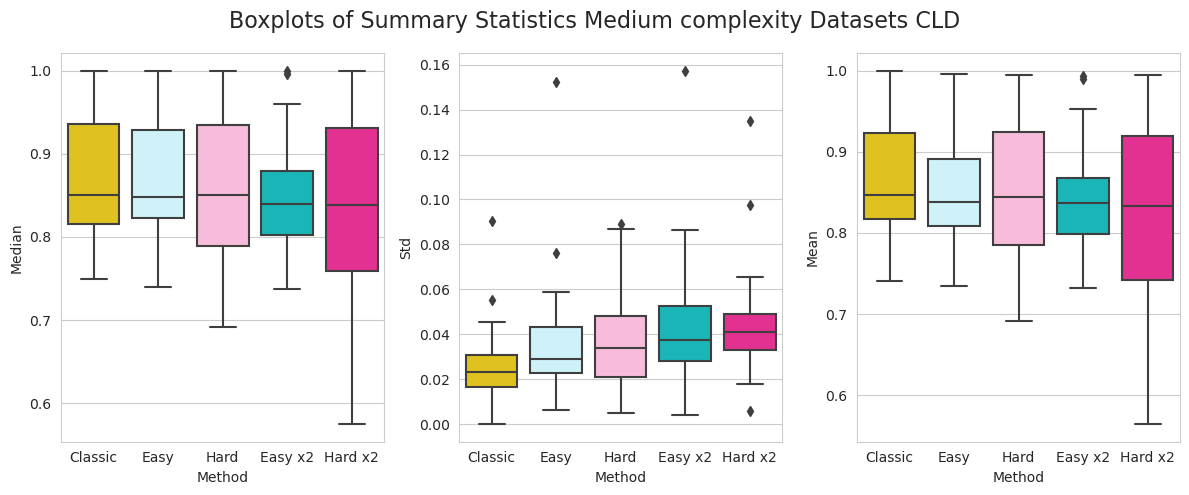

Medium complexity datasets: WTL Classic vs sw_easy
   n_ensemble sample_weight_easy_CLD
0          10            (4, 13, 16)
1          25            (4, 10, 19)
2          50             (9, 6, 18)
3         100             (9, 7, 17)
4         150            (10, 6, 17)
5         200             (9, 6, 18)
6         250             (5, 8, 20)
7         300             (8, 9, 16)
Medium complexity datasets: WTL Classic vs sw_easy_x2
   n_ensemble sample_weight_easy_x2_CLD
0          10               (4, 13, 16)
1          25                (2, 8, 23)
2          50                (6, 5, 22)
3         100                (5, 4, 24)
4         150                (8, 5, 20)
5         200                (5, 7, 21)
6         250                (6, 8, 19)
7         300                (9, 8, 16)
Medium complexity datasets: WTL Classic vs sw_hard
   n_ensemble sample_weight_hard_CLD
0          10             (9, 6, 18)
1          25             (9, 4, 20)
2          50             (6, 5, 22)
3  

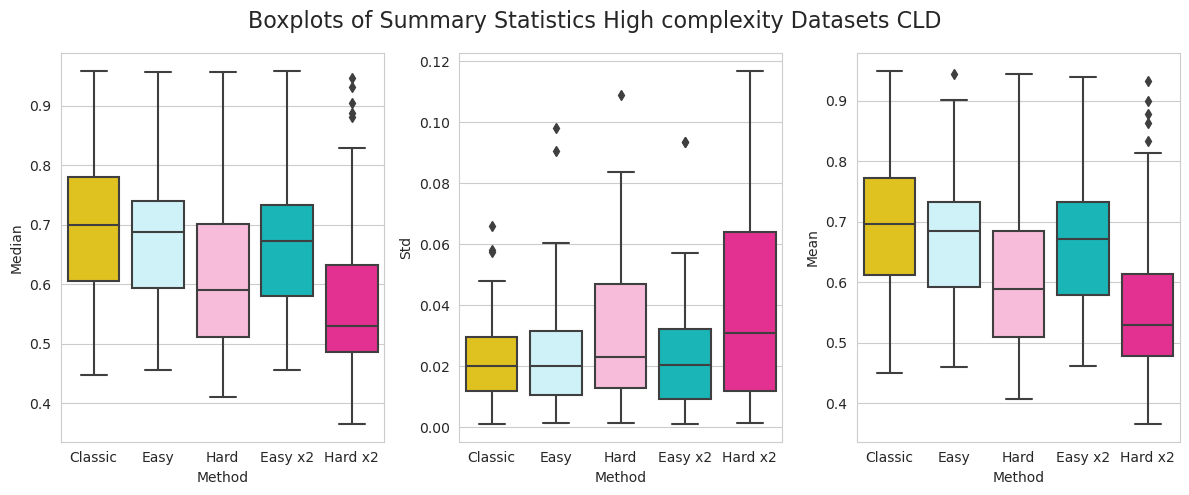

High complexity datasets: WTL Classic vs sw_easy
   n_ensemble sample_weight_easy_CLD
0          10           (16, 11, 41)
1          25            (16, 1, 51)
2          50            (19, 1, 48)
3         100            (25, 1, 42)
4         150            (18, 6, 44)
5         200            (19, 4, 45)
6         250            (20, 4, 44)
7         300            (21, 2, 45)
High complexity datasets: WTL Classic vs sw_easy_x2
   n_ensemble sample_weight_easy_x2_CLD
0          10              (16, 12, 40)
1          25               (14, 1, 53)
2          50               (19, 1, 48)
3         100               (19, 2, 47)
4         150               (22, 2, 44)
5         200               (23, 1, 44)
6         250               (22, 1, 45)
7         300               (21, 2, 45)
High complexity datasets: WTL Classic vs sw_hard
   n_ensemble sample_weight_hard_CLD
0          10             (8, 2, 58)
1          25             (8, 1, 59)
2          50             (8, 1, 59)
3        

In [23]:
CM = 'CLD'
loss_function = 'exponential'
summary_pivot_low, summary_pivot_medium, summary_pivot_high, wtl_sw_easy_low, wtl_sw_easy_medium, wtl_sw_easy_high, wtl_sw_easy_x2_low, wtl_sw_easy_x2_medium,wtl_sw_easy_x2_high, wtl_sw_hard_low, wtl_sw_hard_medium, wtl_sw_hard_high, wtl_sw_hard_x2_low, wtl_sw_hard_x2_medium, wtl_sw_hard_x2_high = summary_CM_complexity_dataset(CM,all_datasets,df_complex, loss_function)

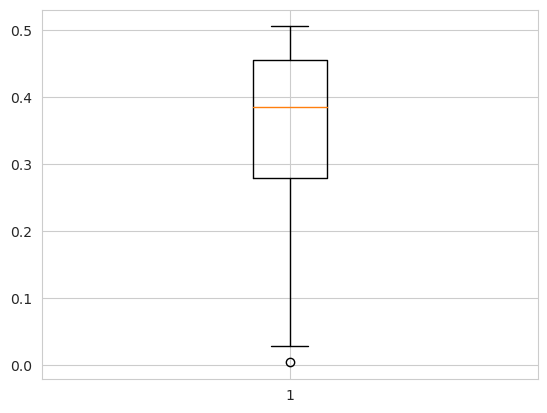

In [28]:
plt.boxplot(df_complex.CLD)
plt.show()
# Mucha densidad concentrada entre 0.3 y 0.5

**CLD**

La categorización no funciona: low (11), intermediate (33), high (68)

 * Los fáciles no los analizo por falta de datos.

 * Datos intermedios, lo mejor para nosotros sería hard pero claramente gana classic GB.

 * Datos difíciles, lo mejor para nosotros es easy pero claramente gana classic GB.

In [11]:
win_tie_loss_df, all_results = win_tie_loss_comparison_info_complexity(all_datasets, df_complex, loss_function='exponential', main_method='classic', compare_method='sample_weight_easy')

In [12]:
all_datasets

dataset  n_ensemble         method_weights  \
0        analcatdata_gviolence           1                classic   
1        analcatdata_gviolence           2                classic   
2        analcatdata_gviolence           3                classic   
3        analcatdata_gviolence           4                classic   
4        analcatdata_gviolence           5                classic   
...                        ...         ...                    ...   
2486395        chscase_census2         296  sample_weight_hard_x2   
2486396        chscase_census2         297  sample_weight_hard_x2   
2486397        chscase_census2         298  sample_weight_hard_x2   
2486398        chscase_census2         299  sample_weight_hard_x2   
2486399        chscase_census2         300  sample_weight_hard_x2   

        compl_measure loss_selected  loss_train_mean  loss_test_mean  \
0                none      log_loss         0.594795        0.595964   
1                none      log_loss         0.525625        0.527052   
2                none      log_loss         0.468327        0.470040   
3                none      log_loss         0.420207        0.422230   
4                none      log_loss         0.379347        0.384646   
...               ...           ...              ...             ...   
2486395            F1   exponential         1.058461        1.056844   
2486396            F1   exponential         1.058589        1.056986   
2486397            F1   exponential         1.058603        1.057170   
2486398            F1   exponential         1.059012        1.058859   
2486399            F1   exponential         1.059011        1.058941   

         train_acc_mean  test_acc_mean  loss_train_std  loss_test_std  \
0              0.581072       0.580357        0.002832       0.014582   
1              0.972953       0.971429        0.004412       0.020456   
2              0.972953       0.971429        0.005802       0.027505   
3              0.972953       0.971429        0.007018       0.034744   
4              0.972953       0.971429        0.008074       0.040833   
...                 ...            ...             ...            ...   
2486395        0.730000       0.457500        0.023111       0.051212   
2486396        0.731944       0.460000        0.022954       0.051156   
2486397        0.731944       0.457500        0.022979       0.050974   
2486398        0.732500       0.457500        0.022662       0.053705   
2486399        0.731944       0.457500        0.022698       0.053536   

         train_acc_std  test_acc_std       conf_matr_train_total  \
0             0.004567      0.037881        [[387, 0], [279, 0]]   
1             0.006392      0.060234       [[369, 18], [0, 279]]   
2             0.006392      0.060234       [[369, 18], [0, 279]]   
3             0.006392      0.060234       [[369, 18], [0, 279]]   
4             0.006392      0.060234       [[369, 18], [0, 279]]   
...                ...           ...                         ...   
2486395       0.010861      0.070760  [[1299, 528], [444, 1329]]   
2486396       0.009908      0.073786  [[1303, 524], [441, 1332]]   
2486397       0.010818      0.070760  [[1303, 524], [441, 1332]]   
2486398       0.011268      0.070760  [[1303, 524], [439, 1334]]   
2486399       0.010658      0.066719  [[1302, 525], [440, 1333]]   

           conf_matr_test_total  
0            [[43, 0], [31, 0]]  
1            [[41, 2], [0, 31]]  
2            [[41, 2], [0, 31]]  
3            [[41, 2], [0, 31]]  
4            [[41, 2], [0, 31]]  
...                         ...  
2486395  [[93, 110], [107, 90]]  
2486396  [[93, 110], [106, 91]]  
2486397  [[93, 110], [107, 90]]  
2486398  [[93, 110], [107, 90]]  
2486399  [[92, 111], [106, 91]]  

[2486400 rows x 15 columns]

In [13]:
results_df = pd.DataFrame(all_results)
results_df

n_ensemble compl_measure result  complexity_value  \
0             10     Hostility   loss          0.229730   
1             10     Hostility   loss          0.181481   
2             10     Hostility   loss          0.337098   
3             10     Hostility   loss          0.214286   
4             10     Hostility    win          0.342900   
...          ...           ...    ...               ...   
8059         300            F1    tie          0.828231   
8060         300            F1   loss          0.889940   
8061         300            F1    win          0.986908   
8062         300            F1   loss          0.744147   
8063         300            F1   loss          0.984286   

               dataset_name   classic  sample_weight_easy  
0     analcatdata_gviolence  0.971429            0.914286  
1             heart-statlog  0.818519            0.785185  
2      diabetic_retinopathy  0.645525            0.597759  
3            hutsof99_logis  0.728571            0.671429  
4         disclosure_x_bias  0.522614            0.531660  
...                     ...       ...                 ...  
8059                bodyfat  0.996000            0.996000  
8060               vehicle2  0.972801            0.971653  
8061  disclosure_x_tampered  0.500158            0.513749  
8062                 boston  0.881255            0.873451  
8063        chscase_census2  0.490000            0.487500  

[8064 rows x 7 columns]

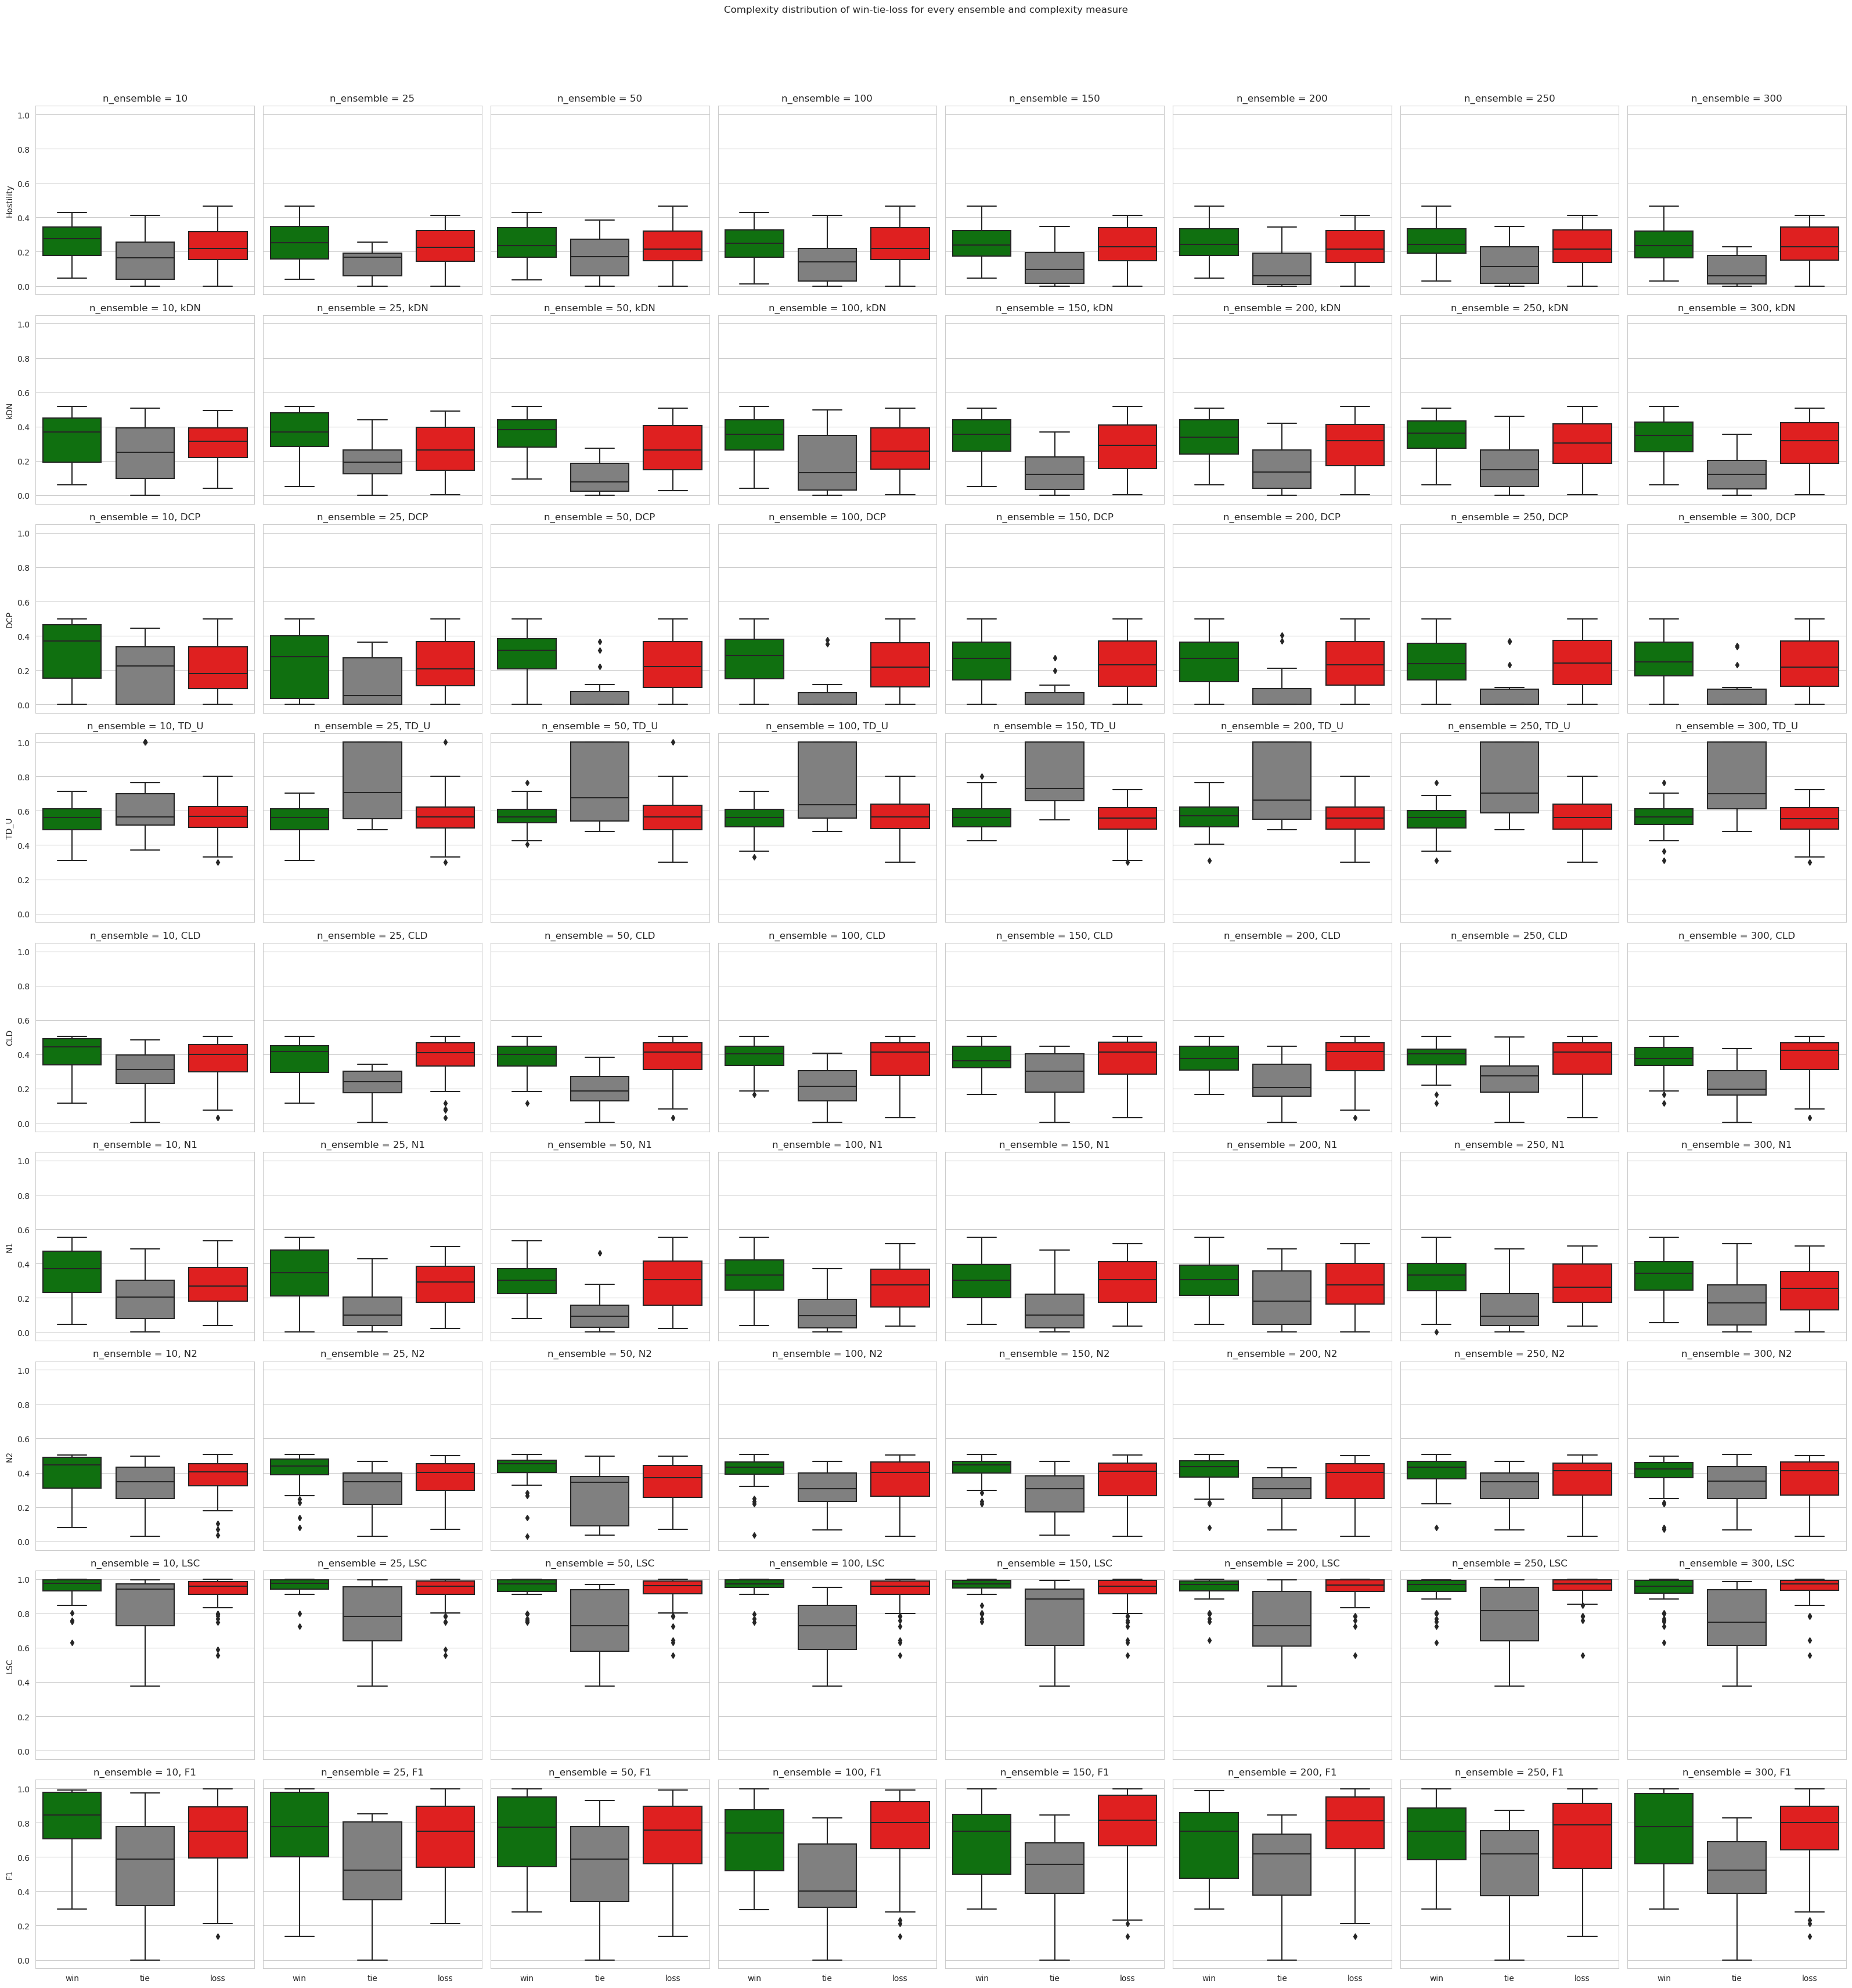

In [91]:
list_CM = ['Hostility','kDN','DCP','TD_U','CLD','N1','N2','LSC','F1']
n_ensemble_values = [10, 25, 50, 100, 150, 200, 250, 300]
# Crear la cuadrícula de gráficos
n_rows = len(list_CM)
n_cols = len(n_ensemble_values)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows), sharey=True,sharex=True)
fig.suptitle("Complexity distribution of win-tie-loss for every ensemble and complexity measure")

paleta = {'win': 'green', 'tie': 'grey', 'loss': 'red'}
orden = ['win', 'tie', 'loss']  # Orden fijo de categorías

for i, compl_measure in enumerate(list_CM):
    for j, n in enumerate(n_ensemble_values):
            # Filtrar los datos para la medida de complejidad y n_ensemble específicos
        subset = results_df[(results_df['n_ensemble'] == n) & (results_df['compl_measure'] == compl_measure)]

        # Crear el boxplot
        sns.boxplot(data=subset, x='result', y='complexity_value', ax=axes[i, j], palette=paleta, order=orden)
        axes[i, j].set_title(f'n_ensemble = {n}, {compl_measure}')
        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel('')

# Ajustar etiquetas generales
for ax, compl_measure in zip(axes[:, 0], list_CM):
    ax.set_ylabel(compl_measure)

for ax, n in zip(axes[0, :], n_ensemble_values):
    ax.set_title(f'n_ensemble = {n}')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Añadimos la cantidad de datos en cada boxplot

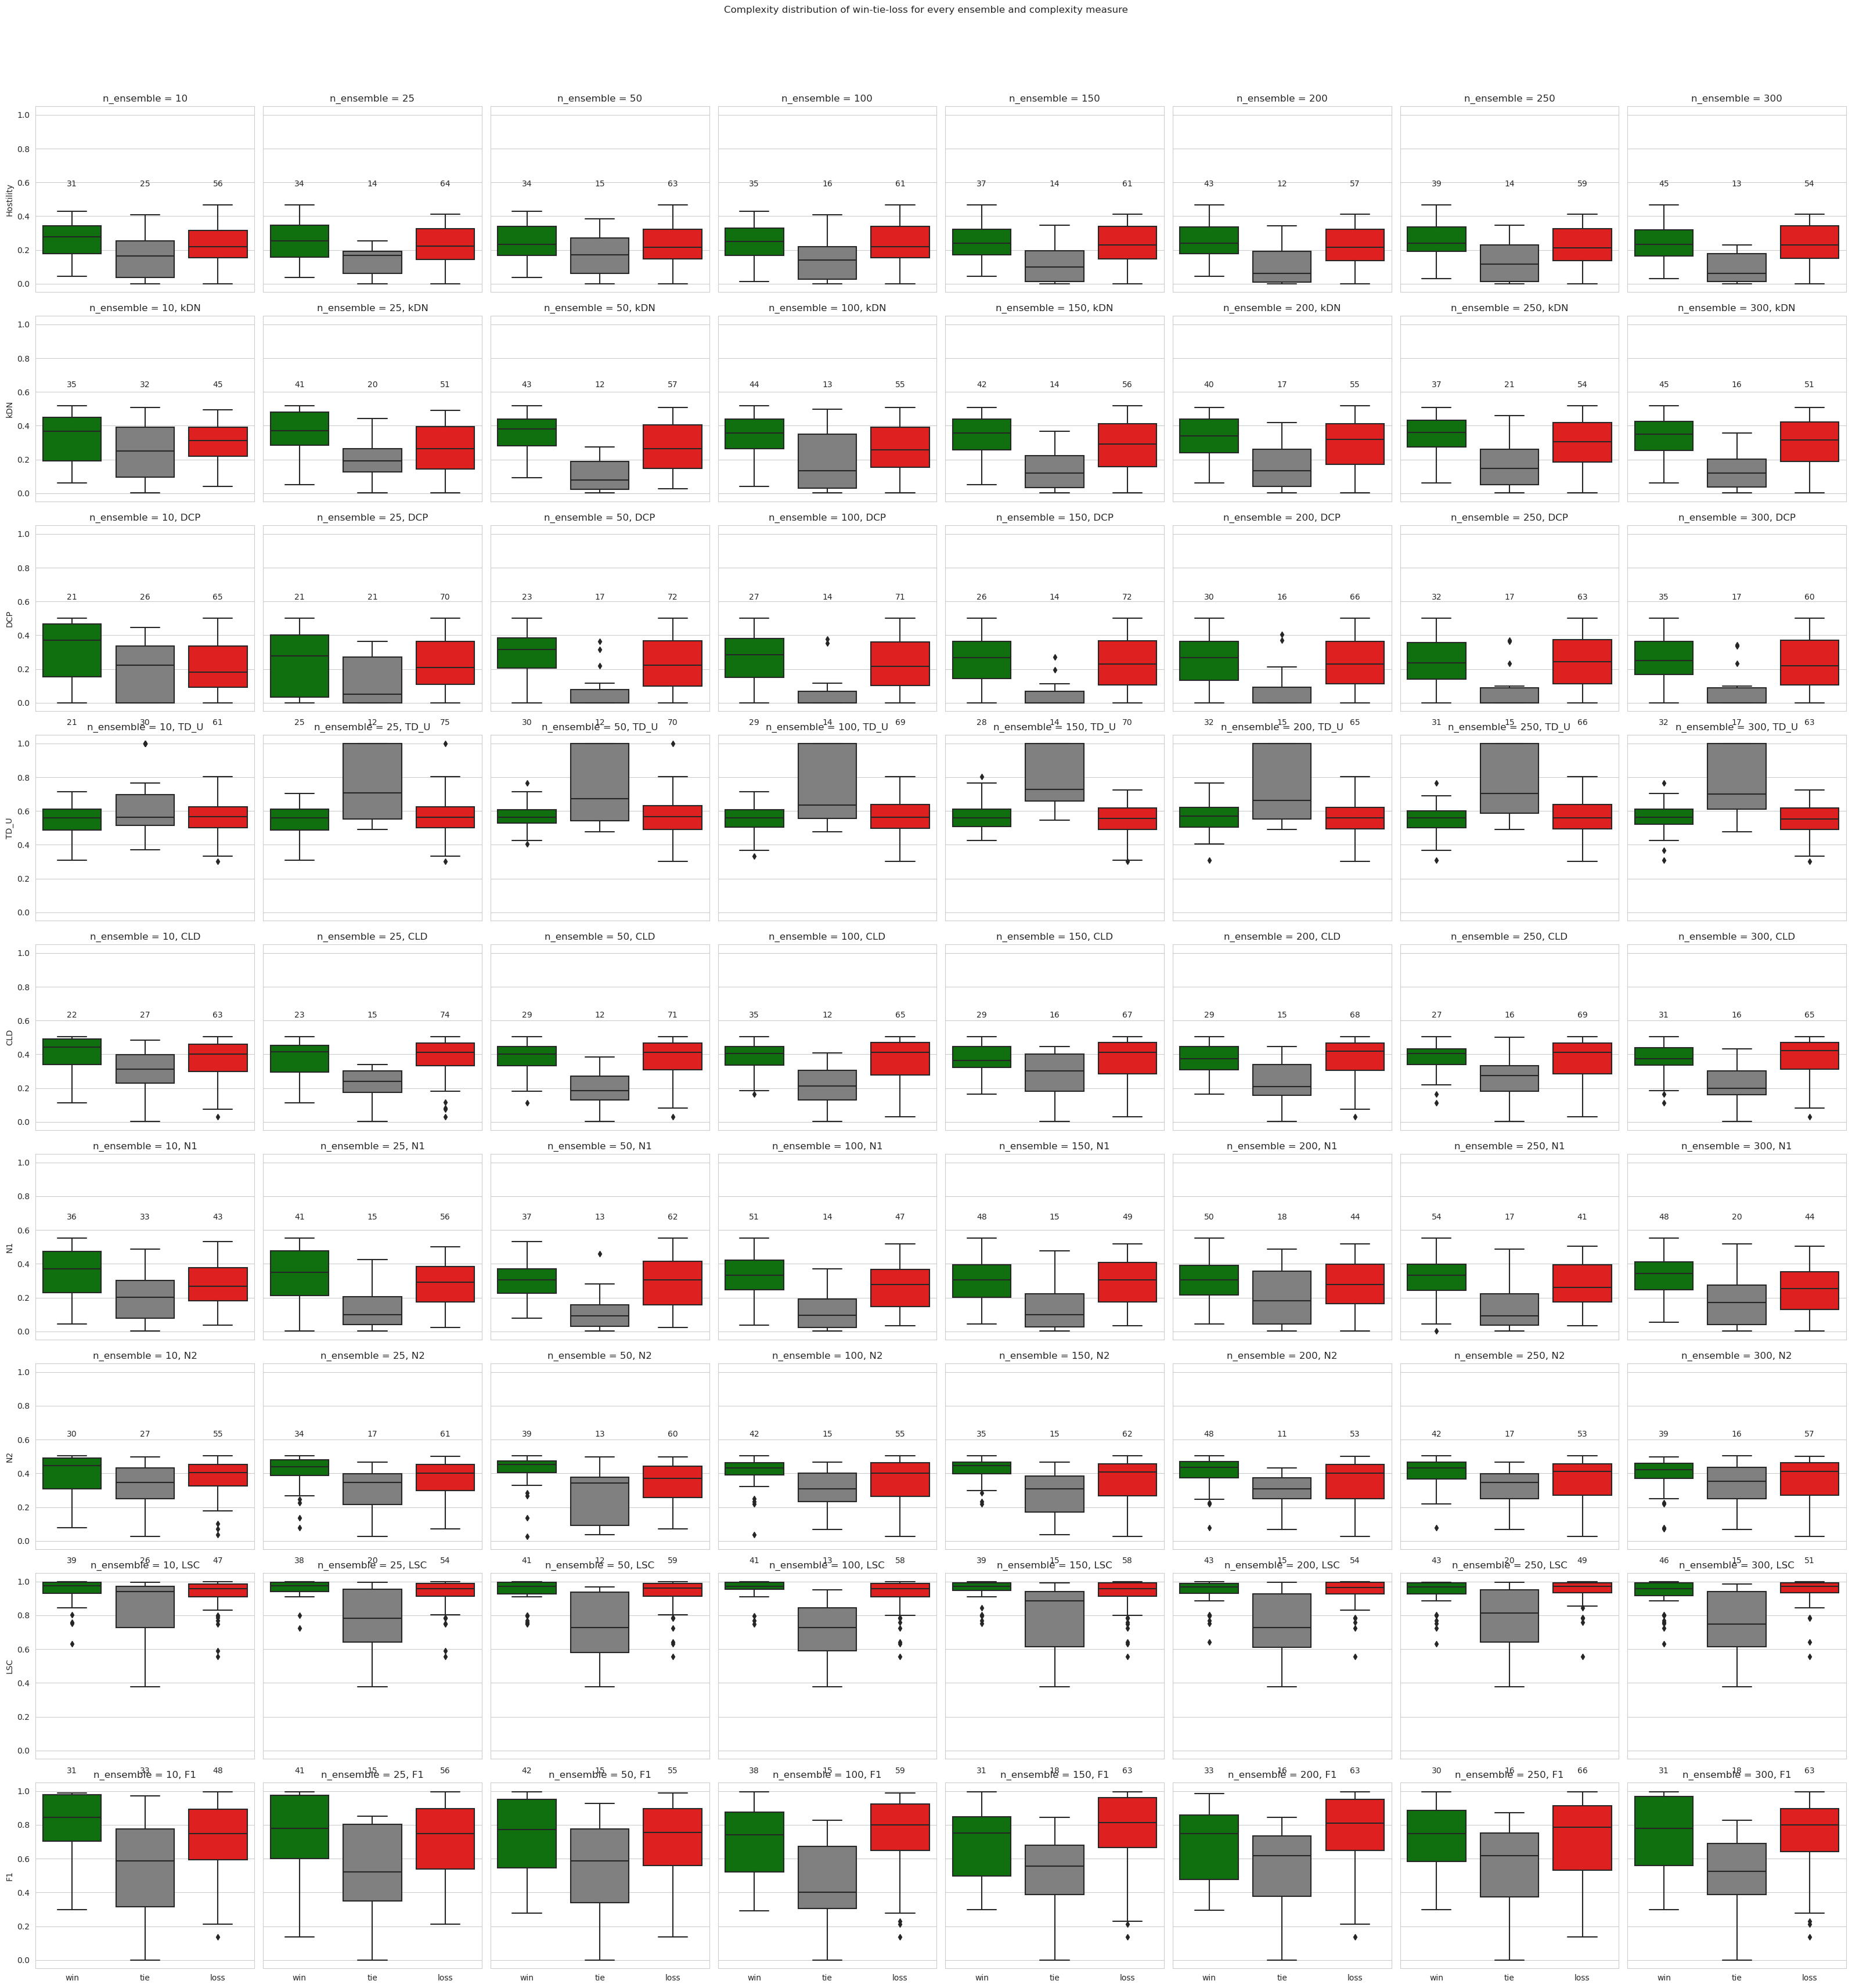

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns

list_CM = ['Hostility', 'kDN', 'DCP', 'TD_U', 'CLD', 'N1', 'N2', 'LSC', 'F1']
n_ensemble_values = [10, 25, 50, 100, 150, 200, 250, 300]

# Crear la cuadrícula de gráficos
n_rows = len(list_CM)
n_cols = len(n_ensemble_values)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows), sharey=True, sharex=True)
fig.suptitle("Complexity distribution of win-tie-loss for every ensemble and complexity measure")

paleta = {'win': 'green', 'tie': 'grey', 'loss': 'red'}
orden = ['win', 'tie', 'loss']  # Orden fijo de categorías

for i, compl_measure in enumerate(list_CM):
    for j, n in enumerate(n_ensemble_values):
        # Filtrar los datos para la medida de complejidad y n_ensemble específicos
        subset = results_df[(results_df['n_ensemble'] == n) & (results_df['compl_measure'] == compl_measure)]

        # Crear el boxplot
        sns.boxplot(data=subset, x='result', y='complexity_value', ax=axes[i, j], palette=paleta, order=orden)

        # Añadir la cantidad de datos encima de cada boxplot
        counts = subset['result'].value_counts()
        for k, category in enumerate(orden):
            if category in counts:
                count = counts[category]
                axes[i, j].text(k, subset['complexity_value'].max() + 0.1,  # Ajustar posición vertical
                                str(count), ha='center', va='bottom', fontsize=10)

        axes[i, j].set_title(f'n_ensemble = {n}, {compl_measure}')
        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel('')

# Ajustar etiquetas generales
for ax, compl_measure in zip(axes[:, 0], list_CM):
    ax.set_ylabel(compl_measure)

for ax, n in zip(axes[0, :], n_ensemble_values):
    ax.set_title(f'n_ensemble = {n}')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Con las medidas con rangos difíciles de interpretar no se aclara nada. Pero con las fáciles de interrpetar (N1, kdn, hostility, n2) sí se aprecia que para los datatasets difíciles es mejor darle peso a lo fácil. Lo que pasa es que no está super claro. Voy a probar a hacer un filtro más exhaustivo de lo que se considera "dataset difícil" mezclando las medidas de complejidad para las que parece que la cosa funciona. Puedo intentar conseguir más datasets difíciles

In [14]:
# Lo hacemos con los pesos difíciles
win_tie_loss_df, all_results = win_tie_loss_comparison_info_complexity(all_datasets, df_complex, loss_function='exponential', main_method='classic', compare_method='sample_weight_hard')


In [15]:
results_df_sw_hard = pd.DataFrame(all_results)
results_df_sw_hard

n_ensemble compl_measure result  complexity_value  \
0             10     Hostility    tie          0.229730   
1             10     Hostility   loss          0.181481   
2             10     Hostility   loss          0.337098   
3             10     Hostility    win          0.214286   
4             10     Hostility   loss          0.342900   
...          ...           ...    ...               ...   
8059         300            F1    tie          0.828231   
8060         300            F1   loss          0.889940   
8061         300            F1    win          0.986908   
8062         300            F1    win          0.744147   
8063         300            F1   loss          0.984286   

               dataset_name   classic  sample_weight_hard  
0     analcatdata_gviolence  0.971429            0.971429  
1             heart-statlog  0.818519            0.770370  
2      diabetic_retinopathy  0.645525            0.576867  
3            hutsof99_logis  0.728571            0.742857  
4         disclosure_x_bias  0.522614            0.459204  
...                     ...       ...                 ...  
8059                bodyfat  0.996000            0.996000  
8060               vehicle2  0.972801            0.968025  
8061  disclosure_x_tampered  0.500158            0.525893  
8062                 boston  0.881255            0.887137  
8063        chscase_census2  0.490000            0.465000  

[8064 rows x 7 columns]

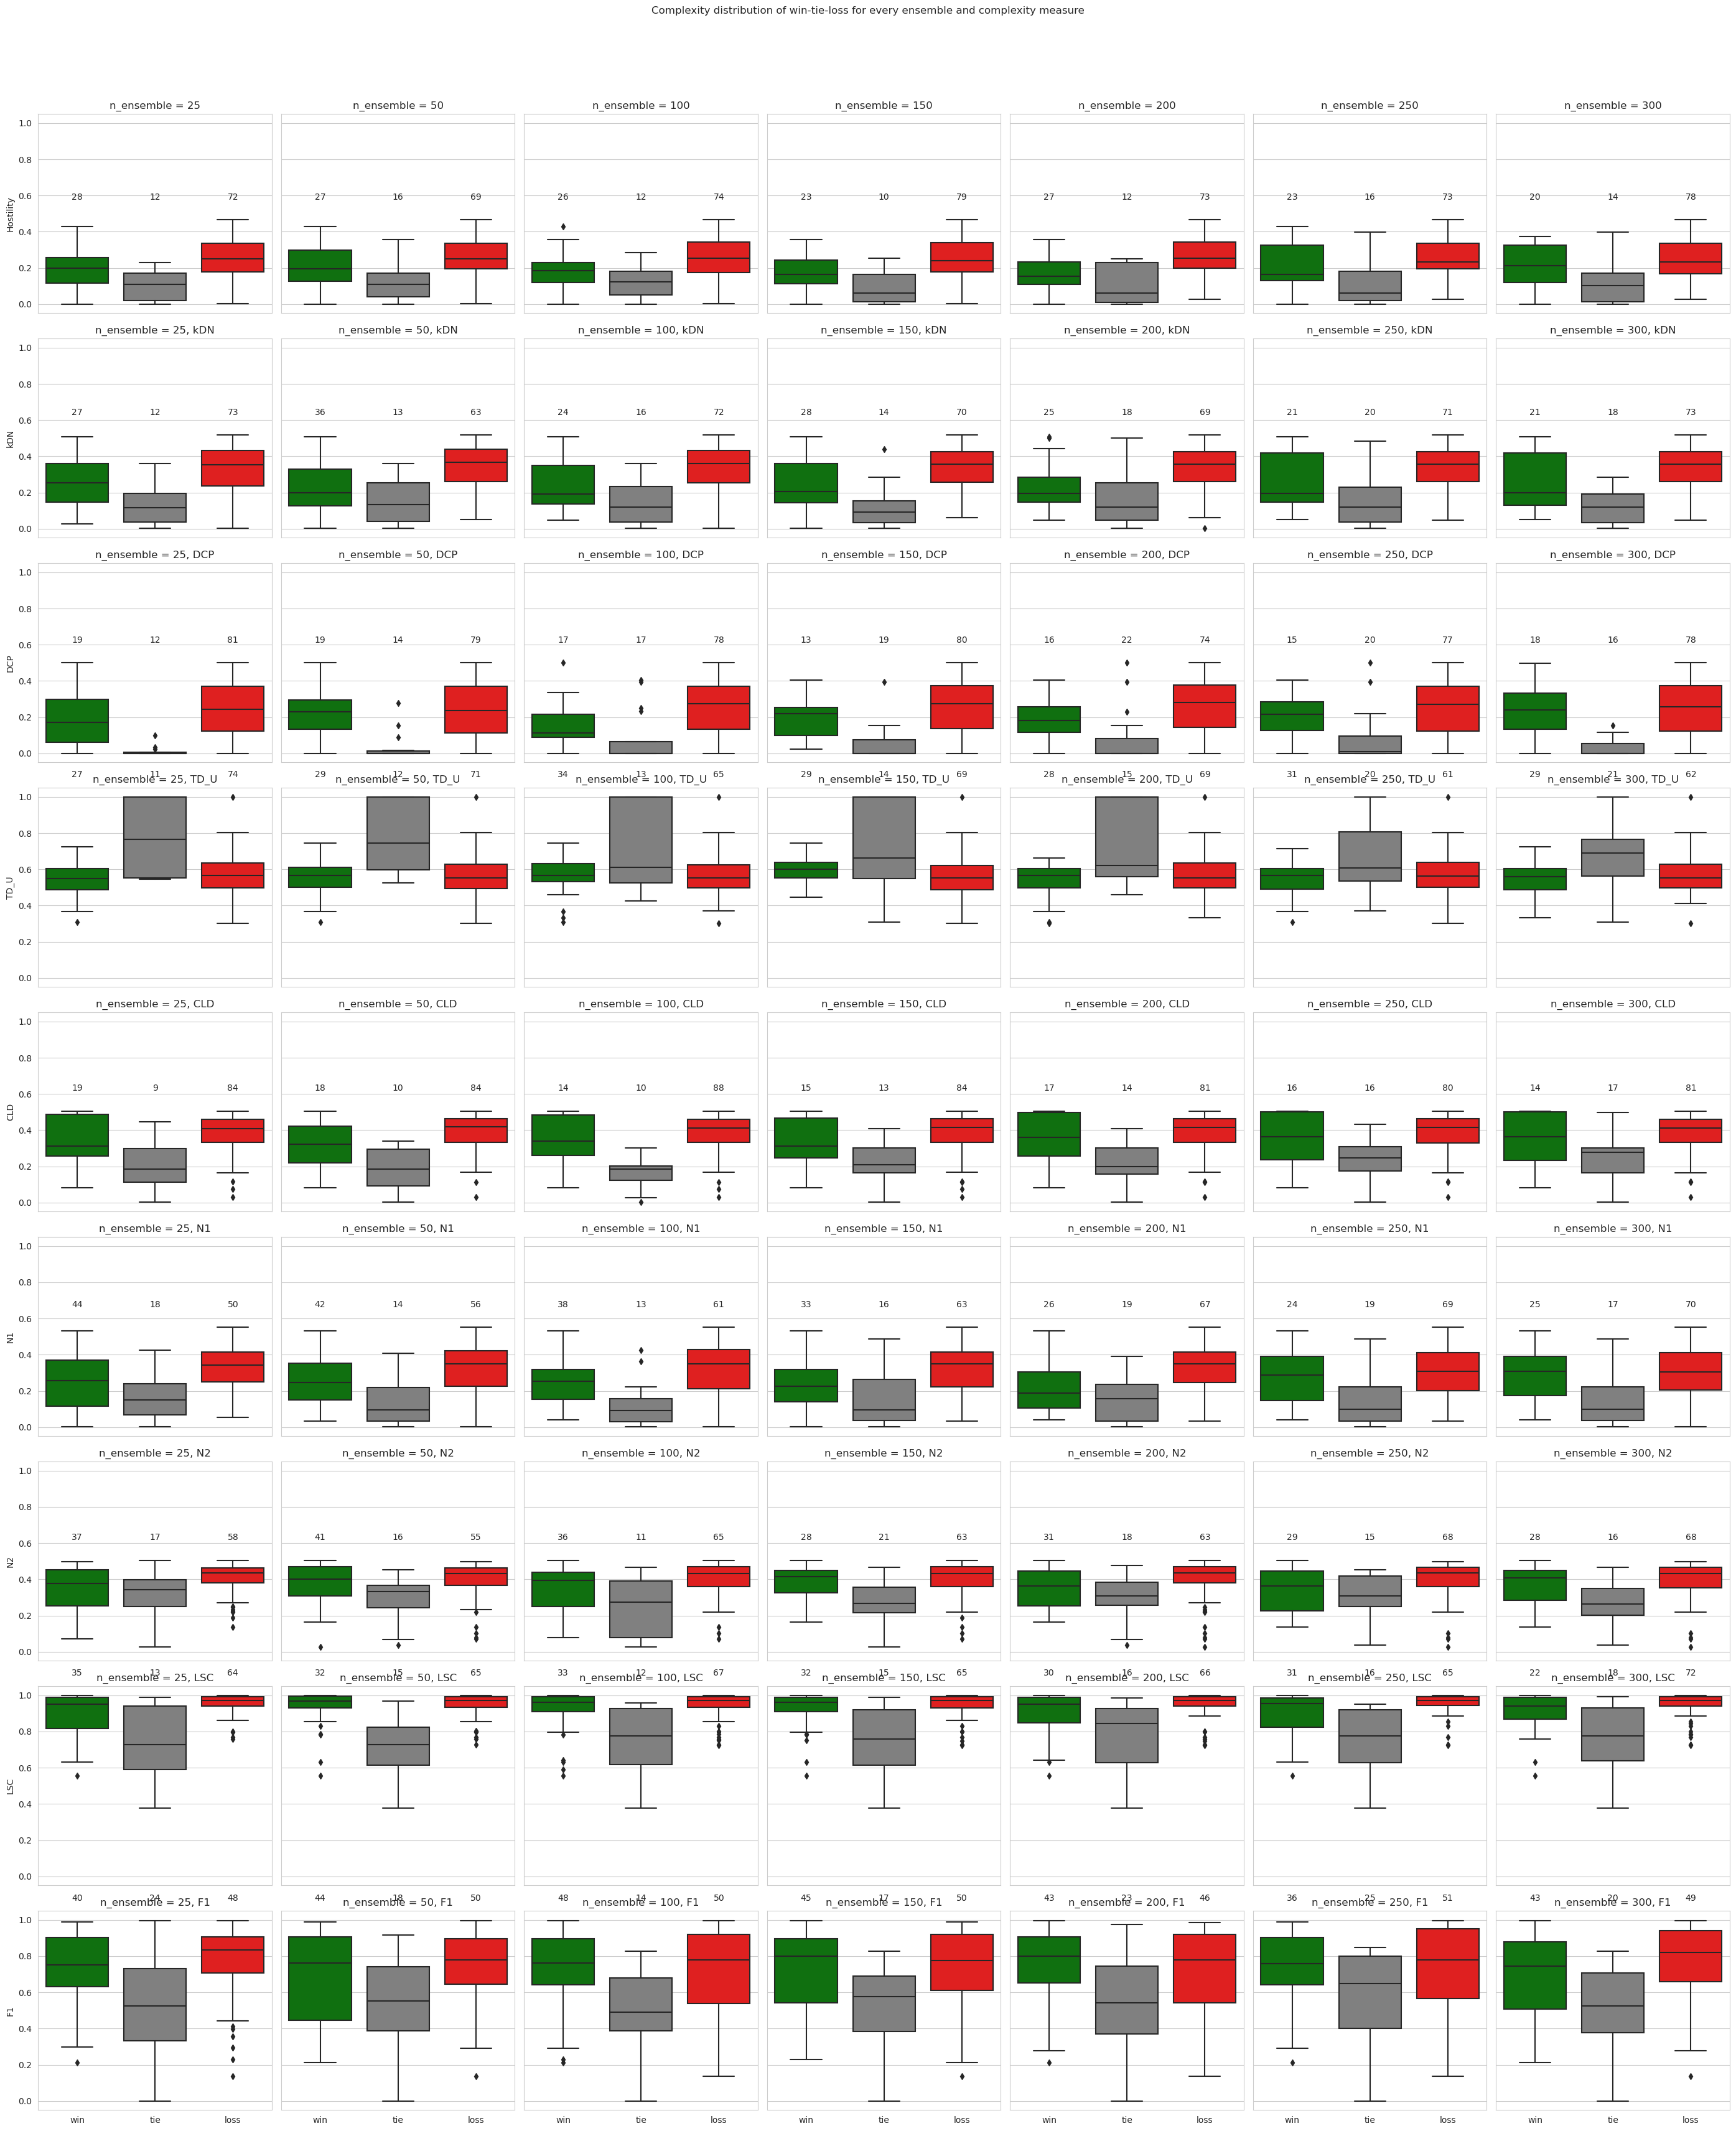

In [95]:

list_CM = ['Hostility', 'kDN', 'DCP', 'TD_U', 'CLD', 'N1', 'N2', 'LSC', 'F1']
n_ensemble_values = [25, 50, 100, 150, 200, 250, 300]

# Crear la cuadrícula de gráficos
n_rows = len(list_CM)
n_cols = len(n_ensemble_values)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows), sharey=True, sharex=True)
fig.suptitle("Complexity distribution of win-tie-loss for every ensemble and complexity measure")

paleta = {'win': 'green', 'tie': 'grey', 'loss': 'red'}
orden = ['win', 'tie', 'loss']  # Orden fijo de categorías

for i, compl_measure in enumerate(list_CM):
    for j, n in enumerate(n_ensemble_values):
        # Filtrar los datos para la medida de complejidad y n_ensemble específicos
        subset = results_df_sw_hard[(results_df_sw_hard['n_ensemble'] == n) & (results_df_sw_hard['compl_measure'] == compl_measure)]

        # Crear el boxplot
        sns.boxplot(data=subset, x='result', y='complexity_value', ax=axes[i, j], palette=paleta, order=orden)

        # Añadir la cantidad de datos encima de cada boxplot
        counts = subset['result'].value_counts()
        for k, category in enumerate(orden):
            if category in counts:
                count = counts[category]
                axes[i, j].text(k, subset['complexity_value'].max() + 0.1,  # Ajustar posición vertical
                                str(count), ha='center', va='bottom', fontsize=10)

        axes[i, j].set_title(f'n_ensemble = {n}, {compl_measure}')
        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel('')

# Ajustar etiquetas generales
for ax, compl_measure in zip(axes[:, 0], list_CM):
    ax.set_ylabel(compl_measure)

for ax, n in zip(axes[0, :], n_ensemble_values):
    ax.set_title(f'n_ensemble = {n}')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Cuando el conjunto de datos es difícil, es mejor darle más peso a lo fácil. Cuando es fácil, es mejor darle más peso a lo difícil. Cuando le damos peso a lo difícil, se nota menos ganancia: el número de datasets en el que ganamos es menor y la complejidad se diferencia menos entre ganar y perder. Esto tiene sentido puesto que el objetivo del boosting es centrarse en los puntos más difíciles, entonces lo que puede aportar la medida de complejidad es menos. Sin embargo, el aportar un poco más de peso en lo fácil (sample_weight_easy) sí parece tener un mejor efecto en los resultados para los conjuntos de datos difíciles.

Tendría que estudiar también quién consigue un resultado mayor antes (o al menos con diferencia significativa)


**"Conclusión por ahora"**

 * Medidas que aparcamos por ahora debido a la dificultad a la hora de interpretar el rango y, por tanto, realizar categorizaciones: LSC, valores muy concentrados en 0.9, muy difícil de interpretar. TD_U por tema de categorización y porque aporta la misma información que boosting. F1 por la categorización y por los resultados. CLD por la categorización y por los resultados.


 * N2: mejorar la categorización porque hay luz al fondo del tunel. Hacerlo en función de otras medidas de complejidad.

 * Hostility; investigar un poco más
 * DCP investigar un poco más

 * kDN y N1 son los que mejores resultados ofrecen. Hacer una categorización general de complejidad de datasets en función de distintas medidas de complejidad y ver ahí cómo funcionan las cosas

 * Obtener aun más datos

 * Algún estudio de estabilidad para ver quién logra el mejor resultado y cuándo. Ver quién se degrada más.



Estudiamos con más detalle los resultados de N1 con 100 y 250 ensembles puesto que es cuando conseguimos mayor número de wins (usamos los resultados con sample_weight_easy).

In [16]:
wins_N1 = results_df.loc[(results_df.compl_measure == 'N1') & (results_df.result == 'win') & (results_df.n_ensemble == 100),:]
wins_N1

n_ensemble compl_measure result  complexity_value  \
3584         100            N1    win          0.064189   
3585         100            N1    win          0.241270   
3586         100            N1    win          0.380358   
3588         100            N1    win          0.503927   
3589         100            N1    win          0.038600   
3590         100            N1    win          0.392361   
3592         100            N1    win          0.243978   
3594         100            N1    win          0.410251   
3596         100            N1    win          0.395458   
3598         100            N1    win          0.349838   
3600         100            N1    win          0.531875   
3602         100            N1    win          0.486667   
3607         100            N1    win          0.192174   
3608         100            N1    win          0.318856   
3610         100            N1    win          0.268056   
3611         100            N1    win          0.428533   
3612         100            N1    win          0.498624   
3613         100            N1    win          0.385886   
3615         100            N1    win          0.299808   
3617         100            N1    win          0.454455   
3618         100            N1    win          0.304679   
3621         100            N1    win          0.348276   
3622         100            N1    win          0.224359   
3628         100            N1    win          0.208833   
3629         100            N1    win          0.332546   
3630         100            N1    win          0.304210   
3633         100            N1    win          0.249175   
3634         100            N1    win          0.281494   
3636         100            N1    win          0.247436   
3645         100            N1    win          0.220405   
3647         100            N1    win          0.477625   
3651         100            N1    win          0.275794   
3653         100            N1    win          0.494444   
3656         100            N1    win          0.277964   
3660         100            N1    win          0.382319   
3664         100            N1    win          0.203021   
3665         100            N1    win          0.396036   
3670         100            N1    win          0.075983   
3672         100            N1    win          0.351143   
3673         100            N1    win          0.272436   
3677         100            N1    win          0.553315   
3679         100            N1    win          0.333333   
3682         100            N1    win          0.413995   
3684         100            N1    win          0.369537   
3687         100            N1    win          0.044400   
3688         100            N1    win          0.050215   
3689         100            N1    win          0.526667   
3690         100            N1    win          0.471679   
3693         100            N1    win          0.500227   
3694         100            N1    win          0.174045   
3695         100            N1    win          0.474792   

                             dataset_name   classic  sample_weight_easy  
3584                analcatdata_gviolence  0.957143            0.971429  
3585                        heart-statlog  0.844444            0.855556  
3586                 diabetic_retinopathy  0.644625            0.662879  
3588                    disclosure_x_bias  0.531660            0.539326  
3589               qualitative-bankruptcy  0.984000            1.000000  
3590                      diggle_table_a1  0.605000            0.660000  
3592                               lowbwt  0.820468            0.825439  
3594                                  cmc  0.709450            0.712171  
3596                     contraceptive_LS  0.640994            0.654048  
3598                  WineQualityRed_5vs6  0.708860            0.711155  
3600                      chscase_census4  0.440000            0.507500  
3602                        sleuth_ex2015  0.6333

In [18]:
list(wins_N1.dataset_name)

['analcatdata_gviolence',
 'heart-statlog',
 'diabetic_retinopathy',
 'disclosure_x_bias',
 'qualitative-bankruptcy',
 'diggle_table_a1',
 'lowbwt',
 'cmc',
 'contraceptive_LS',
 'WineQualityRed_5vs6',
 'chscase_census4',
 'sleuth_ex2015',
 'Australian',
 'jEdit_4.0_4.2',
 'triazines',
 'pm10',
 'plasma_retinol',
 'visualizing_environmental',
 'lupus',
 'teaching_assistant_LH',
 'credit-g',
 'sleuth_ex2016',
 'chscase_vine1',
 'pwLinear',
 'rmftsa_sleepdata',
 'pima',
 'cleve',
 'kc1-binary',
 'analcatdata_japansolvent',
 'glass0',
 'chscase_census6',
 'hutsof99_child_witness',
 'teaching_assistant_LM',
 'titanic',
 'mbagrade',
 'vinnie',
 'sensory',
 'parkinsons',
 'contraceptive_NL',
 'vineyard',
 'teaching_assistant_MH',
 'visualizing_hamster',
 'Yeast_CYTvsNUC',
 'hill_valley_without_noise_traintest',
 'strikes',
 'breast-w',
 'chscase_census3',
 'quake',
 'disclosure_x_tampered',
 'boston',
 'chscase_census2']

In [19]:
N1_results100 = results_df.loc[(results_df.compl_measure == 'N1') & (results_df.n_ensemble == 100),:]
N1_results100

n_ensemble compl_measure result  complexity_value  \
3584         100            N1    win          0.064189   
3585         100            N1    win          0.241270   
3586         100            N1    win          0.380358   
3587         100            N1    tie          0.371429   
3588         100            N1    win          0.503927   
...          ...           ...    ...               ...   
3691         100            N1    tie          0.157332   
3692         100            N1   loss          0.034732   
3693         100            N1    win          0.500227   
3694         100            N1    win          0.174045   
3695         100            N1    win          0.474792   

               dataset_name   classic  sample_weight_easy  
3584  analcatdata_gviolence  0.957143            0.971429  
3585          heart-statlog  0.844444            0.855556  
3586   diabetic_retinopathy  0.644625            0.662879  
3587         hutsof99_logis  0.685714            0.685714  
3588      disclosure_x_bias  0.531660            0.539326  
...                     ...       ...                 ...  
3691                bodyfat  0.996000            0.996000  
3692               vehicle2  0.959790            0.956218  
3693  disclosure_x_tampered  0.527408            0.542447  
3694                 boston  0.859647            0.865569  
3695        chscase_census2  0.487500            0.515000  

[112 rows x 7 columns]

In [20]:
N1_results250 = results_df.loc[(results_df.compl_measure == 'N1') & (results_df.n_ensemble == 250),:]
N1_results250

n_ensemble compl_measure result  complexity_value  \
6608         250            N1    tie          0.064189   
6609         250            N1    win          0.241270   
6610         250            N1    win          0.380358   
6611         250            N1    win          0.371429   
6612         250            N1   loss          0.503927   
...          ...           ...    ...               ...   
6715         250            N1    tie          0.157332   
6716         250            N1   loss          0.034732   
6717         250            N1    win          0.500227   
6718         250            N1   loss          0.174045   
6719         250            N1    win          0.474792   

               dataset_name   classic  sample_weight_easy  
6608  analcatdata_gviolence  0.957143            0.957143  
6609          heart-statlog  0.833333            0.862963  
6610   diabetic_retinopathy  0.659378            0.677631  
6611         hutsof99_logis  0.671429            0.685714  
6612      disclosure_x_bias  0.534645            0.516667  
...                     ...       ...                 ...  
6715                bodyfat  0.996000            0.996000  
6716               vehicle2  0.970420            0.968011  
6717  disclosure_x_tampered  0.515287            0.527363  
6718                 boston  0.881255            0.863569  
6719        chscase_census2  0.490000            0.505000  

[112 rows x 7 columns]

In [21]:
results_df

n_ensemble compl_measure result  complexity_value  \
0             10     Hostility   loss          0.229730   
1             10     Hostility   loss          0.181481   
2             10     Hostility   loss          0.337098   
3             10     Hostility   loss          0.214286   
4             10     Hostility    win          0.342900   
...          ...           ...    ...               ...   
8059         300            F1    tie          0.828231   
8060         300            F1   loss          0.889940   
8061         300            F1    win          0.986908   
8062         300            F1   loss          0.744147   
8063         300            F1   loss          0.984286   

               dataset_name   classic  sample_weight_easy  
0     analcatdata_gviolence  0.971429            0.914286  
1             heart-statlog  0.818519            0.785185  
2      diabetic_retinopathy  0.645525            0.597759  
3            hutsof99_logis  0.728571            0.671429  
4         disclosure_x_bias  0.522614            0.531660  
...                     ...       ...                 ...  
8059                bodyfat  0.996000            0.996000  
8060               vehicle2  0.972801            0.971653  
8061  disclosure_x_tampered  0.500158            0.513749  
8062                 boston  0.881255            0.873451  
8063        chscase_census2  0.490000            0.487500  

[8064 rows x 7 columns]

puedo estudiar dividiendo por el error de clasificación de GB classic (o utilizar otras medidas de evaluación tipo MCC para ver si cambia la cosa)

In [16]:
# Categorizar la columna 'classic'
bins = [0, 0.75, 0.85, 1]
labels = ['Acc < 0.75', 'Acc 0.75-0.85', 'Acc > 0.85']
results_df['classic_category'] = pd.cut(results_df['classic'], bins=bins, labels=labels)
results_df


n_ensemble compl_measure result  complexity_value  \
0             10     Hostility   loss          0.229730   
1             10     Hostility   loss          0.181481   
2             10     Hostility   loss          0.337098   
3             10     Hostility   loss          0.214286   
4             10     Hostility    win          0.342900   
...          ...           ...    ...               ...   
8059         300            F1    tie          0.828231   
8060         300            F1   loss          0.889940   
8061         300            F1    win          0.986908   
8062         300            F1   loss          0.744147   
8063         300            F1   loss          0.984286   

               dataset_name   classic  sample_weight_easy classic_category  
0     analcatdata_gviolence  0.971429            0.914286       Acc > 0.85  
1             heart-statlog  0.818519            0.785185    Acc 0.75-0.85  
2      diabetic_retinopathy  0.645525            0.597759       Acc < 0.75  
3            hutsof99_logis  0.728571            0.671429       Acc < 0.75  
4         disclosure_x_bias  0.522614            0.531660       Acc < 0.75  
...                     ...       ...                 ...              ...  
8059                bodyfat  0.996000            0.996000       Acc > 0.85  
8060               vehicle2  0.972801            0.971653       Acc > 0.85  
8061  disclosure_x_tampered  0.500158            0.513749       Acc < 0.75  
8062                 boston  0.881255            0.873451       Acc > 0.85  
8063        chscase_census2  0.490000            0.487500       Acc < 0.75  

[8064 rows x 8 columns]

In [17]:
# Calcular la distribución de 'result' por categoría, n_ensemble y compl_measure
distribution = (
    results_df
    .groupby(['classic_category', 'n_ensemble', 'compl_measure', 'result'])
    .size()
    .reset_index(name='count')  # Contar las ocurrencias
)
distribution


classic_category  n_ensemble compl_measure result  count
0         Acc < 0.75          10           CLD   loss     36
1         Acc < 0.75          10           CLD    tie     14
2         Acc < 0.75          10           CLD    win     17
3         Acc < 0.75          10           DCP   loss     39
4         Acc < 0.75          10           DCP    tie     10
..               ...         ...           ...    ...    ...
643       Acc > 0.85         300          TD_U    tie     11
644       Acc > 0.85         300          TD_U    win      7
645       Acc > 0.85         300           kDN   loss     17
646       Acc > 0.85         300           kDN    tie     13
647       Acc > 0.85         300           kDN    win      6

[648 rows x 5 columns]

In [18]:
# Calcular proporciones dentro de cada grupo
distribution['proportion'] = (
    distribution['count'] /
    distribution.groupby(['classic_category', 'n_ensemble', 'compl_measure'])['count'].transform('sum')
)

# Mostrar la tabla de resultados
print(distribution)

    classic_category  n_ensemble compl_measure result  count  proportion
0         Acc < 0.75          10           CLD   loss     36    0.537313
1         Acc < 0.75          10           CLD    tie     14    0.208955
2         Acc < 0.75          10           CLD    win     17    0.253731
3         Acc < 0.75          10           DCP   loss     39    0.582090
4         Acc < 0.75          10           DCP    tie     10    0.149254
..               ...         ...           ...    ...    ...         ...
643       Acc > 0.85         300          TD_U    tie     11    0.305556
644       Acc > 0.85         300          TD_U    win      7    0.194444
645       Acc > 0.85         300           kDN   loss     17    0.472222
646       Acc > 0.85         300           kDN    tie     13    0.361111
647       Acc > 0.85         300           kDN    win      6    0.166667

[648 rows x 6 columns]


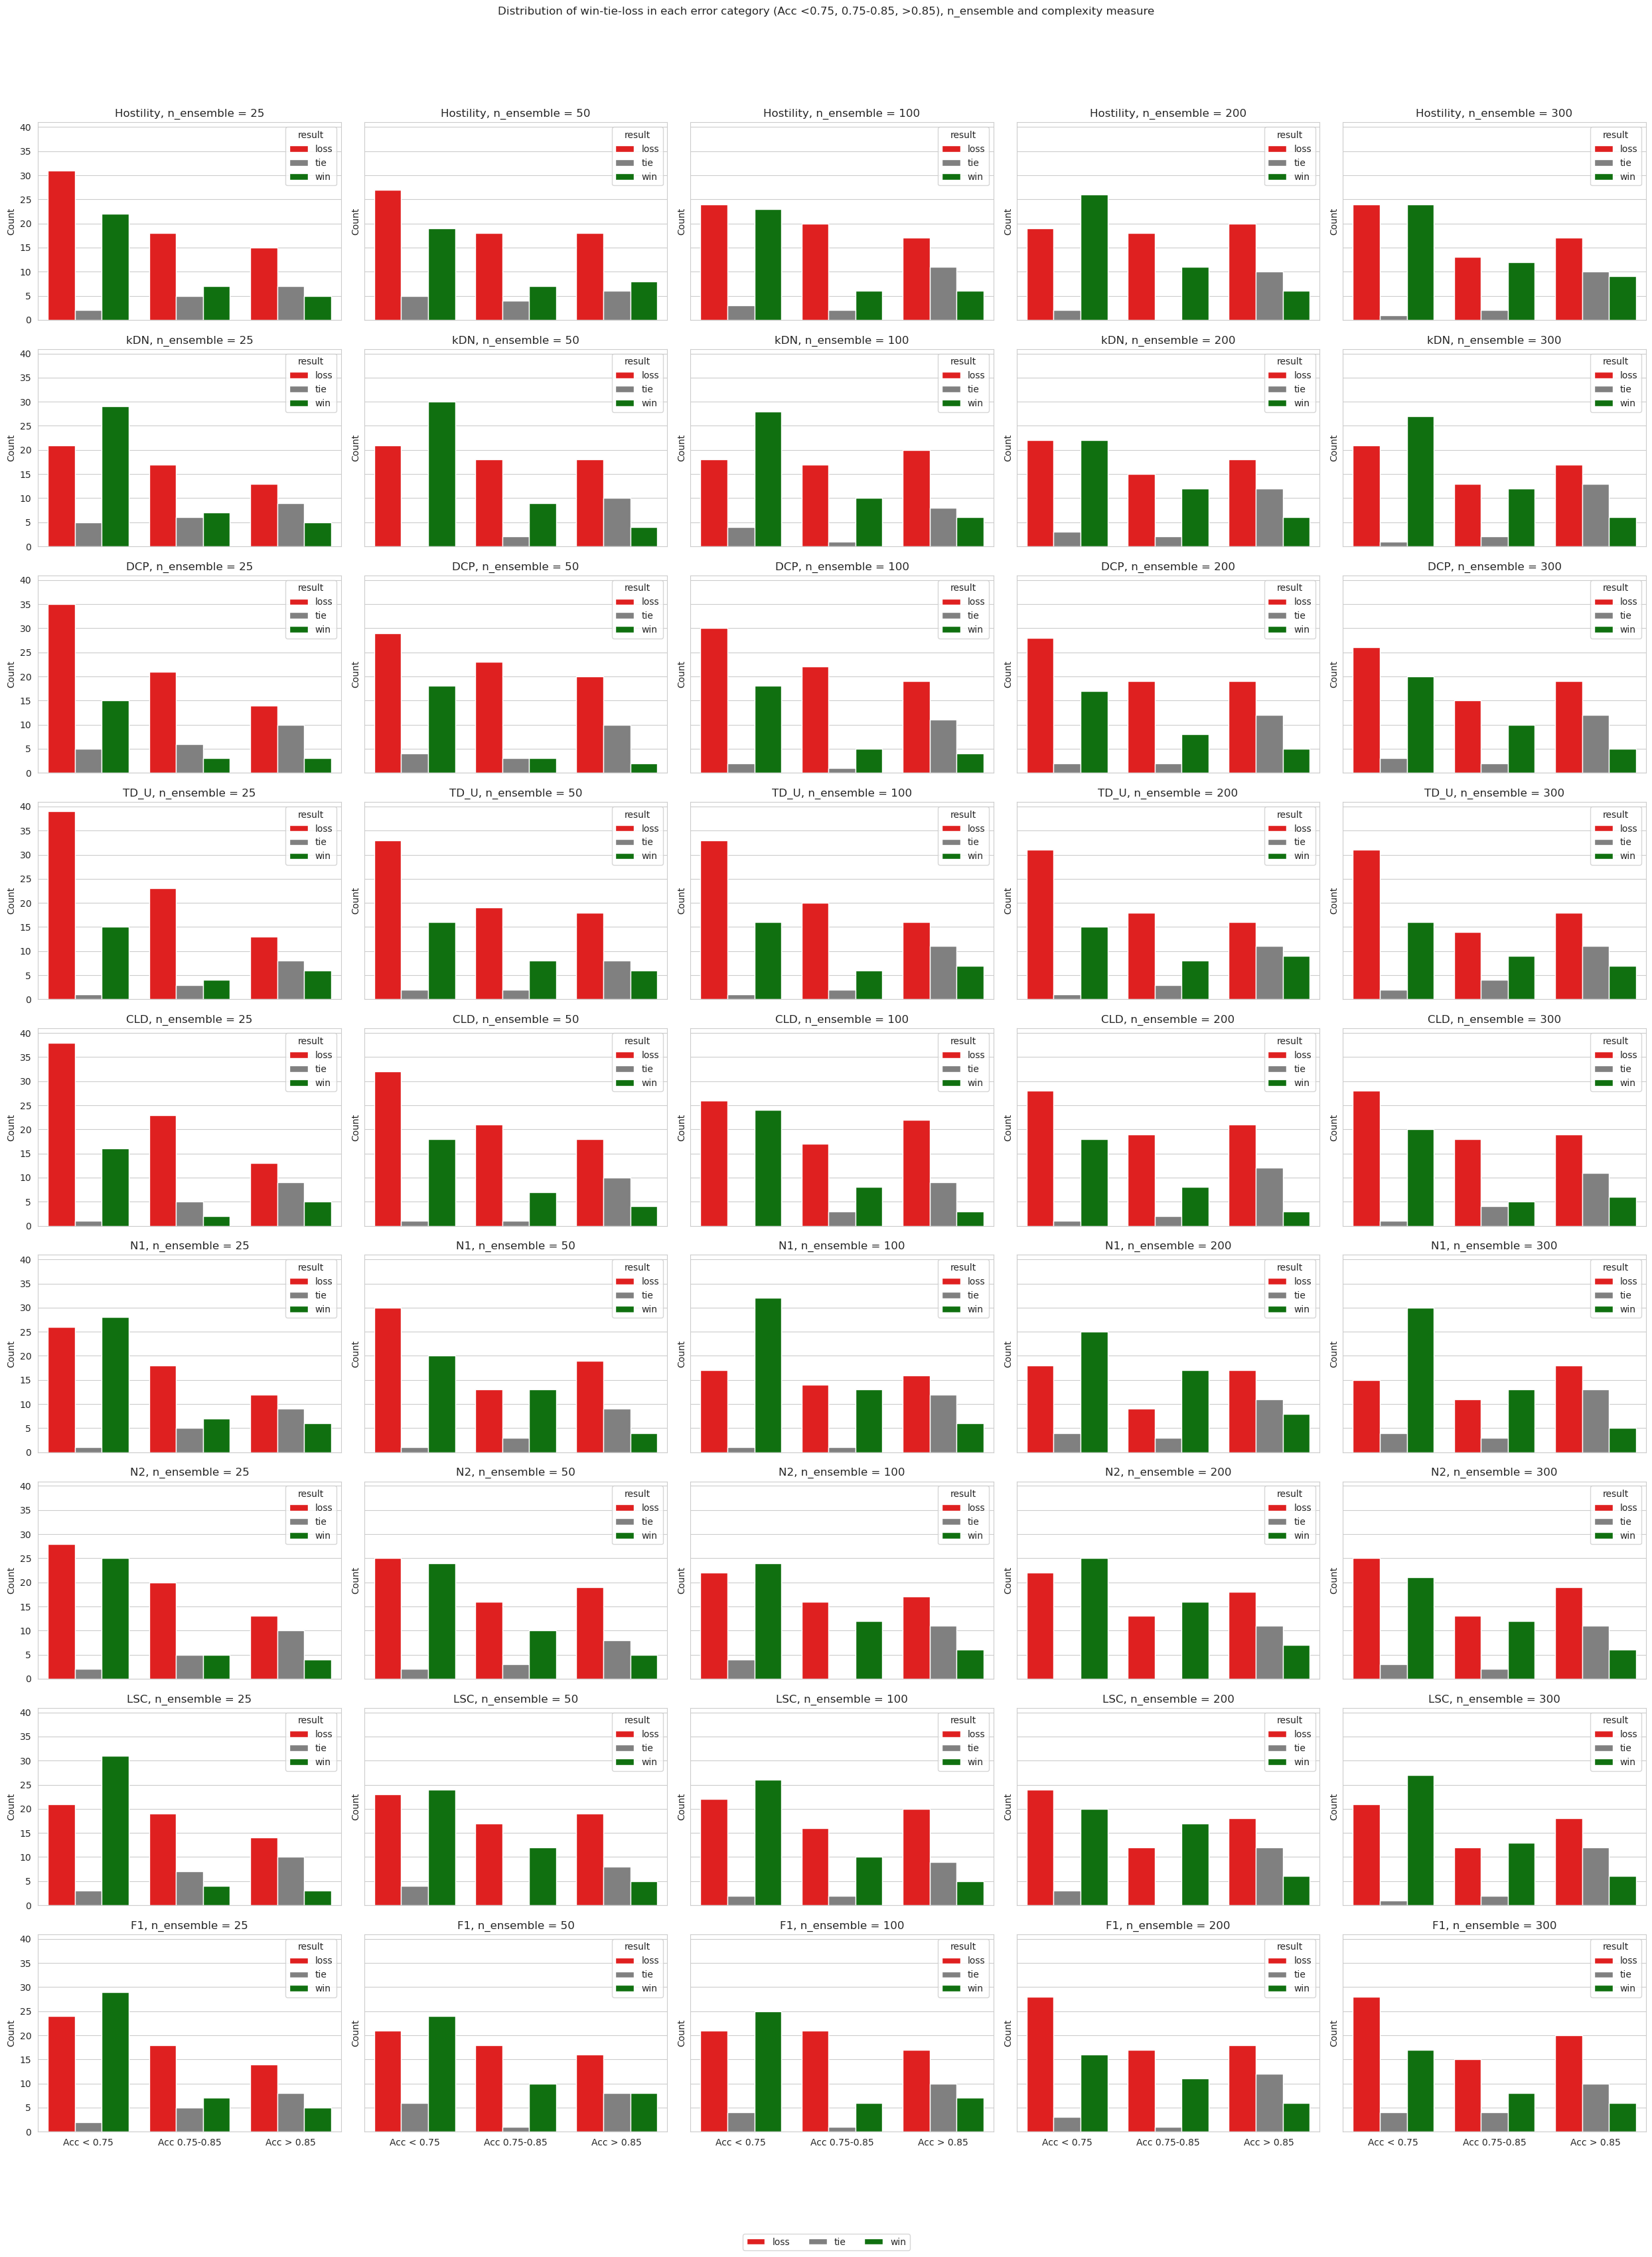

In [19]:
n_rows = len(results_df['compl_measure'].unique())
list_n_ensembles = list([25,50,100,200,300])
n_cols = len(list_n_ensembles)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), sharex=True, sharey=True)
fig.suptitle("Distribution of win-tie-loss in each error category (Acc <0.75, 0.75-0.85, >0.85), n_ensemble and complexity measure")

# Gráfico para cada combinación de compl_measure y n_ensemble
for i, compl_measure in enumerate(results_df['compl_measure'].unique()):
    for j, n_ensemble in enumerate(list_n_ensembles):
        # Filtrar datos para el gráfico actual
        subset = distribution[
            (distribution['compl_measure'] == compl_measure) &
            (distribution['n_ensemble'] == n_ensemble)
        ]

        if subset.empty:
            continue  # Saltar combinaciones sin datos

        # Gráfico de barras apiladas
        ax = axes[i, j] if n_rows > 1 else axes[j]  # Ajuste si hay una sola fila de gráficos
        sns.barplot(
            data=subset,
            x='classic_category',
            y='count',
            hue='result',
            ax=ax,
            palette={'win': 'green', 'tie': 'grey', 'loss': 'red'},
            order=labels
        )
        ax.set_title(f'{compl_measure}, n_ensemble = {n_ensemble}')
        ax.set_xlabel('')
        ax.set_ylabel('Count')

# Ajustar la leyenda y el diseño
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 0.05))
fig.tight_layout(rect=[0, 0.08, 1, 0.95])

plt.show()

En el gráfico previo lo que hemos hecho ha sido analizar la distribución de win-tie-loss en función de la dificultad de los datasets. Como algunas medidas de complejidad tienen un rango difícil de interpretar (valores muy concentrados, es el caso de LSC, TD_U, F1 y CLD), lo que hemos hecho ha sido categorizar los datasets en función de la dificultad de clasificación que ha encontrado Classic GB (esto lo veo difícil de justificar de cara a un paper).

 * Con DCP, TD_U, CLD siempre perdemos (TD_U y CLD tenían difícil interpretación), es verdad que perdemos menos en los conjuntos de datos difíciles, pero perdemos.
 * LSC y F1 son de las que son difíciles de interpretar por sus valores. Sin embargo, al hacer la categorización de los datasets en función de Classic GB sí se obtienen buenos resultados. No "ganamos" en todos los casos, pero en general se ve que para los conjuntos de datos difíciles, es mejor la estrategia de utilizar las medidas de complejidad. N2 va parecida. Hostility se ve también claramente esa tendencia a ganar más cuando los datasets son difíciles pero solo ganamos en 1 ocasión (de los ensembles mostrados), funciona peor que los casos anteriores.
 * kDN y N1 ganan casi siempre, son las mejores.

¡Ojo! Un empate significa que gana realmente Classic GB porque consigue lo mismo que nosotros sin hacer nada extra y nosotros tenemos más cosas que calcular, es decir, más gasto computacional.


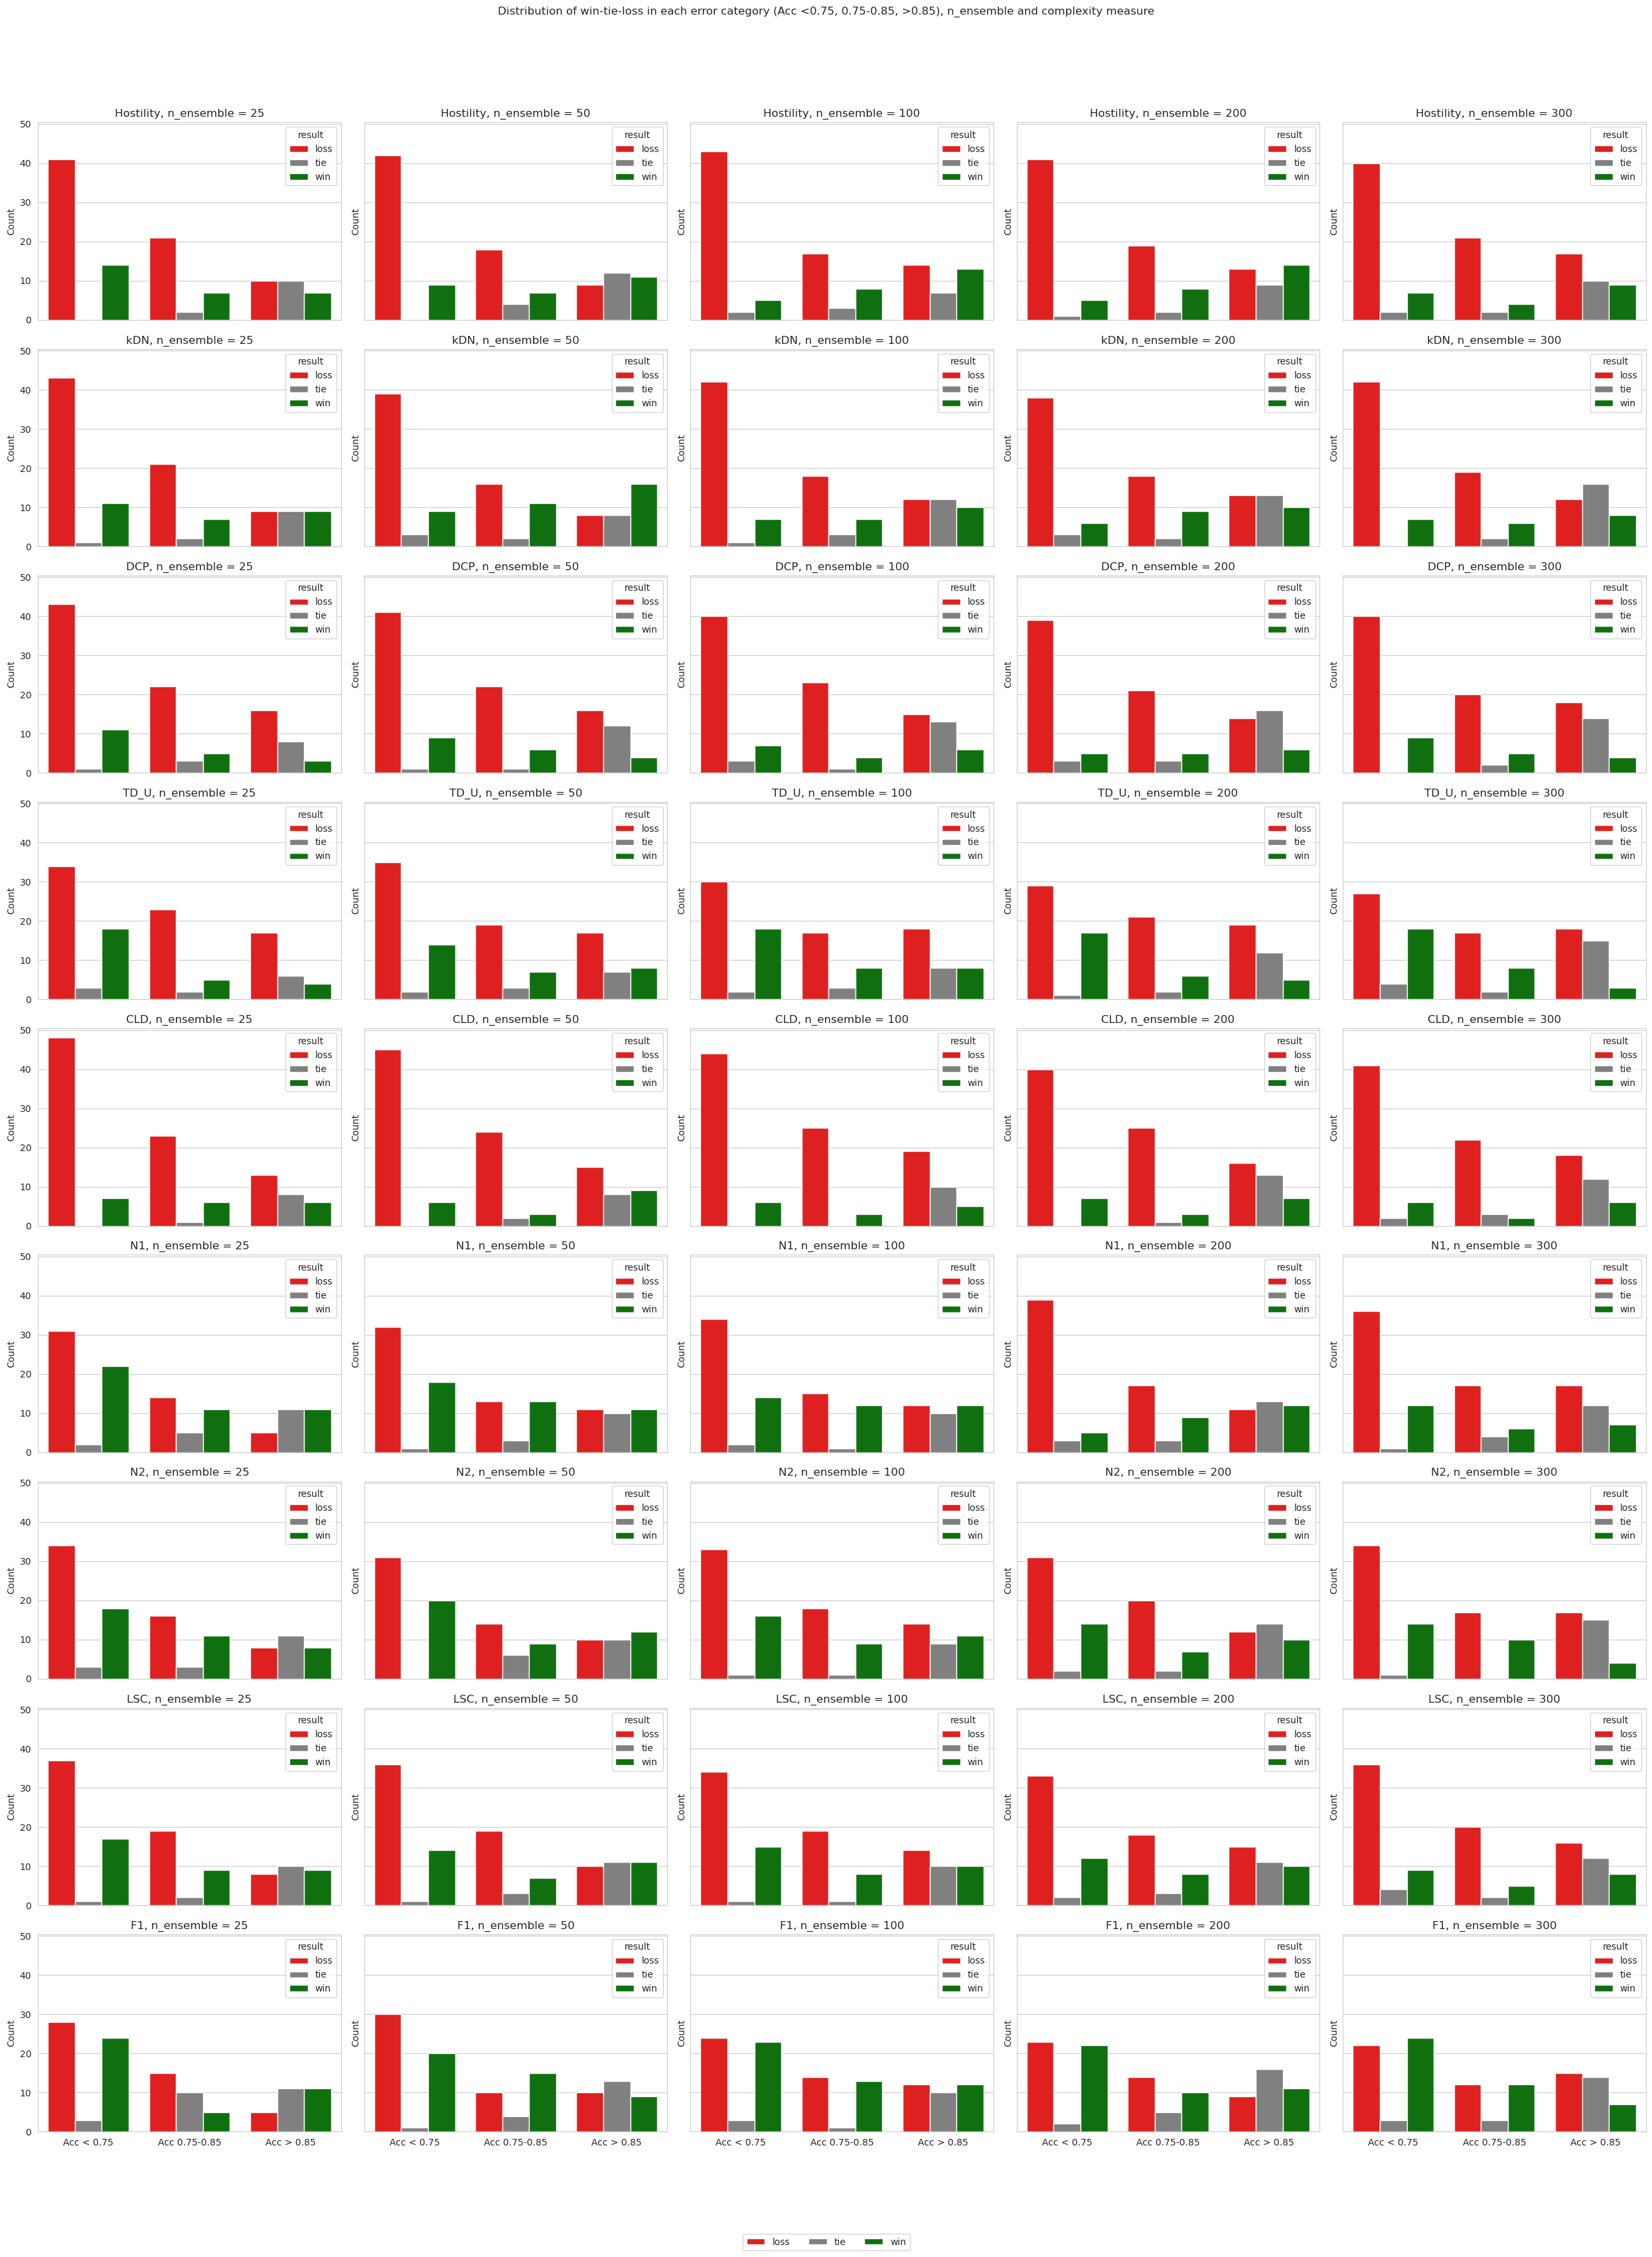

In [96]:
# Estudiamos esto mismo para el caso de sample_weight_hard
results_df_sw_hard
bins = [0, 0.75, 0.85, 1]
labels = ['Acc < 0.75', 'Acc 0.75-0.85', 'Acc > 0.85']
results_df_sw_hard['classic_category'] = pd.cut(results_df_sw_hard['classic'], bins=bins, labels=labels)

distribution = (
    results_df_sw_hard
    .groupby(['classic_category', 'n_ensemble', 'compl_measure', 'result'])
    .size()
    .reset_index(name='count')
)

distribution['proportion'] = (
    distribution['count'] /
    distribution.groupby(['classic_category', 'n_ensemble', 'compl_measure'])['count'].transform('sum')
)


n_rows = len(results_df_sw_hard['compl_measure'].unique())
list_n_ensembles = list([25,50,100,200,300])
n_cols = len(list_n_ensembles)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), sharex=True, sharey=True)
fig.suptitle("Distribution of win-tie-loss in each error category (Acc <0.75, 0.75-0.85, >0.85), n_ensemble and complexity measure")

# Gráfico para cada combinación de compl_measure y n_ensemble
for i, compl_measure in enumerate(results_df_sw_hard['compl_measure'].unique()):
    for j, n_ensemble in enumerate(list_n_ensembles):
        # Filtrar datos para el gráfico actual
        subset = distribution[
            (distribution['compl_measure'] == compl_measure) &
            (distribution['n_ensemble'] == n_ensemble)
        ]

        if subset.empty:
            continue  # Saltar combinaciones sin datos

        # Gráfico de barras apiladas
        ax = axes[i, j] if n_rows > 1 else axes[j]  # Ajuste si hay una sola fila de gráficos
        sns.barplot(
            data=subset,
            x='classic_category',
            y='count',
            hue='result',
            ax=ax,
            palette={'win': 'green', 'tie': 'grey', 'loss': 'red'},
            order=labels
        )
        ax.set_title(f'{compl_measure}, n_ensemble = {n_ensemble}')
        ax.set_xlabel('')
        ax.set_ylabel('Count')

# Ajustar la leyenda y el diseño
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 0.05))
fig.tight_layout(rect=[0, 0.08, 1, 0.95])

plt.show()

Si hacemos el mismo análisis pero usando el método sample_weight_hard vemos claramente que perdemos siempre. Esta opción no funciona y yo creo que es porque es darle al boosting más de lo que él hace y todo lo que sea "fíjate en esto que tb es difícil" que no provenga de sus derivadas va a devolver peor resultados dado que el propio método se basa en la optimización de eso.

Entonces ahora, para esos datasets difíciles según classic GB, vamos a estudiar con detalle los boxplots de medias, medianas, std, cuándo consigue cada uno el máximo, etc. Lo hacemos para 100 ensamblados y luego veo cómo generalizo. A VER SI PUEDO ESTUDIAR QUÉ MODELO SE DEGRADA MENOS, UN POCO A MODO INDICATIVO DE QUIEN SOBREAJUSTA MENOS, basicamen sería mirar quién se mantiene más estable según avanza el número de ensamblados


In [20]:
df_for_max = all_datasets.loc[(all_datasets['loss_selected'] == 'exponential') & ((all_datasets['method_weights'] == 'classic') | (all_datasets['method_weights'] == 'sample_weight_easy')),
['dataset','n_ensemble','method_weights','compl_measure','test_acc_mean','test_acc_std']]
df_for_max

dataset  n_ensemble      method_weights compl_measure  \
300      analcatdata_gviolence           1             classic          none   
301      analcatdata_gviolence           2             classic          none   
302      analcatdata_gviolence           3             classic          none   
303      analcatdata_gviolence           4             classic          none   
304      analcatdata_gviolence           5             classic          none   
...                        ...         ...                 ...           ...   
2470195        chscase_census2         296  sample_weight_easy            F1   
2470196        chscase_census2         297  sample_weight_easy            F1   
2470197        chscase_census2         298  sample_weight_easy            F1   
2470198        chscase_census2         299  sample_weight_easy            F1   
2470199        chscase_census2         300  sample_weight_easy            F1   

         test_acc_mean  test_acc_std  
300           0.580357      0.037881  
301           0.921429      0.159542  
302           0.971429      0.060234  
303           0.971429      0.060234  
304           0.971429      0.060234  
...                ...           ...  
2470195       0.492500      0.060150  
2470196       0.492500      0.056581  
2470197       0.492500      0.060150  
2470198       0.492500      0.060150  
2470199       0.487500      0.058035  

[336000 rows x 6 columns]

In [21]:
# Agrupar por dataset, method_weights y compl_measure, y encontrar el máximo de test_acc_mean y el n_ensemble correspondiente
max_performance = (
    df_for_max
    .groupby(['dataset', 'method_weights', 'compl_measure'], as_index=False)
    .apply(lambda group: group.loc[group['test_acc_mean'].idxmax(), ['dataset', 'method_weights', 'compl_measure', 'n_ensemble', 'test_acc_mean']])
    .reset_index(drop=True)
)

# Renombrar las columnas
max_performance.rename(columns={
    'n_ensemble': 'n_ensemble_max',
    'test_acc_mean': 'test_acc_mean_max'
}, inplace=True)

max_performance

dataset      method_weights compl_measure  n_ensemble_max  \
0     Australian             classic          none             159   
1     Australian  sample_weight_easy           CLD             215   
2     Australian  sample_weight_easy           DCP             252   
3     Australian  sample_weight_easy            F1              61   
4     Australian  sample_weight_easy     Hostility             109   
...          ...                 ...           ...             ...   
1115         zoo  sample_weight_easy           LSC               3   
1116         zoo  sample_weight_easy            N1               3   
1117         zoo  sample_weight_easy            N2               2   
1118         zoo  sample_weight_easy          TD_U               3   
1119         zoo  sample_weight_easy           kDN               3   

      test_acc_mean_max  
0              0.872464  
1              0.872464  
2              0.871014  
3              0.873913  
4              0.873913  
...                 ...  
1115           1.000000  
1116           1.000000  
1117           1.000000  
1118           1.000000  
1119           1.000000  

[1120 rows x 5 columns]

In [22]:
# Categorizar la dificultad (aquí estamos categorizando en función del máximo accuracy que logra classic GB)
max_performance['classic_category'] = pd.cut(
    max_performance.loc[max_performance['method_weights'] == 'classic', 'test_acc_mean_max'],
    bins = [0, 0.75, 0.85, 1],
    labels = ['Acc < 0.75', 'Acc 0.75-0.85', 'Acc > 0.85'],
    include_lowest=True
)

# Crear un dataframe intermedio con las categorías solo para el métod clásico
classic_categories = max_performance[max_performance['method_weights'] == 'classic'][['dataset', 'compl_measure', 'classic_category']]

# Asegurarnos de no tener duplicados en las categorías
classic_categories = classic_categories.drop_duplicates(subset=['dataset'])

# Merge para asignar la categoría a todos los métodos
max_performance = max_performance.merge(
    classic_categories[['dataset', 'classic_category']],
    on=['dataset'],
    how='left'
)
max_performance.drop('classic_category_x', axis=1, inplace=True)


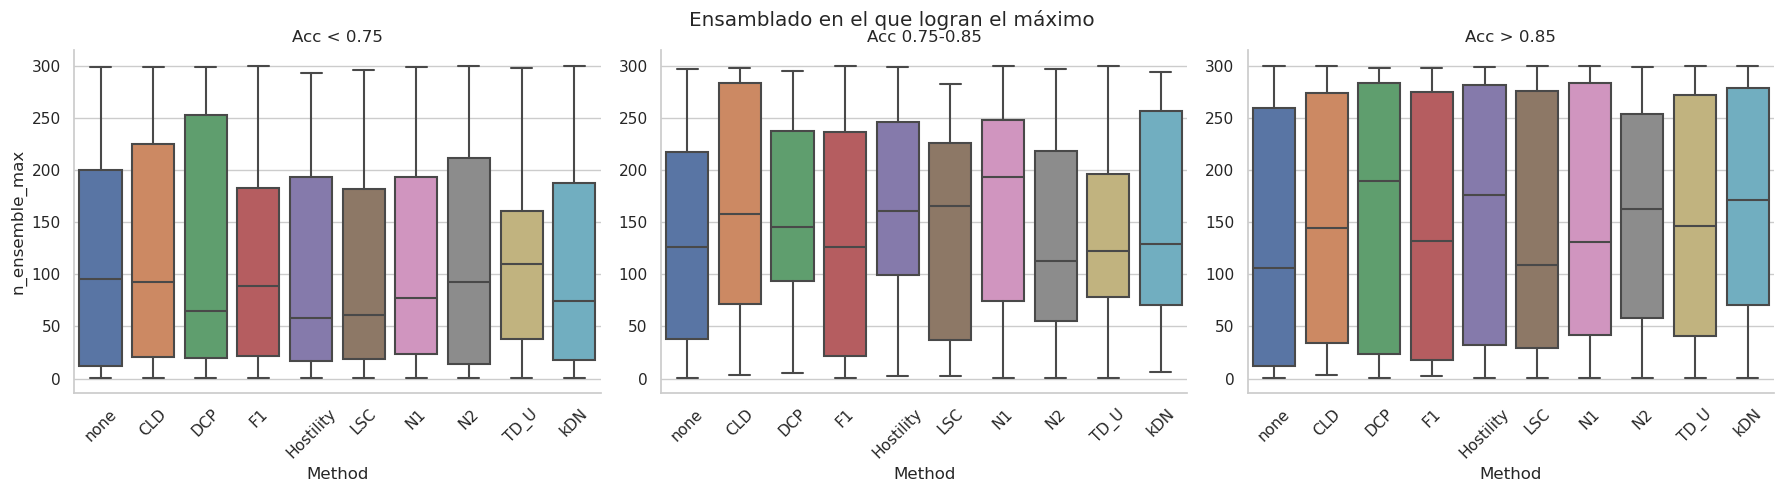

In [27]:
# Configuración del estilo del gráfico
sns.set(style="whitegrid")

# Crear un gráfico por cada categoría de classic_category
g = sns.catplot(
    data=max_performance,
    x="compl_measure",
    y="n_ensemble_max",
    #hue="compl_measure",  # Colorea por medida de complejidad
    col="classic_category_y",  # Divide por categoría de dificultad
    kind="box",
    sharey=False,  # Permite que cada gráfico tenga su propio rango en y
    height=5,
    aspect=1.2
)

# Personalizar el título y ejes
g.set_titles("{col_name}")  # Títulos basados en categorías
g.set_axis_labels("Method", "n_ensemble_max")
g.set_xticklabels(rotation=45)
g.tight_layout()
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Ensamblado en el que logran el máximo')

# Mostrar el gráfico
plt.show()

In [30]:
# lo vemos numéricamente
boxplot_stats = (
    max_performance
    .groupby(["classic_category_y", "compl_measure"])["n_ensemble_max"]
    .describe()[["min", "25%", "50%", "75%", "max"]]
    .rename(columns={"25%": "Q1", "50%": "median", "75%": "Q3"})
    .reset_index()
)

boxplot_stats

classic_category_y compl_measure  min     Q1  median      Q3    max
0          Acc < 0.75           CLD  1.0  20.25    92.5  224.50  299.0
1          Acc < 0.75           DCP  1.0  19.75    64.5  252.25  299.0
2          Acc < 0.75            F1  1.0  22.00    88.5  182.75  300.0
3          Acc < 0.75     Hostility  1.0  16.50    58.0  192.75  293.0
4          Acc < 0.75           LSC  1.0  19.00    61.0  182.00  296.0
5          Acc < 0.75            N1  1.0  24.00    77.0  193.00  299.0
6          Acc < 0.75            N2  1.0  14.25    93.0  211.50  300.0
7          Acc < 0.75          TD_U  1.0  38.00   110.0  161.00  298.0
8          Acc < 0.75           kDN  1.0  18.00    74.0  187.00  300.0
9          Acc < 0.75          none  1.0  11.75    95.0  199.50  299.0
10      Acc 0.75-0.85           CLD  3.0  71.25   157.5  283.25  298.0
11      Acc 0.75-0.85           DCP  5.0  93.25   145.5  237.50  295.0
12      Acc 0.75-0.85            F1  1.0  21.50   126.5  236.50  300.0
13      Acc 0.75-0.85     Hostility  2.0  99.50   160.5  246.25  299.0
14      Acc 0.75-0.85           LSC  2.0  36.50   165.0  225.50  282.0
15      Acc 0.75-0.85            N1  1.0  74.75   193.0  248.25  300.0
16      Acc 0.75-0.85            N2  1.0  54.75   113.0  217.75  297.0
17      Acc 0.75-0.85          TD_U  1.0  78.00   122.5  196.50  300.0
18      Acc 0.75-0.85           kDN  6.0  70.25   129.0  256.50  294.0
19      Acc 0.75-0.85          none  1.0  37.75   126.0  216.75  297.0
20         Acc > 0.85           CLD  3.0  34.25   144.0  274.00  300.0
21         Acc > 0.85           DCP  1.0  24.00   189.0  283.75  298.0
22         Acc > 0.85            F1  2.0  17.50   132.0  275.00  298.0
23         Acc > 0.85     Hostility  1.0  32.50   176.0  281.25  299.0
24         Acc > 0.85           LSC  1.0  29.00   109.0  275.75  300.0
25         Acc > 0.85            N1  1.0  41.75   130.5  283.50  300.0
26         Acc > 0.85            N2  1.0  57.75   163.0  253.75  299.0
27         Acc > 0.85          TD_U  1.0  41.00   146.5  271.75  300.0
28         Acc > 0.85           kDN  1.0  70.50   171.0  278.75  300.0
29         Acc > 0.85          none  1.0  12.50   105.5  259.00  300.0

In [30]:
max_performance.head()
max_performance['classic_category_y'].value_counts()/10


Acc < 0.75       44.0
Acc > 0.85       38.0
Acc 0.75-0.85    30.0
Name: classic_category_y, dtype: float64

None es el método GB clásico. No es hiper significativo, pero sí obtenemos el máximo (en general) para un número menor de ensamblados. Nos estamos fijando en la categoría Acc < 0.75 que contiene un total de 44 datasets.


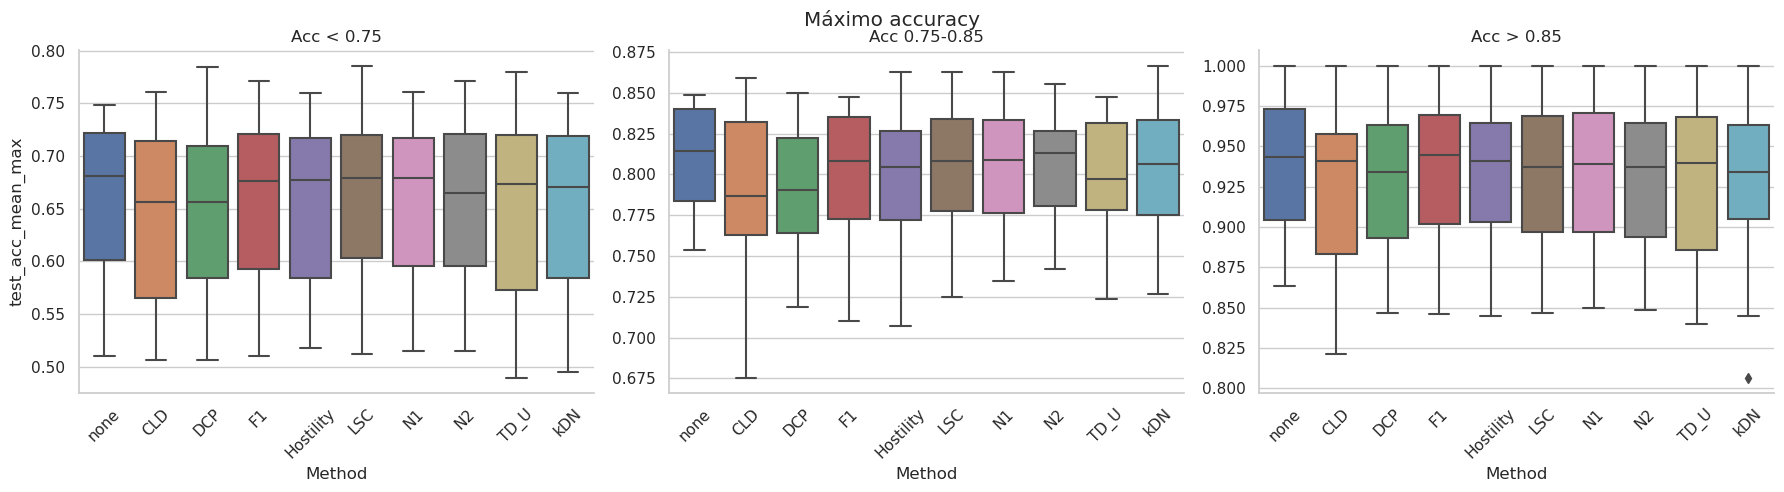

In [28]:
# Configuración del estilo del gráfico
sns.set(style="whitegrid")

# Crear un gráfico por cada categoría de classic_category
g = sns.catplot(
    data=max_performance,
    x="compl_measure",
    y="test_acc_mean_max",
    #hue="compl_measure",  # Colorea por medida de complejidad
    col="classic_category_y",  # Divide por categoría de dificultad
    kind="box",
    sharey=False,  # Permite que cada gráfico tenga su propio rango en y
    height=5,
    aspect=1.2
)

# Personalizar el título y ejes
g.set_titles("{col_name}")  # Títulos basados en categorías
g.set_axis_labels("Method", "test_acc_mean_max")
g.set_xticklabels(rotation=45)
g.tight_layout()
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Máximo accuracy')


# Mostrar el gráfico
plt.show()

In [29]:
# lo vemos numéricamente
boxplot_stats = (
    max_performance
    .groupby(["classic_category_y", "compl_measure"])["test_acc_mean_max"]
    .describe()[["min", "25%", "50%", "75%", "max"]]
    .rename(columns={"25%": "Q1", "50%": "median", "75%": "Q3"})
    .reset_index()
)

boxplot_stats

classic_category_y compl_measure       min        Q1    median        Q3  \
0          Acc < 0.75           CLD  0.506524  0.565691  0.656031  0.713800   
1          Acc < 0.75           DCP  0.506128  0.584762  0.656804  0.709921   
2          Acc < 0.75            F1  0.510000  0.592581  0.676574  0.720758   
3          Acc < 0.75     Hostility  0.518128  0.584028  0.677447  0.717046   
4          Acc < 0.75           LSC  0.512500  0.602875  0.679262  0.720114   
5          Acc < 0.75            N1  0.515000  0.595375  0.678798  0.716714   
6          Acc < 0.75            N2  0.515000  0.595375  0.664909  0.720771   
7          Acc < 0.75          TD_U  0.490000  0.573227  0.673234  0.719496   
8          Acc < 0.75           kDN  0.495000  0.584028  0.670403  0.719330   
9          Acc < 0.75          none  0.510000  0.601375  0.681372  0.722222   
10      Acc 0.75-0.85           CLD  0.675546  0.762782  0.786689  0.832177   
11      Acc 0.75-0.85           DCP  0.718824  0.764099  0.790175  0.822419   
12      Acc 0.75-0.85            F1  0.710000  0.772512  0.808168  0.834946   
13      Acc 0.75-0.85     Hostility  0.707143  0.771857  0.804701  0.826452   
14      Acc 0.75-0.85           LSC  0.725000  0.777275  0.808424  0.834137   
15      Acc 0.75-0.85            N1  0.734722  0.776197  0.809085  0.833326   
16      Acc 0.75-0.85            N2  0.742185  0.780341  0.813120  0.826329   
17      Acc 0.75-0.85          TD_U  0.723611  0.778326  0.797477  0.831290   
18      Acc 0.75-0.85           kDN  0.726667  0.774988  0.806373  0.833635   
19      Acc 0.75-0.85          none  0.753697  0.783929  0.814394  0.839884   
20         Acc > 0.85           CLD  0.821144  0.883112  0.940833  0.957892   
21         Acc > 0.85           DCP  0.846543  0.893415  0.933743  0.963396   
22         Acc > 0.85            F1  0.846321  0.901563  0.944727  0.969400   
23         Acc > 0.85     Hostility  0.844592  0.903202  0.940597  0.964428   
24         Acc > 0.85           LSC  0.846410  0.896562  0.937211  0.968571   
25         Acc > 0.85            N1  0.850000  0.896911  0.938891  0.970565   
26         Acc > 0.85            N2  0.848670  0.894062  0.936976  0.964498   
27         Acc > 0.85          TD_U  0.840000  0.885943  0.939436  0.967831   
28         Acc > 0.85           kDN  0.806667  0.904797  0.934083  0.962876   
29         Acc > 0.85          none  0.863333  0.904122  0.943348  0.973351   

         max  
0   0.761111  
1   0.783929  
2   0.771429  
3   0.760000  
4   0.785714  
5   0.760714  
6   0.771429  
7   0.780000  
8   0.760000  
9   0.748421  
10  0.859259  
11  0.850000  
12  0.847368  
13  0.862963  
14  0.862963  
15  0.862963  
16  0.855556  
17  0.847368  
18  0.866667  
19  0.848387  
20  1.000000  
21  1.000000  
22  1.000000  
23  1.000000  
24  1.000000  
25  1.000000  
26  1.000000  
27  1.000000  
28  1.000000  
29  1.000000

En mediana, Q1 y Q3 lo mejor es Classic GB, en mínimo y en máximo no.

Vamos a repetir el estudio de arriba (boxplots y win-tie-loss) pero para la categoría de Acc <0.75 definida por Classic GB.

In [31]:
df_for_max

dataset  n_ensemble      method_weights compl_measure  \
300      analcatdata_gviolence           1             classic          none   
301      analcatdata_gviolence           2             classic          none   
302      analcatdata_gviolence           3             classic          none   
303      analcatdata_gviolence           4             classic          none   
304      analcatdata_gviolence           5             classic          none   
...                        ...         ...                 ...           ...   
2470195        chscase_census2         296  sample_weight_easy            F1   
2470196        chscase_census2         297  sample_weight_easy            F1   
2470197        chscase_census2         298  sample_weight_easy            F1   
2470198        chscase_census2         299  sample_weight_easy            F1   
2470199        chscase_census2         300  sample_weight_easy            F1   

         test_acc_mean  test_acc_std  
300           0.580357      0.037881  
301           0.921429      0.159542  
302           0.971429      0.060234  
303           0.971429      0.060234  
304           0.971429      0.060234  
...                ...           ...  
2470195       0.492500      0.060150  
2470196       0.492500      0.056581  
2470197       0.492500      0.060150  
2470198       0.492500      0.060150  
2470199       0.487500      0.058035  

[336000 rows x 6 columns]

In [32]:
classic_categories.drop(['compl_measure'], axis=1, inplace=True)
# Añadimos la ctegorización al dataset filtrado (para tener solo exponential loss, sample_weitght_easy y classic)
df_hardGB = df_for_max.merge(
    classic_categories[['dataset', 'classic_category']],
    on=['dataset'],
    how='left'
)


In [33]:
df_hardGB2 = df_hardGB.loc[df_hardGB['classic_category']=='Acc < 0.75',:]
df_hardGB2

dataset  n_ensemble      method_weights compl_measure  \
6000    diabetic_retinopathy           1             classic          none   
6001    diabetic_retinopathy           2             classic          none   
6002    diabetic_retinopathy           3             classic          none   
6003    diabetic_retinopathy           4             classic          none   
6004    diabetic_retinopathy           5             classic          none   
...                      ...         ...                 ...           ...   
335995       chscase_census2         296  sample_weight_easy            F1   
335996       chscase_census2         297  sample_weight_easy            F1   
335997       chscase_census2         298  sample_weight_easy            F1   
335998       chscase_census2         299  sample_weight_easy            F1   
335999       chscase_census2         300  sample_weight_easy            F1   

        test_acc_mean  test_acc_std classic_category  
6000         0.530840      0.001280       Acc < 0.75  
6001         0.530840      0.001280       Acc < 0.75  
6002         0.530840      0.001280       Acc < 0.75  
6003         0.530840      0.001280       Acc < 0.75  
6004         0.597699      0.054993       Acc < 0.75  
...               ...           ...              ...  
335995       0.492500      0.060150       Acc < 0.75  
335996       0.492500      0.056581       Acc < 0.75  
335997       0.492500      0.060150       Acc < 0.75  
335998       0.492500      0.060150       Acc < 0.75  
335999       0.487500      0.058035       Acc < 0.75  

[132000 rows x 7 columns]

In [34]:
len(df_hardGB2.dataset.unique())

44

In [35]:
all_datasets.shape
len(all_datasets.dataset.unique())

112

Adaptamos las funciones de win-tie-loss y de los boxplots

In [36]:
# Cogemos la función WTL del otro script
def win_tie_loss_comparison_info_complexity_hardGB(data, complexity_df, main_method, compare_method, metric='test_acc_mean',
                                            n_ensemble_values=[10, 25, 50, 100, 150, 200, 250, 300]):
    """
    Realiza un análisis win-tie-loss comparando el método principal con otro método específico para cada medida de complejidad.

    Parameters:
    - data: DataFrame con las columnas ['dataset', 'n_ensemble', 'method_weights', 'compl_measure', metric]
    - main_method: método principal que se desea comparar (ejemplo: 'classic')
    - compare_method: método específico con el cual comparar el principal (ejemplo: 'init_easy')
    - metric: métrica de comparación (por defecto 'test_acc_mean')
    - n_ensemble_values: valores de n_ensemble a considerar

    Returns:
    - Una tabla con el conteo de wins, ties, y losses por cada valor de n_ensemble y medida de complejidad.
    """
    results = []
    # Crear una lista para almacenar los resultados
    all_results = []
    value_wtl = 'nada'

    for n in n_ensemble_values:
        # Filtrar los datos para el valor actual de n_ensemble
        subset_n = data[(data['n_ensemble'] == n)]


        # Crear un diccionario para almacenar los resultados de esta combinación de n_ensemble
        row = {'n_ensemble': n}

        CM_list = subset_n['compl_measure'].unique()[1:] # to delete none

        for compl in CM_list:
            win, tie, loss = 0, 0, 0

            # Filtrar los datos para la medida de complejidad actual
            subset_compl = subset_n[subset_n['compl_measure'] == compl]
            #if (main_method == 'classic') or (compare_method == 'classic'):
            #     subset_compl_main = subset_n[subset_n['compl_measure'] == 'none']

            for dataset in subset_compl['dataset'].unique():
                # Filtrar para el dataset y métod en cuestión

                if (main_method == 'classic'):
                    subset_compl_main = subset_n[subset_n['compl_measure'] == 'none']
                    main_value = subset_compl_main[(subset_compl_main['dataset'] == dataset) & (subset_compl_main['method_weights'] == main_method)][metric].values
                else:
                    main_value = subset_compl[(subset_compl['dataset'] == dataset) & (subset_compl['method_weights'] == main_method)][metric].values
                if (compare_method == 'classic'):
                    subset_compl_compare = subset_n[subset_n['compl_measure'] == 'none']
                    compare_value = subset_compl_compare[(subset_compl_compare['dataset'] == dataset) & (subset_compl_compare['method_weights'] == compare_method)][metric].values
                else:
                    compare_value = subset_compl[(subset_compl['dataset'] == dataset) & (subset_compl['method_weights'] == compare_method)][metric].values

                # Verificar que tenemos valores únicos para cada dataset y métod
                if main_value.size > 0 and compare_value.size > 0:
                    main_value = main_value[0]
                    compare_value = compare_value[0]

                    # Comparación win-tie-loss
                    if main_value < compare_value:
                        win += 1
                        value_wtl = 'win'
                    elif main_value == compare_value:
                        tie += 1
                        value_wtl = 'tie'
                    else:
                        loss += 1
                        value_wtl = 'loss'

                # Obtener las medidas de complejidad para el dataset
                complexity_values = complexity_df[complexity_df['dataset'] == dataset][compl].values
                if complexity_values.size > 0:
                    complexity_value = complexity_values[0]

                    # Almacenar los resultados en una lista de diccionarios
                    all_results.append({
                        'n_ensemble': n,
                        'compl_measure': compl,
                        'result': value_wtl,
                        'complexity_value': complexity_value,
                        'dataset_name':dataset,
                        main_method:main_value,
                        compare_method:compare_value
                    })

            # Guardar el resultado para esta medida de complejidad en una columna específica
            row[f'{compare_method}_{compl}'] = (win, tie, loss)

        # Agregar el resultado de esta iteración a los resultados
        results.append(row)

    # Convertir los resultados a DataFrame
    win_tie_loss_df = pd.DataFrame(results)

    return win_tie_loss_df, all_results


In [37]:
win_tie_loss_df_hardGB, all_results_df_hardGB = win_tie_loss_comparison_info_complexity_hardGB(df_hardGB2, df_complex, main_method='classic', compare_method='sample_weight_easy')
win_tie_loss_df_hardGB

n_ensemble sample_weight_easy_Hostility sample_weight_easy_kDN  \
0          10                  (21, 5, 18)            (21, 9, 14)   
1          25                  (18, 1, 25)            (25, 2, 17)   
2          50                  (18, 4, 22)            (27, 0, 17)   
3         100                  (21, 3, 20)            (25, 2, 17)   
4         150                  (21, 1, 22)            (24, 0, 20)   
5         200                  (24, 2, 18)            (21, 1, 22)   
6         250                  (20, 2, 22)            (20, 3, 21)   
7         300                  (21, 1, 22)            (23, 1, 20)   

  sample_weight_easy_DCP sample_weight_easy_TD_U sample_weight_easy_CLD  \
0            (15, 6, 23)             (11, 7, 26)            (15, 8, 21)   
1            (14, 5, 25)             (13, 1, 30)            (13, 0, 31)   
2            (16, 4, 24)             (13, 1, 30)            (14, 0, 30)   
3            (16, 2, 26)             (14, 1, 29)            (20, 0, 24)   
4            (16, 0, 28)              (9, 2, 33)            (16, 3, 25)   
5            (17, 2, 25)             (13, 1, 30)            (17, 0, 27)   
6            (16, 4, 24)             (13, 3, 28)            (16, 2, 26)   
7            (19, 2, 23)             (13, 2, 29)            (17, 1, 26)   

  sample_weight_easy_N1 sample_weight_easy_N2 sample_weight_easy_LSC  \
0           (22, 8, 14)           (18, 6, 20)            (25, 6, 13)   
1           (22, 1, 21)           (19, 2, 23)            (24, 3, 17)   
2           (17, 1, 26)           (22, 2, 20)            (22, 3, 19)   
3           (28, 1, 15)           (21, 2, 21)            (22, 2, 20)   
4           (22, 2, 20)           (20, 2, 22)            (20, 2, 22)   
5           (24, 3, 17)           (24, 0, 20)            (19, 3, 22)   
6           (28, 2, 14)           (21, 3, 20)            (21, 4, 19)   
7           (27, 4, 13)           (18, 3, 23)            (24, 1, 19)   

  sample_weight_easy_F1  
0          (16, 11, 17)  
1           (22, 2, 20)  
2           (21, 4, 19)  
3           (22, 4, 18)  
4           (15, 6, 23)  
5           (15, 3, 26)  
6           (15, 4, 25)  
7           (14, 4, 26)

In [38]:
def summaryStatistics_HardGB_perCM(df_hardGB2,CM):
    all_datasets_CM = df_hardGB2.loc[((df_hardGB2.compl_measure == CM) | (df_hardGB2.compl_measure == 'none')),:]


    summary_results_low = all_datasets_CM.groupby(['dataset', 'method_weights']).agg(
            test_acc_mean_median=('test_acc_mean', 'median'),
            test_acc_mean_std=('test_acc_mean', 'std'),
            test_acc_mean_total_mean=('test_acc_mean', 'mean')
        ).reset_index()
    summary_results_low

    # Pivotar para obtener una tabla más organizada
    summary_pivot_low = summary_results_low.pivot(index='dataset', columns='method_weights',
                                              values=['test_acc_mean_median', 'test_acc_mean_std', 'test_acc_mean_total_mean'])

    # Renombrar columnas para que sean más fáciles de leer
    summary_pivot_low.columns = [f'{method}_{stat}' for stat, method in summary_pivot_low.columns]
    summary_pivot_low.reset_index(inplace=True)

    # Plots
    # Low complexity dataset
    summary_long_low = summary_pivot_low.melt(id_vars='dataset',
                                             value_vars=[
                                                'classic_test_acc_mean_median',
                                                'sample_weight_easy_test_acc_mean_median',
                                                'classic_test_acc_mean_std',
                                                'sample_weight_easy_test_acc_mean_std',
                                                'classic_test_acc_mean_total_mean',
                                                'sample_weight_easy_test_acc_mean_total_mean',
                                            ],
                                            var_name='method_stat',
                                            value_name='value')

    # Separar los nombres de métod y estadístico
    summary_long_low[['method', 'statistic']] = summary_long_low['method_stat'].str.rsplit('_', n=1, expand=True)
    summary_long_low['method'] = summary_long_low['method'].replace({
             'classic_test_acc_mean': 'Classic',
            'sample_weight_easy_test_acc_mean': 'Easy',
            'classic_test_acc_mean_total': 'Classic',
            'sample_weight_easy_test_acc_mean_total': 'Easy',
    })


    # Crear un boxplot para cada estadístico
    plt.figure(figsize=(12, 5))

    # Usar un bucle para crear un boxplot por cada estadístico
    for i, stat in enumerate(summary_long_low['statistic'].unique(), start=1):
        plt.subplot(1, 3, i)  # 3 filas, 1 columna
        sns.boxplot(data=summary_long_low[summary_long_low['statistic'] == stat],
                         x='method',
                         y='value',
                         palette=colour_palette_personalized)

        plt.xlabel('Method')
        plt.ylabel(stat.capitalize())

    # Título global para el gráfico
    plt.suptitle('Boxplots of Summary Statistics Low accuracy Datasets '+CM, fontsize=16)


    plt.tight_layout()
    plt.show()
    return

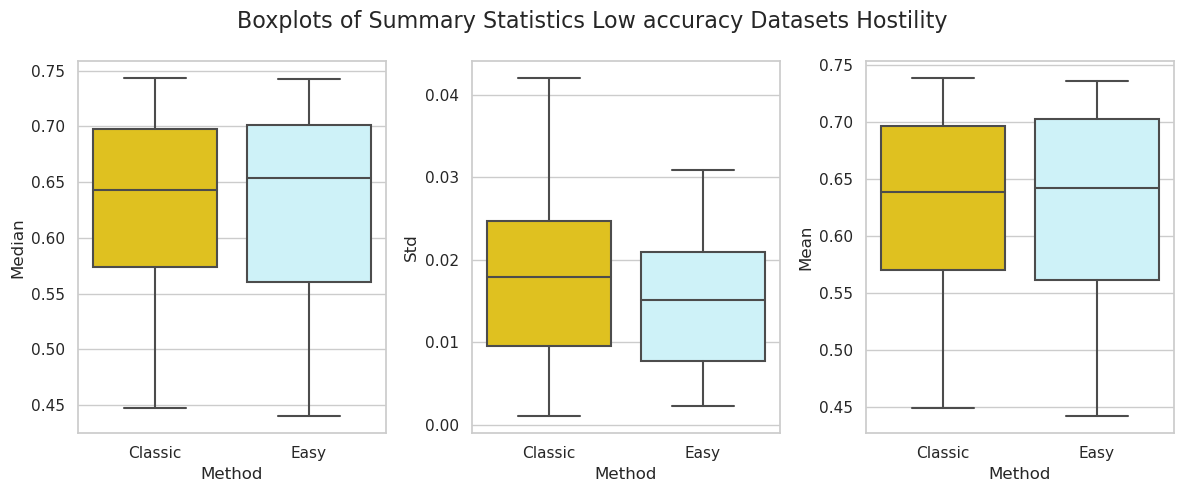

In [39]:
CM = 'Hostility'
summaryStatistics_HardGB_perCM(df_hardGB2,CM)

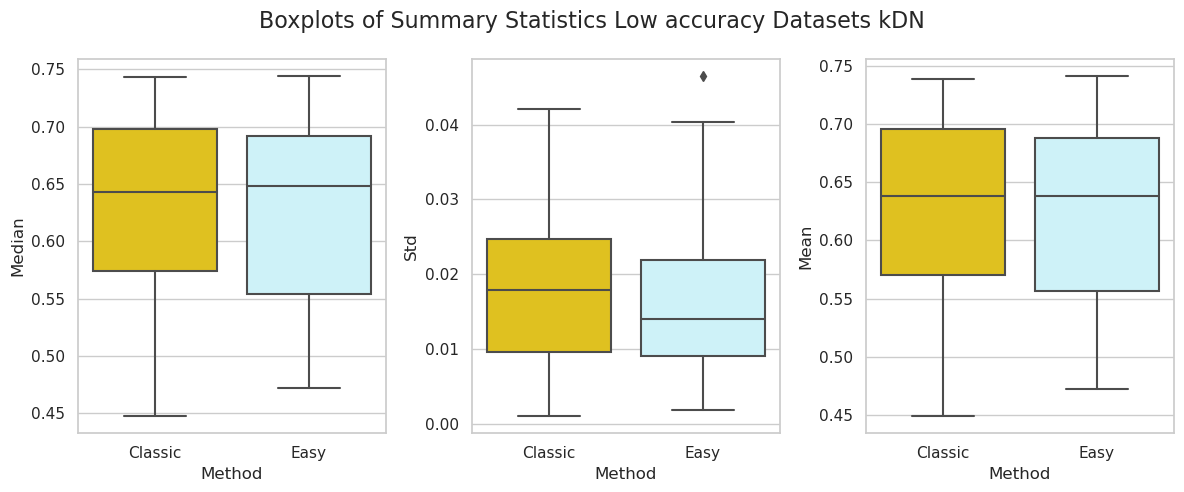

In [62]:
CM = 'kDN'
summaryStatistics_HardGB_perCM(df_hardGB2,CM)

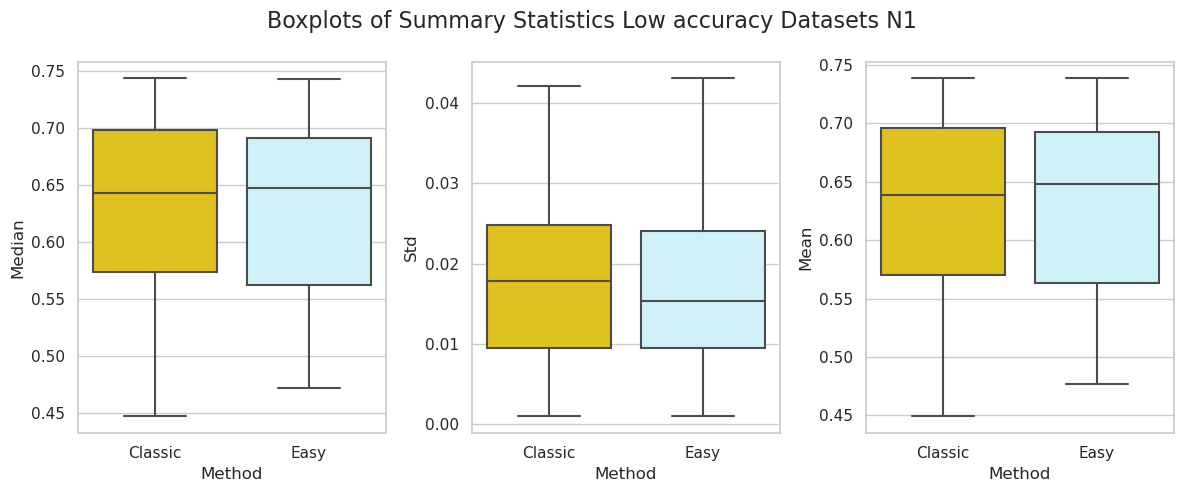

In [63]:
CM = 'N1'
summaryStatistics_HardGB_perCM(df_hardGB2,CM)

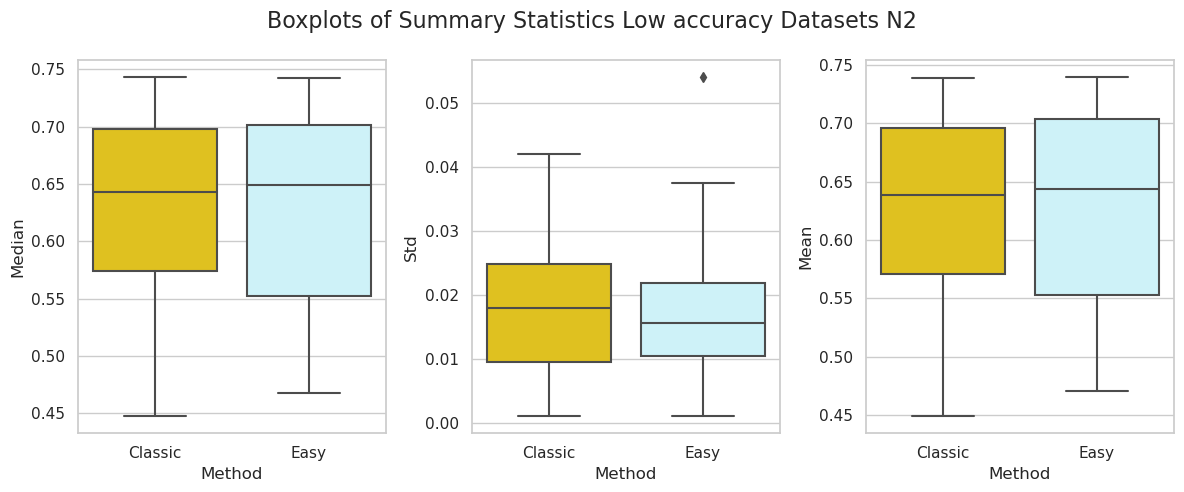

In [64]:
CM = 'N2'
summaryStatistics_HardGB_perCM(df_hardGB2,CM)

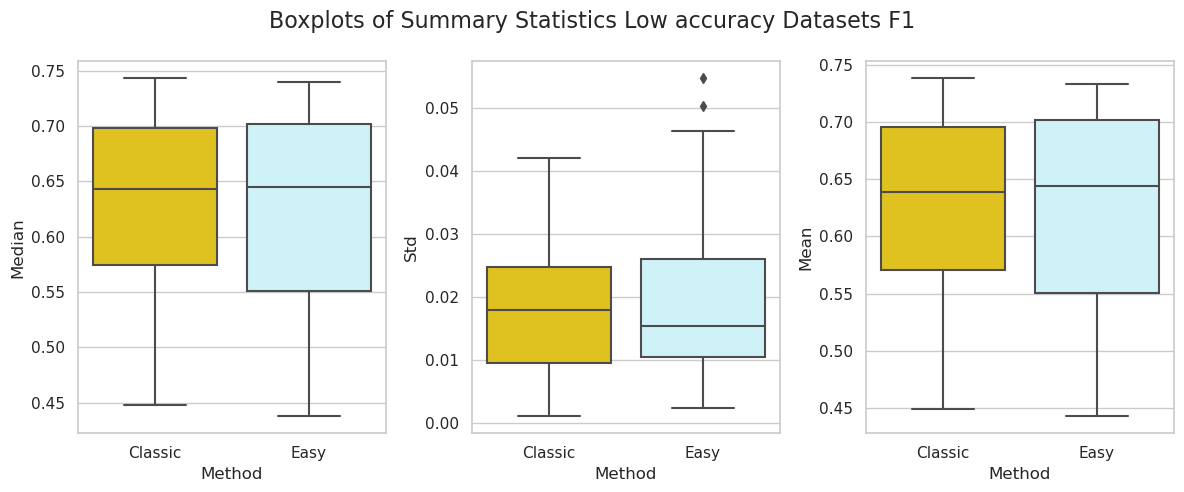

In [65]:
CM = 'F1'
summaryStatistics_HardGB_perCM(df_hardGB2,CM)

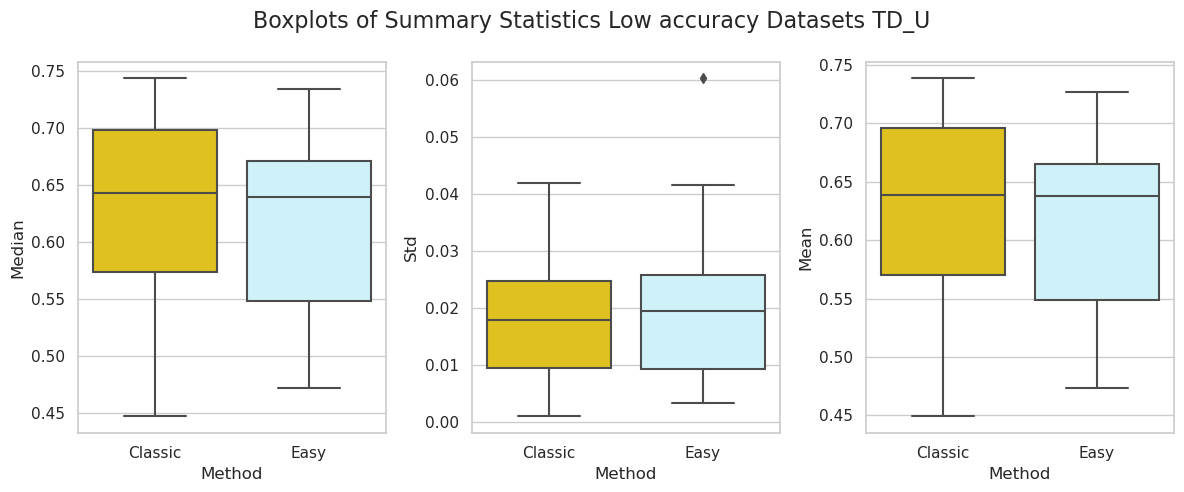

In [66]:
CM = 'TD_U'
summaryStatistics_HardGB_perCM(df_hardGB2,CM)

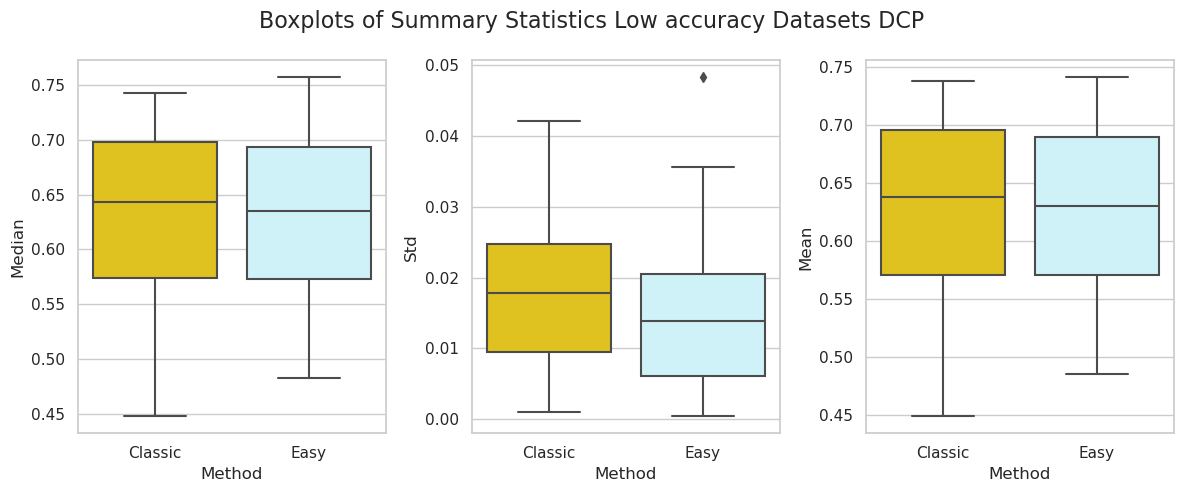

In [67]:
CM = 'DCP'
summaryStatistics_HardGB_perCM(df_hardGB2,CM)

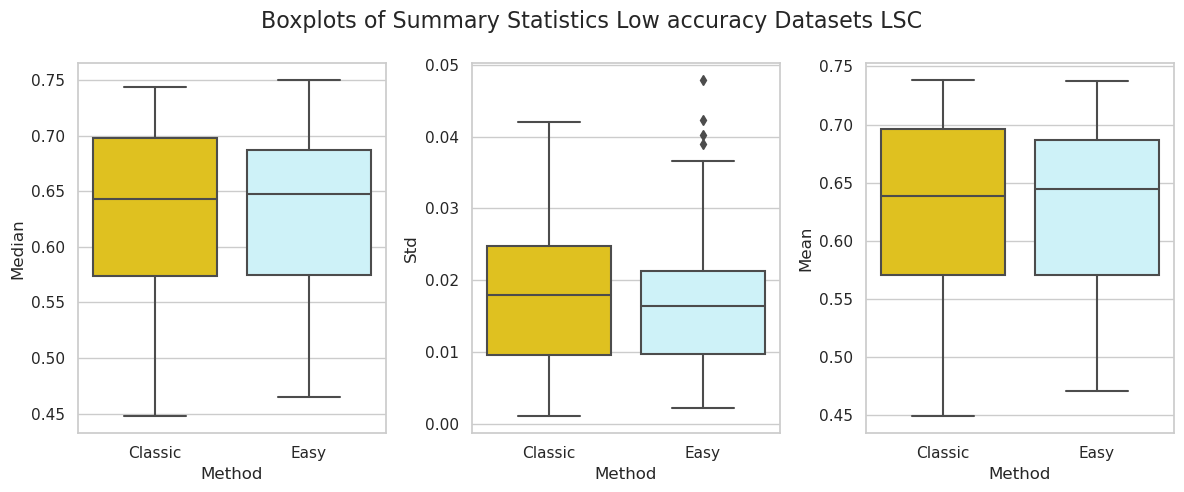

In [68]:
CM = 'LSC'
summaryStatistics_HardGB_perCM(df_hardGB2,CM)

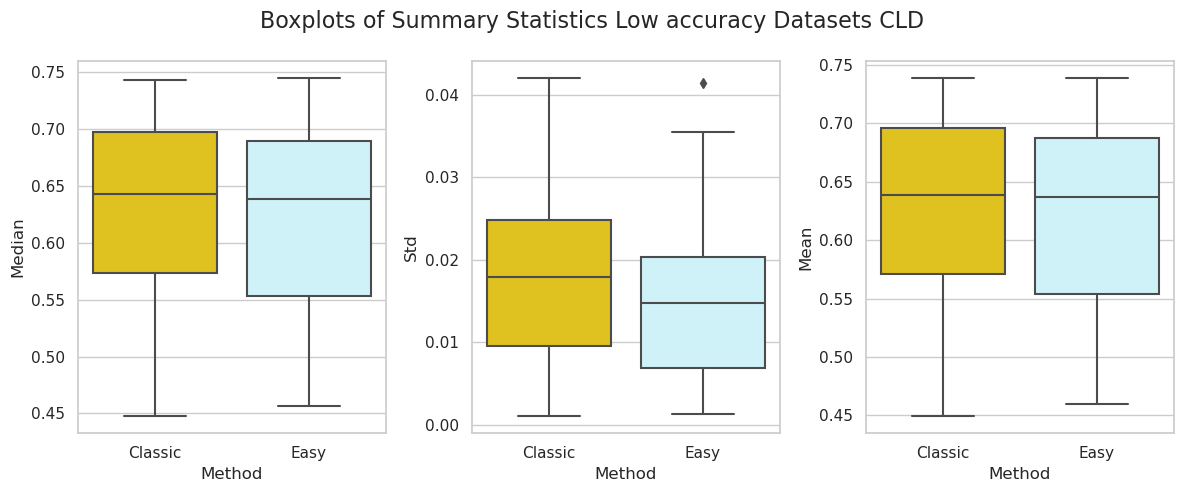

In [69]:
CM = 'CLD'
summaryStatistics_HardGB_perCM(df_hardGB2,CM)

Los resultados son mejores pero tampoco son la repera. Estudiar lo de quién se degrada más, nuestra std es claramente menor y eso juega a nuestro favor

COMENTARIOS A ORGANIZAR

 * TD_U claramente somos peores. Pero es lo que decimos de los árboles. Es la misma información realmente.

  * Con N1, muy similar a kDN pero no hay tanta diferencia con la desviación típica y están bastante igualadas.


En el resto, la tendencia general es la misma: menor desviación estándar pero IQR ahí ahí:
  * La hostilidad tiene una desviación típica claramente menor. Con respecto a media y mediana pues sale un pelín mejor la hostilidad pero también tiene mínimos más bajos y el Q1 es más bajo.
* En kdn la desviación típica también es menor. En media y mediana, el IQR está por debajo del del método clásico, pero nuestros mínimos son más altos.
* Con N2, desviación típica menor. Nuestro Q1 es menor y nuestro Q2 y Q3 mayor. Nuestro mínimo es mayor.
* Con F1, la desviación bastante reñida. Q1 de media y mediana menor, Q3 mayor pero muy similar. Q2 muy muy similar
* DCP, desviación claramente menor la nuestra. Nuestro mínimo y nuestro máximo son mejores pero el IQR está ligeramente desplazado hacia abajo con respecto a GB classic. Q2 peor la nuestra.
* LSC, desviación claramente menor la nuestra. Nuestro mínimo y nuestro máximo son mejores pero el IQR está ligeramente desplazado hacia abajo con respecto a GB classic. Q2 mejor la nuestra.
* CLD, desviación mejor la nuestra. Nuestro mínimo es mayor, pero en el resto de cosas vamos peor: menor Q1, Q2 y Q3.


